# **prepraing data**

## import libraries

In [1]:
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29088 sha256=d542cc77c457b7cf0501a552e4b6918e6f15154ee9ff110f5f03a7468e1f4c90
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 92.4 MB/s eta 0:00:00


In [3]:
!pip install mlflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143860 sha256=a866c40ae38f3ff7447f966c3b6233004a500a4a24f9fdd9b4c2377e49222766
  Stored in directory: /root/.cache/pip/wheel

In [4]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 24.3 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import ta
from ta.momentum import StochasticOscillator
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score, accuracy_score, cohen_kappa_score, matthews_corrcoef
import mlflow
import logging
from torch.profiler import profile, record_function, ProfilerActivity
import shap

## read data

In [6]:
paths = ['V2_vabemellat_30min.csv', 'V2_vabesader_30min.csv', 'V2_vasepehr_30min.csv', 'V2_vatejarat_30min.csv']

In [7]:
df = [pd.read_csv(path) for path in paths]

## show raw data

In [8]:
fig = make_subplots(rows=len(paths), cols=1, shared_xaxes=True, vertical_spacing=0.1)

for i in range(len(paths)):
    fig.add_trace(go.Candlestick(x=df[i]['time'],
                             open=df[i]['open'],
                             high=df[i]['high'],
                             low=df[i]['low'],
                             close=df[i]['close']),
              row=i+1, col=1)
    

# Customize layout
fig.update_layout(title='Candlestick Chart',
                   yaxis_title='Price',
                   xaxis_rangeslider_visible=False)

# Show figure
fig.show()

In [9]:
# Create figure
fig = go.Figure(data=[go.Candlestick(x=df[0]['time'],
                                      open=df[0]['open'],
                                      high=df[0]['high'],
                                      low=df[0]['low'],
                                      close=df[0]['close'])])

# Customize layout
fig.update_layout(title='Candlestick Chart',
                   yaxis_title='Price',
                   xaxis_rangeslider_visible=False)

# Show figure
fig.show()

## preprocessing

In [10]:
for k in range(len(df)):
    l = []
    for i in range(df[k].shape[0]-1, 0, -1):
        if abs((df[k].loc[i, 'open'] - df[k].loc[i-1, 'close']) / df[k].loc[i-1, 'close']) > 0.1:
            temp = df[k].loc[i, 'open'] - df[k].loc[i-1, 'close']
            print(i, '->', temp)
            l += [i]

    for i in l:
        temp = df[k].loc[i, 'open'] - df[k].loc[i-1, 'close']
        df[k].loc[:i-1, ['Price_first', 'Price_max', 'Price_min', 'Price_last', 'high', 'low', 'open', 'close']] += temp

    print("    STEP 1")
    min_values = df[k][['Price_first', 'Price_max', 'Price_min', 'Price_last', 'high', 'low', 'open', 'close']].min()
    min = np.min(list(min_values))
    df[k].loc[:, ['Price_first', 'Price_max', 'Price_min', 'Price_last', 'high', 'low', 'open', 'close']] += -min + 100

    open1 = [0]
    close = [0]
    high = [0]
    low = [0]

    for i in range(1, df[k].shape[0]):
        open1 += [(df[k].loc[i, 'open'] - df[k].loc[i-1, 'open']) / df[k].loc[i-1, 'open']]
        close += [(df[k].loc[i, 'close'] - df[k].loc[i-1, 'close']) / df[k].loc[i-1, 'close']]
        high += [(df[k].loc[i, 'high'] - df[k].loc[i-1, 'high']) / df[k].loc[i-1, 'high']]
        low += [(df[k].loc[i, 'low'] - df[k].loc[i-1, 'low']) / df[k].loc[i-1, 'low']]

    df[k]['open%'] = open1
    df[k]['close%'] = close
    df[k]['high%'] = high
    df[k]['low%'] = low

    print("    STEP 2")


    df[k]['RSI'] = ta.momentum.RSIIndicator(df[k]['close'], window=14).rsi()
    # Create stochastic oscillator with default parameters
    stoch = StochasticOscillator(high=df[k]['high'], low=df[k]['low'], close=df[k]['close'])

    # Add %K and %D lines to DataFrame
    df[k]['%K'] = stoch.stoch()
    df[k]['%D'] = stoch.stoch_signal()

    df[k]['Williams_%R'] = ta.momentum.WilliamsRIndicator(high=df[k]['high'], low=df[k]['low'], close=df[k]['close']).williams_r()
    # calculate the accumulation distribution line using the ta library
    adl = ta.volume.AccDistIndexIndicator(
        high=df[k]['high'],
        low=df[k]['low'],
        close=df[k]['close'],
        volume=df[k]['volume'],
    ).acc_dist_index()

    print("    STEP 3")

    # add the ADL values to your DataFrame
    df[k]['ADL'] = adl

    # Calculate CMF using ta
    df[k]['cmf'] = ta.volume.ChaikinMoneyFlowIndicator(
        high=df[k]['high'], low=df[k]['low'], close=df[k]['close'], volume=df[k]['volume']).chaikin_money_flow()

    # Calculate the OBV values using the ta library
    obv = ta.volume.OnBalanceVolumeIndicator(df[k]['close'], df[k]['volume']).on_balance_volume()

    # Add the OBV values to your DataFrame as a new column
    df[k]['obv'] = obv

    df[k]['macd'] = ta.trend.MACD(df[k]['close']).macd()

    indicator_cloud = ta.trend.IchimokuIndicator(high=df[k]["high"], low=df[k]["low"])
    df[k]['ichimoku_base_line'] = indicator_cloud.ichimoku_base_line()
    df[k]['ichimoku_conversion_line'] = indicator_cloud.ichimoku_conversion_line()
    df[k]['ichimoku_a'] = indicator_cloud.ichimoku_a()
    df[k]['ichimoku_b'] = indicator_cloud.ichimoku_b()


    df[k].dropna(inplace=True)

1640 -> 580.0
1611 -> 749.0
1591 -> 431.0
1314 -> 262.0
1307 -> 287.0
1300 -> 273.0
1272 -> -271.0
1265 -> -275.0
931 -> 193.0
828 -> 281.0
355 -> 105.0
313 -> 42.0
306 -> -51.0
235 -> 100.0
206 -> -70.0
185 -> 89.0
75 -> 98.0
54 -> 52.0
39 -> 19.0
32 -> -50.0
31 -> 53.0
10 -> 38.0
    STEP 1
    STEP 2
    STEP 3
2315 -> 175.0
2257 -> -169.0
860 -> 36.0
414 -> 28.0
386 -> 61.0
344 -> 36.0
229 -> 58.0
109 -> 102.0
108 -> -51.0
53 -> 30.0
24 -> 17.0
    STEP 1
    STEP 2
    STEP 3
4109 -> 364.0
4102 -> 239.0
4094 -> 321.0
4087 -> 188.0
4083 -> 195.0
4076 -> 170.0
4053 -> -190.0
4051 -> 122.0
4050 -> 130.0
3917 -> 180.0
3868 -> 410.0
3861 -> 600.0
3854 -> 510.0
3847 -> 390.0
3842 -> 500.0
3828 -> -120.0
3800 -> 80.0
3772 -> -210.0
3760 -> 140.0
3746 -> -160.0
3739 -> -110.0
3732 -> -120.0
3725 -> 70.0
3574 -> -30.0
3540 -> -50.0
3532 -> -90.0
3524 -> -60.0
3510 -> 250.0
3478 -> 410.0
3409 -> -200.0
3408 -> 200.0
3141 -> -40.0
3079 -> 40.0
3063 -> -30.0
2982 -> -50.0
2871 -> -30.0
2849 -

## show preprocessed data

In [11]:
fig = make_subplots(rows=len(paths), cols=1, shared_xaxes=True, vertical_spacing=0.1)

for i in range(len(paths)):
    fig.add_trace(go.Candlestick(x=df[i]['time'],
                             open=df[i]['open'],
                             high=df[i]['high'],
                             low=df[i]['low'],
                             close=df[i]['close']),
              row=i+1, col=1)
    

# Customize layout
fig.update_layout(title='Candlestick Chart',
                   yaxis_title='Price',
                   xaxis_rangeslider_visible=False)

# Show figure
fig.show()

In [12]:
# Create figure
fig = go.Figure(data=[go.Candlestick(x=df[0]['time'],
                                      open=df[0]['open'],
                                      high=df[0]['high'],
                                      low=df[0]['low'],
                                      close=df[0]['close'])])

# Customize layout
fig.update_layout(title='Candlestick Chart',
                   yaxis_title='Price',
                   xaxis_rangeslider_visible=False)

# Show figure
fig.show()

In [13]:
for k in range(len(df)):
    df[k] = df[k].reset_index(drop=True)

In [14]:
window_size = 100
future_prediction = 14

## compute labels

In [15]:
y = []

for k in range(len(df)):
    temp_y = []

    for i in range(window_size, df[k].shape[0] - future_prediction):
        if df[k].loc[i+future_prediction, 'close'] - df[k].loc[i, 'close'] >= 0:
            temp_y += [1]
        else:
            temp_y += [0]
            
    df[k] = df[k].iloc[:-future_prediction, :]
    y += [temp_y]

In [16]:
close = [df[k]['close'].tolist() for k in range(len(df))]

## feature selection

In [17]:
columns_selection = ['open%', 'close%', 'high%', 'low%', 'RSI', '%K', '%D', 'Williams_%R', 'cmf']

df_finals = [df[k][columns_selection] for k in range(len(df))]

In [18]:
X = []
Y = []

for k in range(len(df_finals)):
    X += [df_finals[k].values.tolist()]
    Y += [y[k]]

In [19]:
def prepare_input(x):
    input_ids = []

    for i in range(len(x)-window_size):
        temp = []
        for j in range(window_size):
            temp += [torch.tensor(x[i+j], dtype=torch.float32)]
        input_ids.append(torch.stack(temp))

    return torch.stack(input_ids, dim=0)

## splite data

In [20]:
train_split_percent = 0.7 
batch_size = 32

In [21]:
x_train = []
y_train = []
x_test = []
y_test = []
train_size = []
test_size = []
train_extra = []
test_extra = []


for k in range(len(df_finals)):

    x = prepare_input(X[k])

    train_size += [int(len(x)*train_split_percent)]
    test_size += [len(x) - train_size[-1]]
                    
    train_extra += [train_size[-1] % batch_size]
    test_extra += [test_size[-1] % batch_size]

    x_train += [x[:train_size[-1] - train_extra[-1]]]
    y_train += [Y[k][:train_size[-1] - train_extra[-1]]]
    x_test += [x[train_size[-1] + test_extra[-1]:]]
    y_test += [Y[k][train_size[-1] + test_extra[-1]:]] 

In [22]:
val_size = [i//2 for i in test_size]

x_val = [x_test[i][:val_size[i]] for i in range(len(x_test))]
y_val = [y_test[i][:val_size[i]] for i in range(len(y_test))]

In [23]:
close_test = [close[k][(train_size[k] + test_extra[k])-100:] for k in range(len(df))]

## show data distribution

In [24]:
counter1 = 0
total = 0

for i in range(len(y_train)): 
    counter1 += sum(y_train[i])
    total += len(y_train[i])

print('train PSD ')
print('class 1 probability : ', counter1/total)
print('class 0 probability : ', (total - counter1)/total)

train PSD 
class 1 probability :  0.4985408560311284
class 0 probability :  0.5014591439688716


In [25]:
counter1 = 0
total = 0

for i in range(len(y_val)): 
    counter1 += sum(y_val[i])
    total += len(y_val[i])

print('val PSD ')
print('class 1 probability : ', counter1/total)
print('class 0 probability : ', (total - counter1)/total)

val PSD 
class 1 probability :  0.5099037917374081
class 0 probability :  0.490096208262592


In [26]:
counter1 = 0
total = 0

for i in range(len(y_test)): 
    counter1 += sum(y_test[i])
    total += len(y_test[i])

print('test PSD ')
print('class 1 probability : ', counter1/total)
print('class 0 probability : ', (total - counter1)/total)

test PSD 
class 1 probability :  0.5212614155251142
class 0 probability :  0.4787385844748858


# **model**

##train and test utils

In [27]:
def train_model(model, logger, mlflow, log=True, num_epochs=100, batch_size=32):
    model = model.to('cuda:0')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)


    # train the model
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_accuracy = 0
        n_sample = 0

        p = []
        r = []
        
        for k in range(len(df_finals)): 
            for i in range(0, x_train[k].shape[0], batch_size):
                # get the batch data
                X_batch = x_train[k][i:i+batch_size]
                y_batch = y_train[k][i:i+batch_size]
                n_sample += len(X_batch)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(X_batch.unsqueeze(1).to('cuda:0'))
                loss = criterion(outputs.squeeze(1), torch.tensor(y_batch).to('cuda:0'))
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs, 1)

                p += list(predicted.cpu())
                r += [y_batch]
                running_accuracy += torch.sum(predicted == torch.tensor(y_batch).to('cuda:0')).item()
          
              # update the running loss
                running_loss += loss.item() * len(X_batch)

        y_true = []
        for q in r:
            y_true += q
        
        y_pred = []
        for q in p:
            y_pred += [q.item()]


        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_micro = f1_score(y_true, y_pred, average='micro')
        accuracy = running_accuracy / n_sample
        # print the average loss for the epoch
        epoch_loss = running_loss / n_sample
        if log:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f} Accuracy: {accuracy:.4f} F1_Macro: {f1_macro:.4f} F1_micro: {f1_micro:.4f}')

        if epoch % 20 == 0:
            if log:
                print("#######################################")
                print(' val evaliation : ')
            model.eval()  # Set the model to evaluation mode
            val_accuracy = 0
            val_num_samples = 0
            
            val_true = []
            val_pred = []
            for k in range(len(x_val)):
                
                for i in range(0, x_val[k].shape[0], batch_size):
                    # get the batch data
                    X_batch = x_val[k][i:i+batch_size]
                    y_batch = y_val[k][i:i+batch_size]

                    outputs = model(X_batch.unsqueeze(1).to('cuda:0'))

                    _, predicted = torch.max(outputs, 1)

                    val_pred += list(predicted.cpu())
                    val_true += [y_batch]
                    val_accuracy += torch.sum(predicted == torch.tensor(y_batch).to('cuda:0')).item()

                    val_num_samples += len(X_batch)

            avg_accuracy = val_accuracy / val_num_samples


            if log:
                print(f"Accuracy: {avg_accuracy:.4f}")
            
            val_y_true = []
            for q in val_true:
                val_y_true += q
            
            val_y_pred = []
            for q in val_pred:
                val_y_pred += [q.item()]
            
            tn, fp, fn, tp = confusion_matrix(val_y_true, val_y_pred).ravel()
            false_positive_rate = fp / (fp + tn)
            false_negative_rate = fn / (tp + fn)
            true_negative_rate = tn / (tn + fp)
            false_discovery_rate = fp/ (tp + fp)
            recall = recall_score(val_y_true, val_y_pred)
            precision = precision_score(val_y_true, val_y_pred)
            acc = accuracy_score(val_y_true, val_y_pred)
            cohen_kappa = cohen_kappa_score(val_y_true, val_y_pred)
            matthews_corr = matthews_corrcoef(val_y_true, val_y_pred)

            if log:
                print('false_positive_rate : ', false_positive_rate)
                print('false_negative_rate : ', false_negative_rate)
                print('true_negative_rate : ', true_negative_rate)
                print('false_discovery_rate : ', false_discovery_rate)
                print('recall : ', recall)
                print('precision : ', precision)
                print('acc : ', acc)
                print('cohen_kappa : ', cohen_kappa)
                print('matthews_corr : ', matthews_corr)
                print("#######################################")
                mlflow.log_metric("false_positive_rate", false_positive_rate, step=epoch)
                mlflow.log_metric("false_negative_rate", false_negative_rate, step=epoch)
                mlflow.log_metric("true_negative_rate", true_negative_rate, step=epoch)
                mlflow.log_metric("false_discovery_rate", false_discovery_rate, step=epoch)
                mlflow.log_metric("recall", recall, step=epoch)
                mlflow.log_metric("precision", precision, step=epoch)
                mlflow.log_metric("acc", acc, step=epoch)
                mlflow.log_metric("cohen_kappa", cohen_kappa, step=epoch)
                mlflow.log_metric("matthews_corr", matthews_corr, step=epoch)

                log_message = f"Epoch [{epoch+1}/{num_epochs}], false_positive_rate: {false_positive_rate:.4f}, false_negative_rate: {false_negative_rate:.4f}, true_negative_rate: {true_negative_rate:.4f}, false_discovery_rate: {false_discovery_rate:.4f}, recall: {recall:.4f}, precision: {precision:.4f}, accuracy: {acc:.4f}, cohen_kappa: {cohen_kappa:.4f}, matthews_corr: {matthews_corr:.4f}"
                logger.info(log_message)
    # End the MLflow run
    mlflow.end_run()

In [28]:
def test_model(model):
    model.eval()  # Set the model to evaluation mode
    
    test_true = []
    test_pred = []
    test_confidence = []
    for k in range(len(x_test)):
        
        for i in range(0, x_test[k].shape[0], batch_size):
            # get the batch data
            X_batch = x_test[k][i:i+batch_size]
            y_batch = y_test[k][i:i+batch_size]

            outputs = model(X_batch.unsqueeze(1).to('cuda:0'))

            confidence, predicted = torch.max(outputs, 1)

            test_pred += list(predicted.cpu())
            test_true += [y_batch]
            test_confidence += list(confidence.cpu().detach())


    test_y_true = []
    for q in test_true:
        test_y_true += q
    
    test_y_pred = []
    for q in test_pred:
        test_y_pred += [q.item()]

    
    tn, fp, fn, tp = confusion_matrix(test_y_true, test_y_pred).ravel()
    false_positive_rate = fp / (fp + tn)
    false_negative_rate = fn / (tp + fn)
    true_negative_rate = tn / (tn + fp)
    false_discovery_rate = fp/ (tp + fp)
    recall = recall_score(test_y_true, test_y_pred)
    precision = precision_score(test_y_true, test_y_pred)
    acc = accuracy_score(test_y_true, test_y_pred)
    cohen_kappa = cohen_kappa_score(test_y_true, test_y_pred)
    matthews_corr = matthews_corrcoef(test_y_true, test_y_pred)
    avg_confidence = torch.stack(test_confidence, dim=0)
    avg_confidence = float(avg_confidence.sum() / avg_confidence.shape[0])

    print('false_positive_rate : ', false_positive_rate)
    print('false_negative_rate : ', false_negative_rate)
    print('true_negative_rate : ', true_negative_rate)
    print('false_discovery_rate : ', false_discovery_rate)
    print('recall : ', recall)
    print('precision : ', precision)
    print('acc : ', acc)
    print('cohen_kappa : ', cohen_kappa)
    print('matthews_corr : ', matthews_corr)
    print('confidence level :', avg_confidence)

## model 1

In [ ]:
# define the model architecture
class IntegerTransformer1(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_heads, num_layers):
        super().__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embedding_dim, num_heads),
            num_layers
        )

        self.fc1 = nn.Linear(num_embeddings*embedding_dim, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 2)

    def forward(self, input_ids):
        output = self.transformer(input_ids.squeeze(1))
        out = self.fc1(output.view((output.shape[0], -1)))
        out = self.relu(out)
        out = self.fc2(out).softmax(dim=1)
        return out

### set logger setting

In [ ]:
# create logger with 'model1'
logger = logging.getLogger('model1')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('model1.log')
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s : %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

### train model 1

In [ ]:
# Start a new experiment
mlflow.set_experiment("model1")

# create an instance of the model
model = IntegerTransformer1(num_embeddings=window_size, embedding_dim=9, num_heads=1, num_layers=2)

train_model(model, logger, mlflow)

2023/06/08 16:41:51 INFO mlflow.tracking.fluent: Experiment with name 'model1' does not exist. Creating a new experiment.


Epoch 1/100, Loss: 0.7025 Accuracy: 0.5117 F1_Macro: 0.5107 F1_micro: 0.5117
#######################################
 val evaliation : 


INFO:model1:Epoch [1/100], false_positive_rate: 0.4555, false_negative_rate: 0.4412, true_negative_rate: 0.5445, false_discovery_rate: 0.4393, recall: 0.5588, precision: 0.5607, accuracy: 0.5518, cohen_kappa: 0.1033, matthews_corr: 0.1033


Accuracy: 0.5518
false_positive_rate :  0.45554272517321015
false_negative_rate :  0.4411764705882353
true_negative_rate :  0.5444572748267898
false_discovery_rate :  0.4393095768374165
recall :  0.5588235294117647
precision :  0.5606904231625836
acc :  0.5517826825127334
cohen_kappa :  0.10327385548336987
matthews_corr :  0.10327445124971106
#######################################
Epoch 2/100, Loss: 0.6687 Accuracy: 0.5912 F1_Macro: 0.5912 F1_micro: 0.5912
Epoch 3/100, Loss: 0.6213 Accuracy: 0.6668 F1_Macro: 0.6668 F1_micro: 0.6668
Epoch 4/100, Loss: 0.5994 Accuracy: 0.6925 F1_Macro: 0.6925 F1_micro: 0.6925
Epoch 5/100, Loss: 0.5840 Accuracy: 0.7144 F1_Macro: 0.7143 F1_micro: 0.7144
Epoch 6/100, Loss: 0.5723 Accuracy: 0.7282 F1_Macro: 0.7281 F1_micro: 0.7282
Epoch 7/100, Loss: 0.5635 Accuracy: 0.7419 F1_Macro: 0.7419 F1_micro: 0.7419
Epoch 8/100, Loss: 0.5561 Accuracy: 0.7509 F1_Macro: 0.7508 F1_micro: 0.7509
Epoch 9/100, Loss: 0.5490 Accuracy: 0.7590 F1_Macro: 0.7590 F1_micro: 0.7590

INFO:model1:Epoch [21/100], false_positive_rate: 0.3712, false_negative_rate: 0.2664, true_negative_rate: 0.6288, false_discovery_rate: 0.3272, recall: 0.7336, precision: 0.6728, accuracy: 0.6822, cohen_kappa: 0.3630, matthews_corr: 0.3646


Accuracy: 0.6822
false_positive_rate :  0.3712471131639723
false_negative_rate :  0.2663706992230855
true_negative_rate :  0.6287528868360277
false_discovery_rate :  0.3272264631043257
recall :  0.7336293007769146
precision :  0.6727735368956743
acc :  0.6822297679683079
cohen_kappa :  0.36304579985805807
matthews_corr :  0.3646073594031404
#######################################
Epoch 22/100, Loss: 0.4895 Accuracy: 0.8316 F1_Macro: 0.8316 F1_micro: 0.8316
Epoch 23/100, Loss: 0.4855 Accuracy: 0.8358 F1_Macro: 0.8358 F1_micro: 0.8358
Epoch 24/100, Loss: 0.4816 Accuracy: 0.8403 F1_Macro: 0.8403 F1_micro: 0.8403
Epoch 25/100, Loss: 0.4777 Accuracy: 0.8458 F1_Macro: 0.8457 F1_micro: 0.8458
Epoch 26/100, Loss: 0.4741 Accuracy: 0.8495 F1_Macro: 0.8495 F1_micro: 0.8495
Epoch 27/100, Loss: 0.4699 Accuracy: 0.8549 F1_Macro: 0.8549 F1_micro: 0.8549
Epoch 28/100, Loss: 0.4673 Accuracy: 0.8567 F1_Macro: 0.8567 F1_micro: 0.8567
Epoch 29/100, Loss: 0.4635 Accuracy: 0.8625 F1_Macro: 0.8625 F1_micro: 

INFO:model1:Epoch [41/100], false_positive_rate: 0.4267, false_negative_rate: 0.2353, true_negative_rate: 0.5733, false_discovery_rate: 0.3491, recall: 0.7647, precision: 0.6509, accuracy: 0.6709, cohen_kappa: 0.3392, matthews_corr: 0.3448


Accuracy: 0.6709
false_positive_rate :  0.4266743648960739
false_negative_rate :  0.23529411764705882
true_negative_rate :  0.5733256351039261
false_discovery_rate :  0.3490788852149268
recall :  0.7647058823529411
precision :  0.6509211147850732
acc :  0.6709111488398415
cohen_kappa :  0.3392298295937768
matthews_corr :  0.34479676147866606
#######################################
Epoch 42/100, Loss: 0.4251 Accuracy: 0.9011 F1_Macro: 0.9011 F1_micro: 0.9011
Epoch 43/100, Loss: 0.4293 Accuracy: 0.8948 F1_Macro: 0.8948 F1_micro: 0.8948
Epoch 44/100, Loss: 0.4212 Accuracy: 0.9039 F1_Macro: 0.9039 F1_micro: 0.9039
Epoch 45/100, Loss: 0.4165 Accuracy: 0.9098 F1_Macro: 0.9098 F1_micro: 0.9098
Epoch 46/100, Loss: 0.4149 Accuracy: 0.9118 F1_Macro: 0.9118 F1_micro: 0.9118
Epoch 47/100, Loss: 0.4129 Accuracy: 0.9129 F1_Macro: 0.9129 F1_micro: 0.9129
Epoch 48/100, Loss: 0.4118 Accuracy: 0.9137 F1_Macro: 0.9137 F1_micro: 0.9137
Epoch 49/100, Loss: 0.4130 Accuracy: 0.9112 F1_Macro: 0.9112 F1_micro:

INFO:model1:Epoch [61/100], false_positive_rate: 0.3054, false_negative_rate: 0.3513, true_negative_rate: 0.6946, false_discovery_rate: 0.3115, recall: 0.6487, precision: 0.6885, accuracy: 0.6712, cohen_kappa: 0.3429, matthews_corr: 0.3435


Accuracy: 0.6712
false_positive_rate :  0.3054272517321016
false_negative_rate :  0.35127635960044395
true_negative_rate :  0.6945727482678984
false_discovery_rate :  0.3115429917550059
recall :  0.6487236403995561
precision :  0.6884570082449941
acc :  0.6711941143180532
cohen_kappa :  0.3428964791545055
matthews_corr :  0.34349102236689005
#######################################
Epoch 62/100, Loss: 0.3899 Accuracy: 0.9328 F1_Macro: 0.9327 F1_micro: 0.9328
Epoch 63/100, Loss: 0.3912 Accuracy: 0.9309 F1_Macro: 0.9309 F1_micro: 0.9309
Epoch 64/100, Loss: 0.3884 Accuracy: 0.9343 F1_Macro: 0.9343 F1_micro: 0.9343
Epoch 65/100, Loss: 0.3861 Accuracy: 0.9363 F1_Macro: 0.9363 F1_micro: 0.9363
Epoch 66/100, Loss: 0.3834 Accuracy: 0.9388 F1_Macro: 0.9388 F1_micro: 0.9388
Epoch 67/100, Loss: 0.3811 Accuracy: 0.9409 F1_Macro: 0.9409 F1_micro: 0.9409
Epoch 68/100, Loss: 0.3806 Accuracy: 0.9418 F1_Macro: 0.9417 F1_micro: 0.9418
Epoch 69/100, Loss: 0.3799 Accuracy: 0.9421 F1_Macro: 0.9421 F1_micro:

INFO:model1:Epoch [81/100], false_positive_rate: 0.3274, false_negative_rate: 0.3102, true_negative_rate: 0.6726, false_discovery_rate: 0.3133, recall: 0.6898, precision: 0.6867, accuracy: 0.6814, cohen_kappa: 0.3625, matthews_corr: 0.3625


Accuracy: 0.6814
false_positive_rate :  0.3273672055427252
false_negative_rate :  0.3102108768035516
true_negative_rate :  0.6726327944572749
false_discovery_rate :  0.3132596685082873
recall :  0.6897891231964484
precision :  0.6867403314917127
acc :  0.6813808715336729
cohen_kappa :  0.36245443452670867
matthews_corr :  0.3624581529237135
#######################################
Epoch 82/100, Loss: 0.3702 Accuracy: 0.9477 F1_Macro: 0.9477 F1_micro: 0.9477
Epoch 83/100, Loss: 0.3667 Accuracy: 0.9518 F1_Macro: 0.9518 F1_micro: 0.9518
Epoch 84/100, Loss: 0.3641 Accuracy: 0.9542 F1_Macro: 0.9542 F1_micro: 0.9542
Epoch 85/100, Loss: 0.3663 Accuracy: 0.9522 F1_Macro: 0.9521 F1_micro: 0.9522
Epoch 86/100, Loss: 0.3675 Accuracy: 0.9514 F1_Macro: 0.9514 F1_micro: 0.9514
Epoch 87/100, Loss: 0.3638 Accuracy: 0.9540 F1_Macro: 0.9540 F1_micro: 0.9540
Epoch 88/100, Loss: 0.3633 Accuracy: 0.9545 F1_Macro: 0.9545 F1_micro: 0.9545
Epoch 89/100, Loss: 0.3641 Accuracy: 0.9534 F1_Macro: 0.9534 F1_micro: 

### test model 1

In [ ]:
test_model(model)

false_positive_rate :  0.3472429210134128
false_negative_rate :  0.34327949630440735
true_negative_rate :  0.6527570789865872
false_discovery_rate :  0.32687991021324353
recall :  0.6567205036955927
precision :  0.6731200897867564
acc :  0.6548230593607306
cohen_kappa :  0.30914308461370676
matthews_corr :  0.30924299819784806


### save model 1

In [ ]:
PATH = "model1_v1.pt"

# Save the model
torch.save(model.state_dict(), PATH)

## model 2

In [29]:
# define the model architecture
class IntegerTransformer2(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_heads, num_layers):
        super().__init__()
        self.conv = nn.Conv2d(kernel_size=(1, embedding_dim), out_channels=1, in_channels=1)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(num_embeddings, num_heads),
            num_layers
        )

        self.fc = nn.Linear(100, 2)

    def forward(self, input_ids):
        embedded = self.conv(input_ids)
        output = self.transformer(embedded.squeeze(3))
        out = self.fc(output.squeeze(1)).softmax(dim=1)
        return out

### set logger setting

In [ ]:
# create logger with 'model2'
logger = logging.getLogger('model2')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('model2.log')
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s : %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

### train model 2

In [ ]:
# Start a new experiment
mlflow.set_experiment("model2")

# create an instance of the model
model = IntegerTransformer2(num_embeddings=window_size, embedding_dim=9, num_heads=4, num_layers=2)

# with TimeTracker():
train_model(model, logger, mlflow)

Epoch 1/100, Loss: 0.6834 Accuracy: 0.5741 F1_Macro: 0.5734 F1_micro: 0.5741
#######################################
 val evaliation : 


INFO:model2:Epoch [1/100], false_positive_rate: 0.3020, false_negative_rate: 0.4695, true_negative_rate: 0.6980, false_discovery_rate: 0.3536, recall: 0.5305, precision: 0.6464, accuracy: 0.6126, cohen_kappa: 0.2277, matthews_corr: 0.2316


Accuracy: 0.6126
false_positive_rate :  0.30196304849884525
false_negative_rate :  0.4694783573806881
true_negative_rate :  0.6980369515011547
false_discovery_rate :  0.35361730899256255
recall :  0.5305216426193119
precision :  0.6463826910074375
acc :  0.6126202603282399
cohen_kappa :  0.22773370570325535
matthews_corr :  0.2316108460817307
#######################################
Time Elapsed: 6.873833458999798 seconds


KeyboardInterrupt: ignored

In [ ]:
profile_model(model)

benchmarking model in Inferece time
profiling model inference in CPU
--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                aten::conv2d         0.33%      16.000us        18.37%     886.000us     886.000us      12.50 Kb           0 b             1  
                           aten::convolution         0.93%      45.000us        18.03%     870.000us     870.000us      12.50 Kb           0 b             1  
                          aten::_convolution         0.44%      21.000us        17.10%     825.000us     825.000us      12.50 Kb        

### test model 2

In [ ]:
test_model(model)

false_positive_rate :  0.35737704918032787
false_negative_rate :  0.2556802627977005
true_negative_rate :  0.6426229508196721
false_discovery_rate :  0.3060234813680449
recall :  0.7443197372022995
precision :  0.6939765186319551
acc :  0.6956335616438356
cohen_kappa :  0.38819334448234455
matthews_corr :  0.3893196166915055


### save model 2

In [ ]:
PATH = "model2_v1.pt"

# Save the model
torch.save(model.state_dict(), PATH)

## model 3

In [ ]:
# define the model architecture
class IntegerTransformer3(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_heads, num_layers):
        super().__init__()
        self.conv = nn.Conv2d(kernel_size=(1, embedding_dim), out_channels=1, in_channels=1)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(num_embeddings, num_heads),
            num_layers
        )

        self.fc1 = nn.Linear(100, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, 2)


    def forward(self, input_ids):
        embedded = self.conv(input_ids)
        output = self.transformer(embedded.squeeze(3))
        out = self.fc1(output.squeeze(1))
        out = self.relu(out)
        out = self.fc2(out).softmax(dim=1)
        return out

### set logger setting

In [ ]:
# create logger with 'model3'
logger = logging.getLogger('model3')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('model3.log')
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s : %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

### train model 3

In [ ]:
# Start a new experiment
mlflow.set_experiment("model3")

# create an instance of the model
model = IntegerTransformer3(num_embeddings=window_size, embedding_dim=9, num_heads=4, num_layers=2)

train_model(model, logger, mlflow)

2023/06/08 16:54:37 INFO mlflow.tracking.fluent: Experiment with name 'model3' does not exist. Creating a new experiment.


Epoch 1/100, Loss: 0.6905 Accuracy: 0.5390 F1_Macro: 0.5373 F1_micro: 0.5390
#######################################
 val evaliation : 


INFO:model3:Epoch [1/100], false_positive_rate: 0.3048, false_negative_rate: 0.5033, true_negative_rate: 0.6952, false_discovery_rate: 0.3710, recall: 0.4967, precision: 0.6290, accuracy: 0.5939, cohen_kappa: 0.1910, matthews_corr: 0.1955


Accuracy: 0.5939
false_positive_rate :  0.30484988452655887
false_negative_rate :  0.5033296337402886
true_negative_rate :  0.6951501154734411
false_discovery_rate :  0.37104708362614197
recall :  0.49667036625971145
precision :  0.6289529163738581
acc :  0.5939445387662705
cohen_kappa :  0.19100866565060648
matthews_corr :  0.19552385341865494
#######################################
Epoch 2/100, Loss: 0.6133 Accuracy: 0.6813 F1_Macro: 0.6813 F1_micro: 0.6813
Epoch 3/100, Loss: 0.5630 Accuracy: 0.7431 F1_Macro: 0.7430 F1_micro: 0.7431
Epoch 4/100, Loss: 0.5425 Accuracy: 0.7645 F1_Macro: 0.7645 F1_micro: 0.7645
Epoch 5/100, Loss: 0.5270 Accuracy: 0.7798 F1_Macro: 0.7797 F1_micro: 0.7798
Epoch 6/100, Loss: 0.5140 Accuracy: 0.7940 F1_Macro: 0.7940 F1_micro: 0.7940
Epoch 7/100, Loss: 0.5199 Accuracy: 0.7881 F1_Macro: 0.7881 F1_micro: 0.7881
Epoch 8/100, Loss: 0.5040 Accuracy: 0.8050 F1_Macro: 0.8049 F1_micro: 0.8050
Epoch 9/100, Loss: 0.4864 Accuracy: 0.8236 F1_Macro: 0.8236 F1_micro: 0.82

INFO:model3:Epoch [21/100], false_positive_rate: 0.2979, false_negative_rate: 0.2575, true_negative_rate: 0.7021, false_discovery_rate: 0.2783, recall: 0.7425, precision: 0.7217, accuracy: 0.7227, cohen_kappa: 0.4448, matthews_corr: 0.4450


Accuracy: 0.7227
false_positive_rate :  0.2979214780600462
false_negative_rate :  0.25749167591564925
true_negative_rate :  0.7020785219399538
false_discovery_rate :  0.2783171521035599
recall :  0.7425083240843507
precision :  0.7216828478964401
acc :  0.722693831352575
cohen_kappa :  0.44484625120702326
matthews_corr :  0.4450393785550236
#######################################
Epoch 22/100, Loss: 0.4440 Accuracy: 0.8668 F1_Macro: 0.8668 F1_micro: 0.8668
Epoch 23/100, Loss: 0.4391 Accuracy: 0.8721 F1_Macro: 0.8721 F1_micro: 0.8721
Epoch 24/100, Loss: 0.4389 Accuracy: 0.8713 F1_Macro: 0.8713 F1_micro: 0.8713
Epoch 25/100, Loss: 0.4358 Accuracy: 0.8745 F1_Macro: 0.8745 F1_micro: 0.8745
Epoch 26/100, Loss: 0.4317 Accuracy: 0.8791 F1_Macro: 0.8791 F1_micro: 0.8791
Epoch 27/100, Loss: 0.4282 Accuracy: 0.8833 F1_Macro: 0.8833 F1_micro: 0.8833
Epoch 28/100, Loss: 0.4334 Accuracy: 0.8775 F1_Macro: 0.8775 F1_micro: 0.8775
Epoch 29/100, Loss: 0.4273 Accuracy: 0.8842 F1_Macro: 0.8842 F1_micro: 

INFO:model3:Epoch [41/100], false_positive_rate: 0.2812, false_negative_rate: 0.2974, true_negative_rate: 0.7188, false_discovery_rate: 0.2778, recall: 0.7026, precision: 0.7222, accuracy: 0.7105, cohen_kappa: 0.4211, matthews_corr: 0.4213


Accuracy: 0.7105
false_positive_rate :  0.28117782909930716
false_negative_rate :  0.2974472807991121
true_negative_rate :  0.7188221709006929
false_discovery_rate :  0.2778094694808899
recall :  0.7025527192008879
precision :  0.7221905305191101
acc :  0.7105263157894737
cohen_kappa :  0.42114347509061634
matthews_corr :  0.421305444621488
#######################################
Epoch 42/100, Loss: 0.4111 Accuracy: 0.9004 F1_Macro: 0.9004 F1_micro: 0.9004
Epoch 43/100, Loss: 0.4095 Accuracy: 0.9016 F1_Macro: 0.9016 F1_micro: 0.9016
Epoch 44/100, Loss: 0.4100 Accuracy: 0.9012 F1_Macro: 0.9012 F1_micro: 0.9012
Epoch 45/100, Loss: 0.4119 Accuracy: 0.8996 F1_Macro: 0.8996 F1_micro: 0.8996
Epoch 46/100, Loss: 0.4089 Accuracy: 0.9028 F1_Macro: 0.9028 F1_micro: 0.9028
Epoch 47/100, Loss: 0.4046 Accuracy: 0.9070 F1_Macro: 0.9070 F1_micro: 0.9070
Epoch 48/100, Loss: 0.4076 Accuracy: 0.9031 F1_Macro: 0.9031 F1_micro: 0.9031
Epoch 49/100, Loss: 0.4067 Accuracy: 0.9053 F1_Macro: 0.9053 F1_micro: 

INFO:model3:Epoch [61/100], false_positive_rate: 0.2425, false_negative_rate: 0.3202, true_negative_rate: 0.7575, false_discovery_rate: 0.2553, recall: 0.6798, precision: 0.7447, accuracy: 0.7179, cohen_kappa: 0.4365, matthews_corr: 0.4383


Accuracy: 0.7179
false_positive_rate :  0.24249422632794457
false_negative_rate :  0.3201997780244173
true_negative_rate :  0.7575057736720554
false_discovery_rate :  0.2553191489361702
recall :  0.6798002219755827
precision :  0.7446808510638298
acc :  0.7178834182229767
cohen_kappa :  0.43653742021180475
matthews_corr :  0.43826605927460077
#######################################
Epoch 62/100, Loss: 0.3942 Accuracy: 0.9175 F1_Macro: 0.9175 F1_micro: 0.9175
Epoch 63/100, Loss: 0.3936 Accuracy: 0.9190 F1_Macro: 0.9190 F1_micro: 0.9190
Epoch 64/100, Loss: 0.3929 Accuracy: 0.9193 F1_Macro: 0.9193 F1_micro: 0.9193
Epoch 65/100, Loss: 0.3996 Accuracy: 0.9112 F1_Macro: 0.9112 F1_micro: 0.9112
Epoch 66/100, Loss: 0.3940 Accuracy: 0.9177 F1_Macro: 0.9177 F1_micro: 0.9177
Epoch 67/100, Loss: 0.3889 Accuracy: 0.9238 F1_Macro: 0.9238 F1_micro: 0.9238
Epoch 68/100, Loss: 0.3929 Accuracy: 0.9183 F1_Macro: 0.9183 F1_micro: 0.9183
Epoch 69/100, Loss: 0.3892 Accuracy: 0.9221 F1_Macro: 0.9221 F1_micro

INFO:model3:Epoch [81/100], false_positive_rate: 0.3383, false_negative_rate: 0.2519, true_negative_rate: 0.6617, false_discovery_rate: 0.3030, recall: 0.7481, precision: 0.6970, accuracy: 0.7057, cohen_kappa: 0.4103, matthews_corr: 0.4115


Accuracy: 0.7057
false_positive_rate :  0.33833718244803695
false_negative_rate :  0.2519422863485017
true_negative_rate :  0.6616628175519631
false_discovery_rate :  0.3029989658738366
recall :  0.7480577136514983
precision :  0.6970010341261634
acc :  0.7057159026598755
cohen_kappa :  0.41032792503250504
matthews_corr :  0.41148199623136783
#######################################
Epoch 82/100, Loss: 0.3818 Accuracy: 0.9307 F1_Macro: 0.9307 F1_micro: 0.9307
Epoch 83/100, Loss: 0.3818 Accuracy: 0.9304 F1_Macro: 0.9304 F1_micro: 0.9304
Epoch 84/100, Loss: 0.3863 Accuracy: 0.9267 F1_Macro: 0.9267 F1_micro: 0.9267
Epoch 85/100, Loss: 0.3859 Accuracy: 0.9264 F1_Macro: 0.9264 F1_micro: 0.9264
Epoch 86/100, Loss: 0.3821 Accuracy: 0.9295 F1_Macro: 0.9295 F1_micro: 0.9295
Epoch 87/100, Loss: 0.3804 Accuracy: 0.9318 F1_Macro: 0.9318 F1_micro: 0.9318
Epoch 88/100, Loss: 0.3813 Accuracy: 0.9304 F1_Macro: 0.9304 F1_micro: 0.9304
Epoch 89/100, Loss: 0.3786 Accuracy: 0.9332 F1_Macro: 0.9332 F1_micro

### test model 3

In [ ]:
test_model(model)

false_positive_rate :  0.3734724292101341
false_negative_rate :  0.24774158226115522
true_negative_rate :  0.6265275707898659
false_discovery_rate :  0.31317170707323166
recall :  0.7522584177388448
precision :  0.6868282929267683
acc :  0.6920662100456622
cohen_kappa :  0.3803953682914313
matthews_corr :  0.38230855329455216


### save model 3

In [ ]:
PATH = "model3_v1.pt"

# Save the model
torch.save(model.state_dict(), PATH)

## model 4

In [ ]:
# define the model architecture
class IntegerTransformer4(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_heads, num_layers):
        super().__init__()
        self.conv = nn.Conv2d(kernel_size=(1, embedding_dim), out_channels=1, in_channels=1)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(num_embeddings, num_heads),
            num_layers
        )

        self.fc1 = nn.Linear(100, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, 2)


    def forward(self, input_ids):
        embedded = self.conv(input_ids)
        output = self.transformer(embedded.squeeze(3))
        out = self.fc1(output.squeeze(1))
        out = self.relu(out)
        out = self.fc2(out).softmax(dim=1)
        return out

### set logger setting

In [ ]:
# create logger with 'model4'
logger = logging.getLogger('model4')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('model4.log')
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s : %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

### train model 4

In [ ]:
# Start a new experiment
mlflow.set_experiment("model4")

# create an instance of the model
model = IntegerTransformer4(num_embeddings=window_size, embedding_dim=9, num_heads=5, num_layers=10)

train_model(model, logger, mlflow)

2023/06/08 17:03:13 INFO mlflow.tracking.fluent: Experiment with name 'model4' does not exist. Creating a new experiment.


Epoch 1/100, Loss: 0.6987 Accuracy: 0.4762 F1_Macro: 0.4760 F1_micro: 0.4762
#######################################
 val evaliation : 


<ipython-input-31-b89abaed366b>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model4:Epoch [1/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 2/100, Loss: 0.6945 Accuracy: 0.4894 F1_Macro: 0.4701 F1_micro: 0.4894
Epoch 3/100, Loss: 0.6938 Accuracy: 0.4694 F1_Macro: 0.4642 F1_micro: 0.4694
Epoch 4/100, Loss: 0.6937 Accuracy: 0.4753 F1_Macro: 0.4662 F1_micro: 0.4753
Epoch 5/100, Loss: 0.6936 Accuracy: 0.4773 F1_Macro: 0.4618 F1_micro: 0.4773
Epoch 6/100, Loss: 0.6935 Accuracy: 0.4777 F1_Macro: 0.4521 F1_micro: 0.4777
Epoch 7/100, Loss: 0.6932 Accuracy: 0.4927 F1_Macro: 0.4692 F1_micro: 0.4927
Epoch 8/100, Loss: 0.6953 Accuracy: 0.4660 F1_Macro: 0.4642 F1_micro: 0.4660
Epoch 9/100, Loss: 0.6943 Accuracy: 0.4625 F1_Macro: 0.4615 F1_micro: 0.4625
Epoch 10/100, Loss: 0.6941 Accuracy: 0.4611 F1_Macro: 0.4594 F1_micro: 0.4611
Epoch 11/100, Loss: 0.6940 Accuracy: 0.4624 F

<ipython-input-31-b89abaed366b>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model4:Epoch [21/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 22/100, Loss: 0.6935 Accuracy: 0.4694 F1_Macro: 0.4542 F1_micro: 0.4694
Epoch 23/100, Loss: 0.6935 Accuracy: 0.4691 F1_Macro: 0.4532 F1_micro: 0.4691
Epoch 24/100, Loss: 0.6934 Accuracy: 0.4694 F1_Macro: 0.4538 F1_micro: 0.4694
Epoch 25/100, Loss: 0.6934 Accuracy: 0.4663 F1_Macro: 0.4548 F1_micro: 0.4663
Epoch 26/100, Loss: 0.6934 Accuracy: 0.4688 F1_Macro: 0.4560 F1_micro: 0.4688
Epoch 27/100, Loss: 0.6934 Accuracy: 0.4638 F1_Macro: 0.4543 F1_micro: 0.4638
Epoch 28/100, Loss: 0.6934 Accuracy: 0.4633 F1_Macro: 0.4569 F1_micro: 0.4633
Epoch 29/100, Loss: 0.6934 Accuracy: 0.4677 F1_Macro: 0.4613 F1_micro: 0.4677
Epoch 30/100, Loss: 0.6934 Accuracy: 0.4651 F1_Macro: 0.4590 F1_micro: 0.4651
Epoch 31/100, Loss: 0.6943 Accuracy: 

INFO:model4:Epoch [41/100], false_positive_rate: 1.0000, false_negative_rate: 0.0000, true_negative_rate: 0.0000, false_discovery_rate: 0.4901, recall: 1.0000, precision: 0.5099, accuracy: 0.5099, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.5099
false_positive_rate :  1.0
false_negative_rate :  0.0
true_negative_rate :  0.0
false_discovery_rate :  0.490096208262592
recall :  1.0
precision :  0.5099037917374081
acc :  0.5099037917374081
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 42/100, Loss: 0.6940 Accuracy: 0.4841 F1_Macro: 0.3981 F1_micro: 0.4841
Epoch 43/100, Loss: 0.6938 Accuracy: 0.4735 F1_Macro: 0.4552 F1_micro: 0.4735
Epoch 44/100, Loss: 0.6937 Accuracy: 0.4588 F1_Macro: 0.4586 F1_micro: 0.4588
Epoch 45/100, Loss: 0.6938 Accuracy: 0.4972 F1_Macro: 0.4826 F1_micro: 0.4972
Epoch 46/100, Loss: 0.6940 Accuracy: 0.4830 F1_Macro: 0.4218 F1_micro: 0.4830
Epoch 47/100, Loss: 0.6938 Accuracy: 0.4792 F1_Macro: 0.4638 F1_micro: 0.4792
Epoch 48/100, Loss: 0.6937 Accuracy: 0.4578 F1_Macro: 0.4576 F1_micro: 0.4578
Epoch 49/100, Loss: 0.6937 Accuracy: 0.4702 F1_Macro: 0.4597 F1_micro: 0.4702
Epoch 50/100, Loss: 0.6936 Accuracy: 0.4712 F1_Macro: 0.4564 F1_micro: 0.4712
Epoch 5

<ipython-input-31-b89abaed366b>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model4:Epoch [61/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 62/100, Loss: 0.6934 Accuracy: 0.4701 F1_Macro: 0.4573 F1_micro: 0.4701
Epoch 63/100, Loss: 0.6933 Accuracy: 0.4627 F1_Macro: 0.4560 F1_micro: 0.4627
Epoch 64/100, Loss: 0.6933 Accuracy: 0.4640 F1_Macro: 0.4615 F1_micro: 0.4640
Epoch 65/100, Loss: 0.6933 Accuracy: 0.4624 F1_Macro: 0.4616 F1_micro: 0.4624
Epoch 66/100, Loss: 0.6933 Accuracy: 0.4675 F1_Macro: 0.4675 F1_micro: 0.4675
Epoch 67/100, Loss: 0.6933 Accuracy: 0.4675 F1_Macro: 0.4672 F1_micro: 0.4675
Epoch 68/100, Loss: 0.6933 Accuracy: 0.4684 F1_Macro: 0.4672 F1_micro: 0.4684
Epoch 69/100, Loss: 0.6933 Accuracy: 0.4703 F1_Macro: 0.4686 F1_micro: 0.4703
Epoch 70/100, Loss: 0.6933 Accuracy: 0.4690 F1_Macro: 0.4663 F1_micro: 0.4690
Epoch 71/100, Loss: 0.6933 Accuracy: 

INFO:model4:Epoch [81/100], false_positive_rate: 1.0000, false_negative_rate: 0.0000, true_negative_rate: 0.0000, false_discovery_rate: 0.4901, recall: 1.0000, precision: 0.5099, accuracy: 0.5099, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.5099
false_positive_rate :  1.0
false_negative_rate :  0.0
true_negative_rate :  0.0
false_discovery_rate :  0.490096208262592
recall :  1.0
precision :  0.5099037917374081
acc :  0.5099037917374081
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 82/100, Loss: 0.6933 Accuracy: 0.4819 F1_Macro: 0.3881 F1_micro: 0.4819
Epoch 83/100, Loss: 0.6933 Accuracy: 0.4843 F1_Macro: 0.4044 F1_micro: 0.4843
Epoch 84/100, Loss: 0.6933 Accuracy: 0.4833 F1_Macro: 0.4411 F1_micro: 0.4833
Epoch 85/100, Loss: 0.6933 Accuracy: 0.4726 F1_Macro: 0.4629 F1_micro: 0.4726
Epoch 86/100, Loss: 0.6933 Accuracy: 0.4645 F1_Macro: 0.4644 F1_micro: 0.4645
Epoch 87/100, Loss: 0.6933 Accuracy: 0.4627 F1_Macro: 0.4606 F1_micro: 0.4627
Epoch 88/100, Loss: 0.6933 Accuracy: 0.4791 F1_Macro: 0.4746 F1_micro: 0.4791
Epoch 89/100, Loss: 0.6933 Accuracy: 0.4797 F1_Macro: 0.4332 F1_micro: 0.4797
Epoch 90/100, Loss: 0.6933 Accuracy: 0.4805 F1_Macro: 0.4368 F1_micro: 0.4805
Epoch 9

### test model 4

In [ ]:
test_model(model)

false_positive_rate :  1.0
false_negative_rate :  0.0
true_negative_rate :  0.0
false_discovery_rate :  0.4787385844748858
recall :  1.0
precision :  0.5212614155251142
acc :  0.5212614155251142
cohen_kappa :  0.0
matthews_corr :  0.0


### save model 4

In [ ]:
PATH = "model4_v1.pt"

# Save the model
torch.save(model.state_dict(), PATH)

## model 5

In [ ]:
# define the model architecture
class IntegerTransformer5(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_heads, num_layers):
        super().__init__()
        self.conv = nn.Conv2d(kernel_size=(1, embedding_dim), out_channels=1, in_channels=1)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(num_embeddings, num_heads),
            num_layers
        )

        self.fc1 = nn.Linear(100, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, 2)


    def forward(self, input_ids):
        embedded = self.conv(input_ids)
        output = self.transformer(embedded.squeeze(3))
        out = self.fc1(output.squeeze(1))
        out = self.relu(out)
        out = self.fc2(out).softmax(dim=1)
        return out

### set logger setting

In [ ]:
# create logger with 'model5'
logger = logging.getLogger('model5')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('model5.log')
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s : %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

### train model 5

In [ ]:
# Start a new experiment
mlflow.set_experiment("model5")

# create an instance of the model
model = IntegerTransformer5(num_embeddings=window_size, embedding_dim=9, num_heads=5, num_layers=5)

train_model(model, logger, mlflow)

2023/06/08 17:21:28 INFO mlflow.tracking.fluent: Experiment with name 'model5' does not exist. Creating a new experiment.


Epoch 1/100, Loss: 0.6960 Accuracy: 0.5205 F1_Macro: 0.5183 F1_micro: 0.5205
#######################################
 val evaliation : 


INFO:model5:Epoch [1/100], false_positive_rate: 0.0092, false_negative_rate: 0.9645, true_negative_rate: 0.9908, false_discovery_rate: 0.2000, recall: 0.0355, precision: 0.8000, accuracy: 0.5037, cohen_kappa: 0.0258, matthews_corr: 0.0883


Accuracy: 0.5037
false_positive_rate :  0.009237875288683603
false_negative_rate :  0.9644839067702553
true_negative_rate :  0.9907621247113164
false_discovery_rate :  0.2
recall :  0.03551609322974473
precision :  0.8
acc :  0.5036785512167515
cohen_kappa :  0.025780380180138174
matthews_corr :  0.08831634497729939
#######################################
Epoch 2/100, Loss: 0.6712 Accuracy: 0.5759 F1_Macro: 0.5755 F1_micro: 0.5759
Epoch 3/100, Loss: 0.6410 Accuracy: 0.6452 F1_Macro: 0.6443 F1_micro: 0.6452
Epoch 4/100, Loss: 0.6187 Accuracy: 0.6756 F1_Macro: 0.6745 F1_micro: 0.6756
Epoch 5/100, Loss: 0.5975 Accuracy: 0.7013 F1_Macro: 0.7011 F1_micro: 0.7013
Epoch 6/100, Loss: 0.5836 Accuracy: 0.7171 F1_Macro: 0.7170 F1_micro: 0.7171
Epoch 7/100, Loss: 0.5854 Accuracy: 0.7155 F1_Macro: 0.7155 F1_micro: 0.7155
Epoch 8/100, Loss: 0.5826 Accuracy: 0.7187 F1_Macro: 0.7187 F1_micro: 0.7187
Epoch 9/100, Loss: 0.5684 Accuracy: 0.7337 F1_Macro: 0.7335 F1_micro: 0.7337
Epoch 10/100, Loss: 0.5518

INFO:model5:Epoch [21/100], false_positive_rate: 0.3176, false_negative_rate: 0.3474, true_negative_rate: 0.6824, false_discovery_rate: 0.3187, recall: 0.6526, precision: 0.6813, accuracy: 0.6672, cohen_kappa: 0.3348, matthews_corr: 0.3351


Accuracy: 0.6672
false_positive_rate :  0.31755196304849886
false_negative_rate :  0.34739178690344064
true_negative_rate :  0.6824480369515011
false_discovery_rate :  0.3186558516801854
recall :  0.6526082130965594
precision :  0.6813441483198146
acc :  0.66723259762309
cohen_kappa :  0.3347709336676351
matthews_corr :  0.33508072926316296
#######################################
Epoch 22/100, Loss: 0.5078 Accuracy: 0.8012 F1_Macro: 0.8012 F1_micro: 0.8012
Epoch 23/100, Loss: 0.5260 Accuracy: 0.7757 F1_Macro: 0.7754 F1_micro: 0.7757
Epoch 24/100, Loss: 0.5126 Accuracy: 0.7928 F1_Macro: 0.7928 F1_micro: 0.7928
Epoch 25/100, Loss: 0.5104 Accuracy: 0.7946 F1_Macro: 0.7946 F1_micro: 0.7946
Epoch 26/100, Loss: 0.5010 Accuracy: 0.8066 F1_Macro: 0.8065 F1_micro: 0.8066
Epoch 27/100, Loss: 0.5026 Accuracy: 0.8031 F1_Macro: 0.8030 F1_micro: 0.8031
Epoch 28/100, Loss: 0.5028 Accuracy: 0.8058 F1_Macro: 0.8056 F1_micro: 0.8058
Epoch 29/100, Loss: 0.5151 Accuracy: 0.7899 F1_Macro: 0.7896 F1_micro: 

INFO:model5:Epoch [41/100], false_positive_rate: 0.3279, false_negative_rate: 0.2891, true_negative_rate: 0.6721, false_discovery_rate: 0.3072, recall: 0.7109, precision: 0.6928, accuracy: 0.6919, cohen_kappa: 0.3831, matthews_corr: 0.3833


Accuracy: 0.6919
false_positive_rate :  0.3279445727482679
false_negative_rate :  0.2891231964483907
true_negative_rate :  0.6720554272517321
false_discovery_rate :  0.3071930773391022
recall :  0.7108768035516093
precision :  0.6928069226608978
acc :  0.6918505942275043
cohen_kappa :  0.38313416697147773
matthews_corr :  0.383270021218867
#######################################
Epoch 42/100, Loss: 0.4841 Accuracy: 0.8267 F1_Macro: 0.8266 F1_micro: 0.8267
Epoch 43/100, Loss: 0.4836 Accuracy: 0.8251 F1_Macro: 0.8251 F1_micro: 0.8251
Epoch 44/100, Loss: 0.4779 Accuracy: 0.8298 F1_Macro: 0.8298 F1_micro: 0.8298
Epoch 45/100, Loss: 0.4935 Accuracy: 0.8148 F1_Macro: 0.8147 F1_micro: 0.8148
Epoch 46/100, Loss: 0.5064 Accuracy: 0.8008 F1_Macro: 0.8007 F1_micro: 0.8008
Epoch 47/100, Loss: 0.5141 Accuracy: 0.7834 F1_Macro: 0.7833 F1_micro: 0.7834
Epoch 48/100, Loss: 0.4925 Accuracy: 0.8027 F1_Macro: 0.8022 F1_micro: 0.8027
Epoch 49/100, Loss: 0.5109 Accuracy: 0.7905 F1_Macro: 0.7902 F1_micro: 0

INFO:model5:Epoch [61/100], false_positive_rate: 0.3251, false_negative_rate: 0.4445, true_negative_rate: 0.6749, false_discovery_rate: 0.3600, recall: 0.5555, precision: 0.6400, accuracy: 0.6140, cohen_kappa: 0.2298, matthews_corr: 0.2319


Accuracy: 0.6140
false_positive_rate :  0.32505773672055427
false_negative_rate :  0.4445061043285239
true_negative_rate :  0.6749422632794457
false_discovery_rate :  0.3599744245524297
recall :  0.5554938956714761
precision :  0.6400255754475703
acc :  0.6140350877192983
cohen_kappa :  0.22982277079843572
matthews_corr :  0.23192655508239188
#######################################
Epoch 62/100, Loss: 0.5021 Accuracy: 0.8025 F1_Macro: 0.8012 F1_micro: 0.8025
Epoch 63/100, Loss: 0.5029 Accuracy: 0.8012 F1_Macro: 0.7993 F1_micro: 0.8012
Epoch 64/100, Loss: 0.4938 Accuracy: 0.8099 F1_Macro: 0.8086 F1_micro: 0.8099
Epoch 65/100, Loss: 0.4799 Accuracy: 0.8231 F1_Macro: 0.8224 F1_micro: 0.8231
Epoch 66/100, Loss: 0.4798 Accuracy: 0.8253 F1_Macro: 0.8246 F1_micro: 0.8253
Epoch 67/100, Loss: 0.4795 Accuracy: 0.8225 F1_Macro: 0.8220 F1_micro: 0.8225
Epoch 68/100, Loss: 0.4810 Accuracy: 0.8206 F1_Macro: 0.8197 F1_micro: 0.8206
Epoch 69/100, Loss: 0.4726 Accuracy: 0.8298 F1_Macro: 0.8293 F1_micro

INFO:model5:Epoch [81/100], false_positive_rate: 0.2800, false_negative_rate: 0.3158, true_negative_rate: 0.7200, false_discovery_rate: 0.2823, recall: 0.6842, precision: 0.7177, accuracy: 0.7018, cohen_kappa: 0.4038, matthews_corr: 0.4043


Accuracy: 0.7018
false_positive_rate :  0.28002309468822173
false_negative_rate :  0.3157602663706992
true_negative_rate :  0.7199769053117783
false_discovery_rate :  0.28230500582072177
recall :  0.6842397336293008
precision :  0.7176949941792782
acc :  0.7017543859649122
cohen_kappa :  0.40383623068344343
matthews_corr :  0.40429281378786924
#######################################
Epoch 82/100, Loss: 0.4511 Accuracy: 0.8591 F1_Macro: 0.8591 F1_micro: 0.8591
Epoch 83/100, Loss: 0.4661 Accuracy: 0.8421 F1_Macro: 0.8421 F1_micro: 0.8421
Epoch 84/100, Loss: 0.4774 Accuracy: 0.8246 F1_Macro: 0.8243 F1_micro: 0.8246
Epoch 85/100, Loss: 0.4717 Accuracy: 0.8287 F1_Macro: 0.8283 F1_micro: 0.8287
Epoch 86/100, Loss: 0.4589 Accuracy: 0.8509 F1_Macro: 0.8509 F1_micro: 0.8509
Epoch 87/100, Loss: 0.4570 Accuracy: 0.8518 F1_Macro: 0.8518 F1_micro: 0.8518
Epoch 88/100, Loss: 0.4605 Accuracy: 0.8501 F1_Macro: 0.8501 F1_micro: 0.8501
Epoch 89/100, Loss: 0.4442 Accuracy: 0.8669 F1_Macro: 0.8669 F1_micr

### test model 5

In [ ]:
test_model(model)

false_positive_rate :  0.25424739195231
false_negative_rate :  0.33698330139611277
true_negative_rate :  0.7457526080476901
false_discovery_rate :  0.26045801526717555
recall :  0.6630166986038872
precision :  0.7395419847328244
acc :  0.7026255707762558
cohen_kappa :  0.40689938716568863
matthews_corr :  0.40927454053280093


### save model 5

In [ ]:
PATH = "model5_v1.pt"

# Save the model
torch.save(model.state_dict(), PATH)

## model 6

In [ ]:
# define the model architecture
class IntegerTransformer6(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_heads, num_layers):
        super().__init__()
        self.conv = nn.Conv2d(kernel_size=(1, embedding_dim), out_channels=1, in_channels=1)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(num_embeddings, num_heads),
            num_layers
        )

        self.fc1 = nn.Linear(100, 200)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(200, 40)
        self.fc3 = nn.Linear(40, 20)
        self.fc4 = nn.Linear(20, 2)

    def forward(self, input_ids):
        embedded = self.conv(input_ids)
        output = self.transformer(embedded.squeeze(3))
        out = self.fc1(output.squeeze(1))
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out).softmax(dim=1)
        return out

### set logger setting

In [ ]:
# create logger with 'model6'
logger = logging.getLogger('model6')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('model6.log')
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s : %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

### train model 6

In [ ]:
# Start a new experiment
mlflow.set_experiment("model6")

# create an instance of the model
model = IntegerTransformer6(num_embeddings=window_size, embedding_dim=9, num_heads=5, num_layers=5)

train_model(model, logger, mlflow)

2023/06/08 17:31:27 INFO mlflow.tracking.fluent: Experiment with name 'model6' does not exist. Creating a new experiment.


Epoch 1/100, Loss: 0.6954 Accuracy: 0.5024 F1_Macro: 0.3898 F1_micro: 0.5024
#######################################
 val evaliation : 


<ipython-input-31-b89abaed366b>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model6:Epoch [1/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 2/100, Loss: 0.6938 Accuracy: 0.4929 F1_Macro: 0.3593 F1_micro: 0.4929
Epoch 3/100, Loss: 0.6937 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 4/100, Loss: 0.6936 Accuracy: 0.4940 F1_Macro: 0.3503 F1_micro: 0.4940
Epoch 5/100, Loss: 0.6934 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 6/100, Loss: 0.6934 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 7/100, Loss: 0.6935 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 8/100, Loss: 0.6938 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 9/100, Loss: 0.6934 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 10/100, Loss: 0.6934 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 11/100, Loss: 0.6936 Accuracy: 0.4905 F

<ipython-input-31-b89abaed366b>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model6:Epoch [21/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 22/100, Loss: 0.6935 Accuracy: 0.4882 F1_Macro: 0.3939 F1_micro: 0.4882
Epoch 23/100, Loss: 0.6934 Accuracy: 0.4920 F1_Macro: 0.3566 F1_micro: 0.4920
Epoch 24/100, Loss: 0.6934 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 25/100, Loss: 0.6934 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 26/100, Loss: 0.6935 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 27/100, Loss: 0.6934 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 28/100, Loss: 0.6933 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 29/100, Loss: 0.6933 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 30/100, Loss: 0.6933 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 31/100, Loss: 0.6933 Accuracy: 

INFO:model6:Epoch [41/100], false_positive_rate: 1.0000, false_negative_rate: 0.0000, true_negative_rate: 0.0000, false_discovery_rate: 0.4901, recall: 1.0000, precision: 0.5099, accuracy: 0.5099, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.5099
false_positive_rate :  1.0
false_negative_rate :  0.0
true_negative_rate :  0.0
false_discovery_rate :  0.490096208262592
recall :  1.0
precision :  0.5099037917374081
acc :  0.5099037917374081
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 42/100, Loss: 0.6935 Accuracy: 0.4836 F1_Macro: 0.3890 F1_micro: 0.4836
Epoch 43/100, Loss: 0.6934 Accuracy: 0.4866 F1_Macro: 0.4155 F1_micro: 0.4866
Epoch 44/100, Loss: 0.6934 Accuracy: 0.4697 F1_Macro: 0.4679 F1_micro: 0.4697
Epoch 45/100, Loss: 0.6933 Accuracy: 0.4717 F1_Macro: 0.4483 F1_micro: 0.4717
Epoch 46/100, Loss: 0.6933 Accuracy: 0.4882 F1_Macro: 0.4327 F1_micro: 0.4882
Epoch 47/100, Loss: 0.6934 Accuracy: 0.4903 F1_Macro: 0.3671 F1_micro: 0.4903
Epoch 48/100, Loss: 0.6933 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 49/100, Loss: 0.6933 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 50/100, Loss: 0.6933 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 5

<ipython-input-31-b89abaed366b>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model6:Epoch [61/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 62/100, Loss: 0.6932 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 63/100, Loss: 0.6932 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 64/100, Loss: 0.6932 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 65/100, Loss: 0.6932 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 66/100, Loss: 0.6932 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 67/100, Loss: 0.6932 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 68/100, Loss: 0.6932 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 69/100, Loss: 0.6933 Accuracy: 0.4881 F1_Macro: 0.3786 F1_micro: 0.4881
Epoch 70/100, Loss: 0.6937 Accuracy: 0.4822 F1_Macro: 0.4700 F1_micro: 0.4822
Epoch 71/100, Loss: 0.6936 Accuracy: 

<ipython-input-31-b89abaed366b>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model6:Epoch [81/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 82/100, Loss: 0.6932 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 83/100, Loss: 0.6933 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 84/100, Loss: 0.6933 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 85/100, Loss: 0.6932 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 86/100, Loss: 0.6932 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 87/100, Loss: 0.6932 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 88/100, Loss: 0.6932 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 89/100, Loss: 0.6932 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 90/100, Loss: 0.6932 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 91/100, Loss: 0.6932 Accuracy: 

### test model 6

In [ ]:
test_model(model)

false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.4787385844748858
cohen_kappa :  0.0
matthews_corr :  0.0


<ipython-input-32-01aac9c9758b>:33: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



### save model 6

In [ ]:
PATH = "model6_v1.pt"

# Save the model
torch.save(model.state_dict(), PATH)

## model 7

In [ ]:
# define the model architecture
class IntegerTransformer7(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_heads, num_layers):
        super().__init__()
        self.conv = nn.Conv2d(kernel_size=(1, embedding_dim), out_channels=1, in_channels=1)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(num_embeddings, num_heads),
            num_layers
        )

        self.fc1 = nn.Linear(100, 50)
        self.relu = nn.Sigmoid()
        self.fc2 = nn.Linear(50, 2)


    def forward(self, input_ids):
        embedded = self.conv(input_ids)
        output = self.transformer(embedded.squeeze(3))
        out = self.fc1(output.squeeze(1))
        out = self.relu(out)
        out = self.fc2(out).softmax(dim=1)
        return out

### set logger setting

In [ ]:
# create logger with 'model7'
logger = logging.getLogger('model7')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('model7.log')
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s : %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

### train model 7

In [ ]:
# Start a new experiment
mlflow.set_experiment("model7")

# create an instance of the model
model = IntegerTransformer7(num_embeddings=window_size, embedding_dim=9, num_heads=5, num_layers=5)

train_model(model, logger, mlflow)

2023/06/08 17:41:48 INFO mlflow.tracking.fluent: Experiment with name 'model7' does not exist. Creating a new experiment.


Epoch 1/100, Loss: 0.6981 Accuracy: 0.4782 F1_Macro: 0.4774 F1_micro: 0.4782
#######################################
 val evaliation : 


<ipython-input-31-b89abaed366b>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model7:Epoch [1/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 2/100, Loss: 0.6953 Accuracy: 0.4776 F1_Macro: 0.4752 F1_micro: 0.4776
Epoch 3/100, Loss: 0.6949 Accuracy: 0.4695 F1_Macro: 0.4693 F1_micro: 0.4695
Epoch 4/100, Loss: 0.6947 Accuracy: 0.4748 F1_Macro: 0.4745 F1_micro: 0.4748
Epoch 5/100, Loss: 0.6960 Accuracy: 0.4874 F1_Macro: 0.4870 F1_micro: 0.4874
Epoch 6/100, Loss: 0.6951 Accuracy: 0.4732 F1_Macro: 0.4732 F1_micro: 0.4732
Epoch 7/100, Loss: 0.6947 Accuracy: 0.4706 F1_Macro: 0.4704 F1_micro: 0.4706
Epoch 8/100, Loss: 0.6946 Accuracy: 0.4632 F1_Macro: 0.4624 F1_micro: 0.4632
Epoch 9/100, Loss: 0.6945 Accuracy: 0.4598 F1_Macro: 0.4588 F1_micro: 0.4598
Epoch 10/100, Loss: 0.6944 Accuracy: 0.4596 F1_Macro: 0.4579 F1_micro: 0.4596
Epoch 11/100, Loss: 0.6943 Accuracy: 0.4621 F

<ipython-input-31-b89abaed366b>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model7:Epoch [21/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 22/100, Loss: 0.6941 Accuracy: 0.4629 F1_Macro: 0.4590 F1_micro: 0.4629
Epoch 23/100, Loss: 0.6941 Accuracy: 0.4679 F1_Macro: 0.4631 F1_micro: 0.4679
Epoch 24/100, Loss: 0.6941 Accuracy: 0.4634 F1_Macro: 0.4602 F1_micro: 0.4634
Epoch 25/100, Loss: 0.6941 Accuracy: 0.4624 F1_Macro: 0.4590 F1_micro: 0.4624
Epoch 26/100, Loss: 0.6940 Accuracy: 0.4674 F1_Macro: 0.4622 F1_micro: 0.4674
Epoch 27/100, Loss: 0.6941 Accuracy: 0.4624 F1_Macro: 0.4587 F1_micro: 0.4624
Epoch 28/100, Loss: 0.6940 Accuracy: 0.4657 F1_Macro: 0.4609 F1_micro: 0.4657
Epoch 29/100, Loss: 0.6940 Accuracy: 0.4660 F1_Macro: 0.4609 F1_micro: 0.4660
Epoch 30/100, Loss: 0.6940 Accuracy: 0.4674 F1_Macro: 0.4622 F1_micro: 0.4674
Epoch 31/100, Loss: 0.6940 Accuracy: 

<ipython-input-31-b89abaed366b>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model7:Epoch [41/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 42/100, Loss: 0.6940 Accuracy: 0.4674 F1_Macro: 0.4611 F1_micro: 0.4674
Epoch 43/100, Loss: 0.6940 Accuracy: 0.4689 F1_Macro: 0.4623 F1_micro: 0.4689
Epoch 44/100, Loss: 0.6940 Accuracy: 0.4689 F1_Macro: 0.4623 F1_micro: 0.4689
Epoch 45/100, Loss: 0.6940 Accuracy: 0.4674 F1_Macro: 0.4611 F1_micro: 0.4674
Epoch 46/100, Loss: 0.6939 Accuracy: 0.4688 F1_Macro: 0.4620 F1_micro: 0.4688
Epoch 47/100, Loss: 0.6939 Accuracy: 0.4688 F1_Macro: 0.4620 F1_micro: 0.4688
Epoch 48/100, Loss: 0.6939 Accuracy: 0.4688 F1_Macro: 0.4620 F1_micro: 0.4688
Epoch 49/100, Loss: 0.6939 Accuracy: 0.4688 F1_Macro: 0.4620 F1_micro: 0.4688
Epoch 50/100, Loss: 0.6939 Accuracy: 0.4696 F1_Macro: 0.4626 F1_micro: 0.4696
Epoch 51/100, Loss: 0.6939 Accuracy: 

<ipython-input-31-b89abaed366b>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model7:Epoch [61/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 62/100, Loss: 0.6939 Accuracy: 0.4706 F1_Macro: 0.4628 F1_micro: 0.4706
Epoch 63/100, Loss: 0.6939 Accuracy: 0.4701 F1_Macro: 0.4621 F1_micro: 0.4701
Epoch 64/100, Loss: 0.6939 Accuracy: 0.4701 F1_Macro: 0.4621 F1_micro: 0.4701
Epoch 65/100, Loss: 0.6939 Accuracy: 0.4701 F1_Macro: 0.4621 F1_micro: 0.4701
Epoch 66/100, Loss: 0.6939 Accuracy: 0.4701 F1_Macro: 0.4621 F1_micro: 0.4701
Epoch 67/100, Loss: 0.6939 Accuracy: 0.4702 F1_Macro: 0.4617 F1_micro: 0.4702
Epoch 68/100, Loss: 0.6939 Accuracy: 0.4702 F1_Macro: 0.4617 F1_micro: 0.4702
Epoch 69/100, Loss: 0.6939 Accuracy: 0.4686 F1_Macro: 0.4603 F1_micro: 0.4686
Epoch 70/100, Loss: 0.6939 Accuracy: 0.4702 F1_Macro: 0.4617 F1_micro: 0.4702
Epoch 71/100, Loss: 0.6939 Accuracy: 

<ipython-input-31-b89abaed366b>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model7:Epoch [81/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 82/100, Loss: 0.6939 Accuracy: 0.4677 F1_Macro: 0.4568 F1_micro: 0.4677
Epoch 83/100, Loss: 0.6939 Accuracy: 0.4677 F1_Macro: 0.4568 F1_micro: 0.4677
Epoch 84/100, Loss: 0.6939 Accuracy: 0.4677 F1_Macro: 0.4568 F1_micro: 0.4677
Epoch 85/100, Loss: 0.6939 Accuracy: 0.4677 F1_Macro: 0.4568 F1_micro: 0.4677
Epoch 86/100, Loss: 0.6939 Accuracy: 0.4677 F1_Macro: 0.4568 F1_micro: 0.4677
Epoch 87/100, Loss: 0.6939 Accuracy: 0.4677 F1_Macro: 0.4568 F1_micro: 0.4677
Epoch 88/100, Loss: 0.6939 Accuracy: 0.4677 F1_Macro: 0.4568 F1_micro: 0.4677
Epoch 89/100, Loss: 0.6938 Accuracy: 0.4677 F1_Macro: 0.4568 F1_micro: 0.4677
Epoch 90/100, Loss: 0.6938 Accuracy: 0.4677 F1_Macro: 0.4568 F1_micro: 0.4677
Epoch 91/100, Loss: 0.6938 Accuracy: 

### test model 7

In [ ]:
test_model(model)

false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.4787385844748858
cohen_kappa :  0.0
matthews_corr :  0.0


<ipython-input-32-01aac9c9758b>:33: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



### save model 7

In [ ]:
PATH = "model7_v1.pt"

# Save the model
torch.save(model.state_dict(), PATH)

## model 8

In [ ]:
# define the model architecture
class IntegerTransformer8(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_heads, num_layers):
        super().__init__()
        self.conv = nn.Conv2d(kernel_size=(1, embedding_dim), out_channels=1, in_channels=1)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(num_embeddings, num_heads),
            num_layers
        )

        self.fc1 = nn.Linear(100, 100)
        self.relu = nn.ReLU()
        self.fc15 = nn.Linear(100, 50)
        self.fc2 = nn.Linear(50, 2)
        self.dropout = nn.Dropout(0.2)


    def forward(self, input_ids):
        embedded = self.conv(input_ids)
        output = self.transformer(embedded.squeeze(3))
        out = output.squeeze(1)
        # out = self.dropout(output.squeeze(1))
        out = self.fc1(output.squeeze(1))
        out = self.relu(out)
        out = self.relu(self.fc15(out))
        out = self.dropout(out)
        out = self.fc2(out).softmax(dim=1)
        return out

In [ ]:
# create logger with 'model5'
logger = logging.getLogger('model8')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('model8.log')
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s : %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

In [ ]:
# Start a new experiment
mlflow.set_experiment("model8")

# create an instance of the model
model = IntegerTransformer8(num_embeddings=window_size, embedding_dim=9, num_heads=5, num_layers=5)

train_model(model, logger, mlflow)

2023/06/08 23:18:34 INFO mlflow.tracking.fluent: Experiment with name 'model8' does not exist. Creating a new experiment.


Epoch 1/100, Loss: 0.6959 Accuracy: 0.5140 F1_Macro: 0.4920 F1_micro: 0.5140
#######################################
 val evaliation : 


<ipython-input-25-b89abaed366b>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model8:Epoch [1/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 2/100, Loss: 0.6822 Accuracy: 0.5596 F1_Macro: 0.5485 F1_micro: 0.5596
Epoch 3/100, Loss: 0.6742 Accuracy: 0.5916 F1_Macro: 0.5723 F1_micro: 0.5916
Epoch 4/100, Loss: 0.6679 Accuracy: 0.5965 F1_Macro: 0.5624 F1_micro: 0.5965
Epoch 5/100, Loss: 0.6449 Accuracy: 0.6483 F1_Macro: 0.6442 F1_micro: 0.6483
Epoch 6/100, Loss: 0.6445 Accuracy: 0.6369 F1_Macro: 0.6364 F1_micro: 0.6369
Epoch 7/100, Loss: 0.6439 Accuracy: 0.6436 F1_Macro: 0.6363 F1_micro: 0.6436
Epoch 8/100, Loss: 0.6247 Accuracy: 0.6600 F1_Macro: 0.6537 F1_micro: 0.6600
Epoch 9/100, Loss: 0.6075 Accuracy: 0.6825 F1_Macro: 0.6823 F1_micro: 0.6825
Epoch 10/100, Loss: 0.6065 Accuracy: 0.7008 F1_Macro: 0.7008 F1_micro: 0.7008
Epoch 11/100, Loss: 0.5803 Accuracy: 0.7204 F

INFO:model8:Epoch [21/100], false_positive_rate: 0.2356, false_negative_rate: 0.4689, true_negative_rate: 0.7644, false_discovery_rate: 0.2989, recall: 0.5311, precision: 0.7011, accuracy: 0.6454, cohen_kappa: 0.2941, matthews_corr: 0.3034


Accuracy: 0.6454
false_positive_rate :  0.23556581986143188
false_negative_rate :  0.46892341842397334
true_negative_rate :  0.7644341801385681
false_discovery_rate :  0.2989010989010989
recall :  0.5310765815760267
precision :  0.701098901098901
acc :  0.6454442558007923
cohen_kappa :  0.294069652102964
matthews_corr :  0.30340905430495596
#######################################
Epoch 22/100, Loss: 0.5676 Accuracy: 0.7336 F1_Macro: 0.7325 F1_micro: 0.7336
Epoch 23/100, Loss: 0.5664 Accuracy: 0.7372 F1_Macro: 0.7355 F1_micro: 0.7372
Epoch 24/100, Loss: 0.5580 Accuracy: 0.7453 F1_Macro: 0.7453 F1_micro: 0.7453
Epoch 25/100, Loss: 0.5556 Accuracy: 0.7298 F1_Macro: 0.7275 F1_micro: 0.7298
Epoch 26/100, Loss: 0.5150 Accuracy: 0.7941 F1_Macro: 0.7940 F1_micro: 0.7941
Epoch 27/100, Loss: 0.6139 Accuracy: 0.6947 F1_Macro: 0.6906 F1_micro: 0.6947
Epoch 28/100, Loss: 0.7575 Accuracy: 0.5378 F1_Macro: 0.4926 F1_micro: 0.5378
Epoch 29/100, Loss: 0.5868 Accuracy: 0.7188 F1_Macro: 0.7182 F1_micro: 

INFO:model8:Epoch [41/100], false_positive_rate: 0.3366, false_negative_rate: 0.2986, true_negative_rate: 0.6634, false_discovery_rate: 0.3156, recall: 0.7014, precision: 0.6844, accuracy: 0.6828, cohen_kappa: 0.3650, matthews_corr: 0.3651


Accuracy: 0.6828
false_positive_rate :  0.3366050808314088
false_negative_rate :  0.2985571587125416
true_negative_rate :  0.6633949191685913
false_discovery_rate :  0.3156469951272334
recall :  0.7014428412874584
precision :  0.6843530048727666
acc :  0.6827956989247311
cohen_kappa :  0.36502196353313
matthews_corr :  0.36514060374225926
#######################################
Epoch 42/100, Loss: 0.5067 Accuracy: 0.7980 F1_Macro: 0.7980 F1_micro: 0.7980
Epoch 43/100, Loss: 0.5015 Accuracy: 0.8054 F1_Macro: 0.8053 F1_micro: 0.8054
Epoch 44/100, Loss: 0.4790 Accuracy: 0.8313 F1_Macro: 0.8313 F1_micro: 0.8313
Epoch 45/100, Loss: 0.4787 Accuracy: 0.8307 F1_Macro: 0.8307 F1_micro: 0.8307
Epoch 46/100, Loss: 0.4773 Accuracy: 0.8326 F1_Macro: 0.8326 F1_micro: 0.8326
Epoch 47/100, Loss: 0.4676 Accuracy: 0.8424 F1_Macro: 0.8424 F1_micro: 0.8424
Epoch 48/100, Loss: 0.4836 Accuracy: 0.8276 F1_Macro: 0.8276 F1_micro: 0.8276
Epoch 49/100, Loss: 0.4805 Accuracy: 0.8277 F1_Macro: 0.8277 F1_micro: 0.

INFO:model8:Epoch [61/100], false_positive_rate: 0.3020, false_negative_rate: 0.3596, true_negative_rate: 0.6980, false_discovery_rate: 0.3119, recall: 0.6404, precision: 0.6881, accuracy: 0.6686, cohen_kappa: 0.3380, matthews_corr: 0.3388


Accuracy: 0.6686
false_positive_rate :  0.30196304849884525
false_negative_rate :  0.35960044395116536
true_negative_rate :  0.6980369515011547
false_discovery_rate :  0.3118664281454979
recall :  0.6403995560488346
precision :  0.6881335718545021
acc :  0.6686474250141483
cohen_kappa :  0.337962762991055
matthews_corr :  0.33880987413906316
#######################################
Epoch 62/100, Loss: 0.4499 Accuracy: 0.8608 F1_Macro: 0.8608 F1_micro: 0.8608
Epoch 63/100, Loss: 0.4528 Accuracy: 0.8577 F1_Macro: 0.8577 F1_micro: 0.8577
Epoch 64/100, Loss: 0.4504 Accuracy: 0.8592 F1_Macro: 0.8592 F1_micro: 0.8592
Epoch 65/100, Loss: 0.4360 Accuracy: 0.8738 F1_Macro: 0.8738 F1_micro: 0.8738
Epoch 66/100, Loss: 0.4382 Accuracy: 0.8724 F1_Macro: 0.8724 F1_micro: 0.8724
Epoch 67/100, Loss: 0.4348 Accuracy: 0.8760 F1_Macro: 0.8760 F1_micro: 0.8760
Epoch 68/100, Loss: 0.4393 Accuracy: 0.8717 F1_Macro: 0.8717 F1_micro: 0.8717
Epoch 69/100, Loss: 0.4364 Accuracy: 0.8743 F1_Macro: 0.8743 F1_micro:

INFO:model8:Epoch [81/100], false_positive_rate: 0.2985, false_negative_rate: 0.3529, true_negative_rate: 0.7015, false_discovery_rate: 0.3072, recall: 0.6471, precision: 0.6928, accuracy: 0.6737, cohen_kappa: 0.3481, matthews_corr: 0.3489


Accuracy: 0.6737
false_positive_rate :  0.2984988452655889
false_negative_rate :  0.35294117647058826
true_negative_rate :  0.7015011547344111
false_discovery_rate :  0.30718954248366015
recall :  0.6470588235294118
precision :  0.6928104575163399
acc :  0.6737408036219581
cohen_kappa :  0.3480954515653093
matthews_corr :  0.3488860378315999
#######################################
Epoch 82/100, Loss: 0.4277 Accuracy: 0.8841 F1_Macro: 0.8841 F1_micro: 0.8841
Epoch 83/100, Loss: 0.4176 Accuracy: 0.8937 F1_Macro: 0.8937 F1_micro: 0.8937
Epoch 84/100, Loss: 0.4178 Accuracy: 0.8931 F1_Macro: 0.8931 F1_micro: 0.8931
Epoch 85/100, Loss: 0.4156 Accuracy: 0.8957 F1_Macro: 0.8957 F1_micro: 0.8957
Epoch 86/100, Loss: 0.4165 Accuracy: 0.8943 F1_Macro: 0.8943 F1_micro: 0.8943
Epoch 87/100, Loss: 0.4175 Accuracy: 0.8943 F1_Macro: 0.8943 F1_micro: 0.8943
Epoch 88/100, Loss: 0.4110 Accuracy: 0.9008 F1_Macro: 0.9008 F1_micro: 0.9008
Epoch 89/100, Loss: 0.4147 Accuracy: 0.8969 F1_Macro: 0.8969 F1_micro:

In [ ]:
test_model(model)

false_positive_rate :  0.3076005961251863
false_negative_rate :  0.3304133588831098
true_negative_rate :  0.6923994038748137
false_discovery_rate :  0.29672225416906267
recall :  0.6695866411168903
precision :  0.7032777458309373
acc :  0.68050799086758
cohen_kappa :  0.36121753248075006
matthews_corr :  0.3616685833999545


In [ ]:
PATH = "model8_v1.pt"

# Save the model
torch.save(model.state_dict(), PATH)

## model 9

In [ ]:
import random

In [ ]:
def train_model_v2(model, logger, mlflow):
    model = model.to('cuda:0')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # set the number of epochs and batch size
    num_epochs = 100


    # train the model
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_accuracy = 0
        n_sample = 0

        p = []
        r = []
        
        for k in range(1): 
            for i in range(0, x_train[k].shape[0], batch_size):
                # get the batch data
                randomList = random.sample(range(0, x_train[k].shape[0]), 32)
                index_tensor = torch.tensor(randomList)

                result_tensorX = torch.index_select(torch.tensor(x_train[k]), dim=0, index=index_tensor)
                result_tensorY = torch.index_select(torch.tensor(y_train[k]), dim=0, index=index_tensor)
                X_batch = result_tensorX
                y_batch =  result_tensorY
                n_sample += len(X_batch)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(X_batch.unsqueeze(1).to('cuda:0'))
                loss = criterion(outputs.squeeze(1), torch.tensor(y_batch).to('cuda:0'))
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs, 1)

                p += list(predicted.cpu())
                r += [y_batch]
                running_accuracy += torch.sum(predicted == torch.tensor(y_batch).to('cuda:0')).item()
          
              # update the running loss
                running_loss += loss.item() * len(X_batch)

        y_true = []
        for q in r:
            y_true += q
        
        y_pred = []
        for q in p:
            y_pred += [q.item()]


        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_micro = f1_score(y_true, y_pred, average='micro')
        accuracy = running_accuracy / n_sample
        # print the average loss for the epoch
        epoch_loss = running_loss / n_sample
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f} Accuracy: {accuracy:.4f} F1_Macro: {f1_macro:.4f} F1_micro: {f1_micro:.4f}')

        if epoch % 20 == 0:
            print("#######################################")
            print(' val evaliation : ')
            model.eval()  # Set the model to evaluation mode
            val_accuracy = 0
            val_num_samples = 0
            
            val_true = []
            val_pred = []
            for k in range(1):
                
                for i in range(0, x_val[k].shape[0], 1):
                    # get the batch data
                    X_batch = x_val[k][i:i+1]
                    y_batch = y_val[k][i:i+1]

                    outputs = model(X_batch.unsqueeze(1).to('cuda:0'))

                    _, predicted = torch.max(outputs, 1)

                    val_pred += list(predicted.cpu())
                    val_true += [y_batch]
                    val_accuracy += torch.sum(predicted == torch.tensor(y_batch).to('cuda:0')).item()

                    val_num_samples += len(X_batch)

            avg_accuracy = val_accuracy / val_num_samples

            print(f"Accuracy: {avg_accuracy:.4f}")
            
            val_y_true = []
            for q in val_true:
                val_y_true += q
            
            val_y_pred = []
            for q in val_pred:
                val_y_pred += [q.item()]
            
            tn, fp, fn, tp = confusion_matrix(val_y_true, val_y_pred).ravel()
            false_positive_rate = fp / (fp + tn)
            false_negative_rate = fn / (tp + fn)
            true_negative_rate = tn / (tn + fp)
            false_discovery_rate = fp/ (tp + fp)
            recall = recall_score(val_y_true, val_y_pred)
            precision = precision_score(val_y_true, val_y_pred)
            acc = accuracy_score(val_y_true, val_y_pred)
            cohen_kappa = cohen_kappa_score(val_y_true, val_y_pred)
            matthews_corr = matthews_corrcoef(val_y_true, val_y_pred)

            print('false_positive_rate : ', false_positive_rate)
            print('false_negative_rate : ', false_negative_rate)
            print('true_negative_rate : ', true_negative_rate)
            print('false_discovery_rate : ', false_discovery_rate)
            print('recall : ', recall)
            print('precision : ', precision)
            print('acc : ', acc)
            print('cohen_kappa : ', cohen_kappa)
            print('matthews_corr : ', matthews_corr)
            print("#######################################")
            mlflow.log_metric("false_positive_rate", false_positive_rate, step=epoch)
            mlflow.log_metric("false_negative_rate", false_negative_rate, step=epoch)
            mlflow.log_metric("true_negative_rate", true_negative_rate, step=epoch)
            mlflow.log_metric("false_discovery_rate", false_discovery_rate, step=epoch)
            mlflow.log_metric("recall", recall, step=epoch)
            mlflow.log_metric("precision", precision, step=epoch)
            mlflow.log_metric("acc", acc, step=epoch)
            mlflow.log_metric("cohen_kappa", cohen_kappa, step=epoch)
            mlflow.log_metric("matthews_corr", matthews_corr, step=epoch)

            log_message = f"Epoch [{epoch+1}/{num_epochs}], false_positive_rate: {false_positive_rate:.4f}, false_negative_rate: {false_negative_rate:.4f}, true_negative_rate: {true_negative_rate:.4f}, false_discovery_rate: {false_discovery_rate:.4f}, recall: {recall:.4f}, precision: {precision:.4f}, accuracy: {acc:.4f}, cohen_kappa: {cohen_kappa:.4f}, matthews_corr: {matthews_corr:.4f}"
            logger.info(log_message)
    # End the MLflow run
    mlflow.end_run()

In [ ]:
# define the model architecture
class IntegerTransformer9(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_heads, num_layers):
        super().__init__()
        self.conv = nn.Conv2d(kernel_size=(1, embedding_dim), out_channels=1, in_channels=1)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(num_embeddings, num_heads),
            num_layers
        )

        self.fc1 = nn.Linear(100, 100)
        self.relu = nn.ReLU()
        self.fc15 = nn.Linear(100, 50)
        self.fc2 = nn.Linear(50, 2)
        self.dropout = nn.Dropout(0.2)
        self.batchNorm1 = nn.BatchNorm1d(100)
        self.batchNorm2 = nn.BatchNorm1d(50)


    def forward(self, input_ids):
        embedded = self.conv(input_ids)
        output = self.transformer(embedded.squeeze(3))
        out = output.squeeze(1)
        # out = self.dropout(output.squeeze(1))
        out = self.fc1(output.squeeze(1))
        out = self.relu(out)
        out = self.batchNorm1(out)
        out = self.relu(self.fc15(out))
        out = self.batchNorm2(out)
        out = self.dropout(out)
        out = self.fc2(out).softmax(dim=1)
        return out

In [ ]:
# create logger with 'model5'
logger = logging.getLogger('model9')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('model9.log')
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s : %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

In [ ]:
# Start a new experiment
mlflow.set_experiment("model9")

# create an instance of the model
model = IntegerTransformer9(num_embeddings=window_size, embedding_dim=9, num_heads=5, num_layers=5)

train_model_v2(model, logger, mlflow)

<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 1/100, Loss: 0.7002 Accuracy: 0.5166 F1_Macro: 0.5158 F1_micro: 0.5166
#######################################
 val evaliation : 


INFO:model9:Epoch [1/100], false_positive_rate: 0.6029, false_negative_rate: 0.3968, true_negative_rate: 0.3971, false_discovery_rate: 0.5270, recall: 0.6032, precision: 0.4730, accuracy: 0.4946, cohen_kappa: 0.0003, matthews_corr: 0.0003


Accuracy: 0.4946
false_positive_rate :  0.602880658436214
false_negative_rate :  0.3967889908256881
true_negative_rate :  0.39711934156378603
false_discovery_rate :  0.5269784172661871
recall :  0.6032110091743119
precision :  0.47302158273381295
acc :  0.4945770065075922
cohen_kappa :  0.0003257389621025286
matthews_corr :  0.00033709997651184355
#######################################


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 2/100, Loss: 0.6819 Accuracy: 0.5534 F1_Macro: 0.5533 F1_micro: 0.5534


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 3/100, Loss: 0.6682 Accuracy: 0.5954 F1_Macro: 0.5944 F1_micro: 0.5954


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 4/100, Loss: 0.6541 Accuracy: 0.6115 F1_Macro: 0.6114 F1_micro: 0.6115


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 5/100, Loss: 0.6348 Accuracy: 0.6460 F1_Macro: 0.6457 F1_micro: 0.6460


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 6/100, Loss: 0.6459 Accuracy: 0.6385 F1_Macro: 0.6385 F1_micro: 0.6385


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 7/100, Loss: 0.6265 Accuracy: 0.6558 F1_Macro: 0.6556 F1_micro: 0.6558


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 8/100, Loss: 0.5898 Accuracy: 0.7085 F1_Macro: 0.7084 F1_micro: 0.7085


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9/100, Loss: 0.5694 Accuracy: 0.7269 F1_Macro: 0.7268 F1_micro: 0.7269


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 10/100, Loss: 0.5518 Accuracy: 0.7537 F1_Macro: 0.7536 F1_micro: 0.7537


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 11/100, Loss: 0.5297 Accuracy: 0.7766 F1_Macro: 0.7765 F1_micro: 0.7766


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 12/100, Loss: 0.5164 Accuracy: 0.7878 F1_Macro: 0.7878 F1_micro: 0.7878


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 13/100, Loss: 0.5088 Accuracy: 0.8006 F1_Macro: 0.8006 F1_micro: 0.8006


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 14/100, Loss: 0.4917 Accuracy: 0.8160 F1_Macro: 0.8159 F1_micro: 0.8160


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 15/100, Loss: 0.4836 Accuracy: 0.8225 F1_Macro: 0.8225 F1_micro: 0.8225


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 16/100, Loss: 0.4617 Accuracy: 0.8489 F1_Macro: 0.8488 F1_micro: 0.8489


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 17/100, Loss: 0.4468 Accuracy: 0.8619 F1_Macro: 0.8619 F1_micro: 0.8619


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 18/100, Loss: 0.4530 Accuracy: 0.8591 F1_Macro: 0.8590 F1_micro: 0.8591


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 19/100, Loss: 0.4312 Accuracy: 0.8811 F1_Macro: 0.8810 F1_micro: 0.8811


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 20/100, Loss: 0.4228 Accuracy: 0.8918 F1_Macro: 0.8917 F1_micro: 0.8918


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 21/100, Loss: 0.4291 Accuracy: 0.8818 F1_Macro: 0.8818 F1_micro: 0.8818
#######################################
 val evaliation : 


INFO:model9:Epoch [21/100], false_positive_rate: 0.3909, false_negative_rate: 0.5688, true_negative_rate: 0.6091, false_discovery_rate: 0.5026, recall: 0.4312, precision: 0.4974, accuracy: 0.5249, cohen_kappa: 0.0405, matthews_corr: 0.0409


Accuracy: 0.5249
false_positive_rate :  0.39094650205761317
false_negative_rate :  0.5688073394495413
true_negative_rate :  0.6090534979423868
false_discovery_rate :  0.5026455026455027
recall :  0.43119266055045874
precision :  0.4973544973544973
acc :  0.5249457700650759
cohen_kappa :  0.040523459699875364
matthews_corr :  0.0408545529543121
#######################################


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 22/100, Loss: 0.4120 Accuracy: 0.8993 F1_Macro: 0.8993 F1_micro: 0.8993


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 23/100, Loss: 0.4088 Accuracy: 0.9039 F1_Macro: 0.9039 F1_micro: 0.9039


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 24/100, Loss: 0.4075 Accuracy: 0.9044 F1_Macro: 0.9044 F1_micro: 0.9044


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 25/100, Loss: 0.3916 Accuracy: 0.9242 F1_Macro: 0.9242 F1_micro: 0.9242


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 26/100, Loss: 0.3900 Accuracy: 0.9230 F1_Macro: 0.9230 F1_micro: 0.9230


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 27/100, Loss: 0.4031 Accuracy: 0.9079 F1_Macro: 0.9079 F1_micro: 0.9079


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 28/100, Loss: 0.3820 Accuracy: 0.9307 F1_Macro: 0.9307 F1_micro: 0.9307


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 29/100, Loss: 0.3882 Accuracy: 0.9228 F1_Macro: 0.9228 F1_micro: 0.9228


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 30/100, Loss: 0.3860 Accuracy: 0.9270 F1_Macro: 0.9269 F1_micro: 0.9270


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 31/100, Loss: 0.3872 Accuracy: 0.9235 F1_Macro: 0.9235 F1_micro: 0.9235


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 32/100, Loss: 0.3748 Accuracy: 0.9389 F1_Macro: 0.9389 F1_micro: 0.9389


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 33/100, Loss: 0.3718 Accuracy: 0.9415 F1_Macro: 0.9415 F1_micro: 0.9415


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 34/100, Loss: 0.3839 Accuracy: 0.9277 F1_Macro: 0.9276 F1_micro: 0.9277


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 35/100, Loss: 0.3833 Accuracy: 0.9284 F1_Macro: 0.9284 F1_micro: 0.9284


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 36/100, Loss: 0.3819 Accuracy: 0.9303 F1_Macro: 0.9300 F1_micro: 0.9303


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 37/100, Loss: 0.3713 Accuracy: 0.9396 F1_Macro: 0.9395 F1_micro: 0.9396


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 38/100, Loss: 0.3756 Accuracy: 0.9361 F1_Macro: 0.9361 F1_micro: 0.9361


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 39/100, Loss: 0.3783 Accuracy: 0.9347 F1_Macro: 0.9347 F1_micro: 0.9347


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 40/100, Loss: 0.3705 Accuracy: 0.9405 F1_Macro: 0.9405 F1_micro: 0.9405


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 41/100, Loss: 0.3660 Accuracy: 0.9461 F1_Macro: 0.9461 F1_micro: 0.9461
#######################################
 val evaliation : 


INFO:model9:Epoch [41/100], false_positive_rate: 0.4609, false_negative_rate: 0.4495, true_negative_rate: 0.5391, false_discovery_rate: 0.4828, recall: 0.5505, precision: 0.5172, accuracy: 0.5445, cohen_kappa: 0.0893, matthews_corr: 0.0894


Accuracy: 0.5445
false_positive_rate :  0.4609053497942387
false_negative_rate :  0.44954128440366975
true_negative_rate :  0.5390946502057613
false_discovery_rate :  0.4827586206896552
recall :  0.5504587155963303
precision :  0.5172413793103449
acc :  0.544468546637744
cohen_kappa :  0.08925849968955202
matthews_corr :  0.08942347923703059
#######################################


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 42/100, Loss: 0.3708 Accuracy: 0.9410 F1_Macro: 0.9410 F1_micro: 0.9410


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 43/100, Loss: 0.3669 Accuracy: 0.9452 F1_Macro: 0.9452 F1_micro: 0.9452


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 44/100, Loss: 0.3665 Accuracy: 0.9457 F1_Macro: 0.9456 F1_micro: 0.9457


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 45/100, Loss: 0.3665 Accuracy: 0.9473 F1_Macro: 0.9472 F1_micro: 0.9473


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 46/100, Loss: 0.3603 Accuracy: 0.9524 F1_Macro: 0.9524 F1_micro: 0.9524


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 47/100, Loss: 0.3600 Accuracy: 0.9524 F1_Macro: 0.9524 F1_micro: 0.9524


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 48/100, Loss: 0.3550 Accuracy: 0.9562 F1_Macro: 0.9561 F1_micro: 0.9562


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 49/100, Loss: 0.3637 Accuracy: 0.9475 F1_Macro: 0.9475 F1_micro: 0.9475


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 50/100, Loss: 0.3633 Accuracy: 0.9494 F1_Macro: 0.9494 F1_micro: 0.9494


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 51/100, Loss: 0.3630 Accuracy: 0.9487 F1_Macro: 0.9487 F1_micro: 0.9487


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 52/100, Loss: 0.3667 Accuracy: 0.9438 F1_Macro: 0.9437 F1_micro: 0.9438


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 53/100, Loss: 0.3679 Accuracy: 0.9450 F1_Macro: 0.9450 F1_micro: 0.9450


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 54/100, Loss: 0.3557 Accuracy: 0.9559 F1_Macro: 0.9559 F1_micro: 0.9559


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 55/100, Loss: 0.3569 Accuracy: 0.9559 F1_Macro: 0.9559 F1_micro: 0.9559


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 56/100, Loss: 0.3573 Accuracy: 0.9548 F1_Macro: 0.9547 F1_micro: 0.9548


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 57/100, Loss: 0.3565 Accuracy: 0.9559 F1_Macro: 0.9559 F1_micro: 0.9559


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 58/100, Loss: 0.3517 Accuracy: 0.9592 F1_Macro: 0.9592 F1_micro: 0.9592


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 59/100, Loss: 0.3596 Accuracy: 0.9529 F1_Macro: 0.9529 F1_micro: 0.9529


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 60/100, Loss: 0.3582 Accuracy: 0.9543 F1_Macro: 0.9543 F1_micro: 0.9543


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 61/100, Loss: 0.3492 Accuracy: 0.9639 F1_Macro: 0.9638 F1_micro: 0.9639
#######################################
 val evaliation : 


INFO:model9:Epoch [61/100], false_positive_rate: 0.4835, false_negative_rate: 0.4656, true_negative_rate: 0.5165, false_discovery_rate: 0.5021, recall: 0.5344, precision: 0.4979, accuracy: 0.5249, cohen_kappa: 0.0507, matthews_corr: 0.0508


Accuracy: 0.5249
false_positive_rate :  0.4835390946502058
false_negative_rate :  0.46559633027522934
true_negative_rate :  0.5164609053497943
false_discovery_rate :  0.5021367521367521
recall :  0.5344036697247706
precision :  0.49786324786324787
acc :  0.5249457700650759
cohen_kappa :  0.05067326136833794
matthews_corr :  0.05079558274023376
#######################################


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 62/100, Loss: 0.3623 Accuracy: 0.9494 F1_Macro: 0.9493 F1_micro: 0.9494


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 63/100, Loss: 0.3527 Accuracy: 0.9594 F1_Macro: 0.9593 F1_micro: 0.9594


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 64/100, Loss: 0.3559 Accuracy: 0.9543 F1_Macro: 0.9543 F1_micro: 0.9543


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 65/100, Loss: 0.3466 Accuracy: 0.9657 F1_Macro: 0.9657 F1_micro: 0.9657


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 66/100, Loss: 0.3532 Accuracy: 0.9585 F1_Macro: 0.9585 F1_micro: 0.9585


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 67/100, Loss: 0.3552 Accuracy: 0.9552 F1_Macro: 0.9552 F1_micro: 0.9552


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 68/100, Loss: 0.3494 Accuracy: 0.9636 F1_Macro: 0.9636 F1_micro: 0.9636


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 69/100, Loss: 0.3522 Accuracy: 0.9592 F1_Macro: 0.9592 F1_micro: 0.9592


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 70/100, Loss: 0.3497 Accuracy: 0.9622 F1_Macro: 0.9622 F1_micro: 0.9622


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 71/100, Loss: 0.3498 Accuracy: 0.9629 F1_Macro: 0.9629 F1_micro: 0.9629


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 72/100, Loss: 0.3502 Accuracy: 0.9620 F1_Macro: 0.9620 F1_micro: 0.9620


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 73/100, Loss: 0.3431 Accuracy: 0.9688 F1_Macro: 0.9687 F1_micro: 0.9688


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 74/100, Loss: 0.3457 Accuracy: 0.9662 F1_Macro: 0.9662 F1_micro: 0.9662


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 75/100, Loss: 0.3507 Accuracy: 0.9618 F1_Macro: 0.9617 F1_micro: 0.9618


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 76/100, Loss: 0.3645 Accuracy: 0.9480 F1_Macro: 0.9479 F1_micro: 0.9480


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 77/100, Loss: 0.3556 Accuracy: 0.9573 F1_Macro: 0.9572 F1_micro: 0.9573


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 78/100, Loss: 0.3555 Accuracy: 0.9559 F1_Macro: 0.9559 F1_micro: 0.9559


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 79/100, Loss: 0.3639 Accuracy: 0.9466 F1_Macro: 0.9465 F1_micro: 0.9466


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 80/100, Loss: 0.3571 Accuracy: 0.9557 F1_Macro: 0.9556 F1_micro: 0.9557


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 81/100, Loss: 0.3459 Accuracy: 0.9667 F1_Macro: 0.9666 F1_micro: 0.9667
#######################################
 val evaliation : 


INFO:model9:Epoch [81/100], false_positive_rate: 0.5741, false_negative_rate: 0.3899, true_negative_rate: 0.4259, false_discovery_rate: 0.5119, recall: 0.6101, precision: 0.4881, accuracy: 0.5130, cohen_kappa: 0.0356, matthews_corr: 0.0366


Accuracy: 0.5130
false_positive_rate :  0.5740740740740741
false_negative_rate :  0.38990825688073394
true_negative_rate :  0.42592592592592593
false_discovery_rate :  0.5119266055045871
recall :  0.6100917431192661
precision :  0.48807339449541287
acc :  0.5130151843817787
cohen_kappa :  0.0355603598902251
matthews_corr :  0.03657699780021355
#######################################


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 82/100, Loss: 0.3481 Accuracy: 0.9632 F1_Macro: 0.9631 F1_micro: 0.9632


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 83/100, Loss: 0.3478 Accuracy: 0.9641 F1_Macro: 0.9640 F1_micro: 0.9641


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 84/100, Loss: 0.3522 Accuracy: 0.9606 F1_Macro: 0.9605 F1_micro: 0.9606


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 85/100, Loss: 0.3521 Accuracy: 0.9604 F1_Macro: 0.9603 F1_micro: 0.9604


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 86/100, Loss: 0.3441 Accuracy: 0.9692 F1_Macro: 0.9692 F1_micro: 0.9692


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 87/100, Loss: 0.3411 Accuracy: 0.9713 F1_Macro: 0.9713 F1_micro: 0.9713


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 88/100, Loss: 0.3470 Accuracy: 0.9653 F1_Macro: 0.9652 F1_micro: 0.9653


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 89/100, Loss: 0.3488 Accuracy: 0.9629 F1_Macro: 0.9629 F1_micro: 0.9629


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 90/100, Loss: 0.3431 Accuracy: 0.9692 F1_Macro: 0.9692 F1_micro: 0.9692


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 91/100, Loss: 0.3480 Accuracy: 0.9641 F1_Macro: 0.9641 F1_micro: 0.9641


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 92/100, Loss: 0.3462 Accuracy: 0.9669 F1_Macro: 0.9669 F1_micro: 0.9669


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 93/100, Loss: 0.3480 Accuracy: 0.9646 F1_Macro: 0.9645 F1_micro: 0.9646


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 94/100, Loss: 0.3602 Accuracy: 0.9520 F1_Macro: 0.9520 F1_micro: 0.9520


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 95/100, Loss: 0.3575 Accuracy: 0.9536 F1_Macro: 0.9536 F1_micro: 0.9536


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 96/100, Loss: 0.3445 Accuracy: 0.9678 F1_Macro: 0.9678 F1_micro: 0.9678


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 97/100, Loss: 0.3431 Accuracy: 0.9688 F1_Macro: 0.9687 F1_micro: 0.9688


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 98/100, Loss: 0.3410 Accuracy: 0.9715 F1_Macro: 0.9715 F1_micro: 0.9715


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 99/100, Loss: 0.3489 Accuracy: 0.9622 F1_Macro: 0.9622 F1_micro: 0.9622


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 100/100, Loss: 0.3456 Accuracy: 0.9662 F1_Macro: 0.9662 F1_micro: 0.9662


In [ ]:
test_model(model)

false_positive_rate :  0.5067064083457526
false_negative_rate :  0.488639474404599
true_negative_rate :  0.4932935916542474
false_discovery_rate :  0.476457399103139
recall :  0.511360525595401
precision :  0.523542600896861
acc :  0.5027111872146118
cohen_kappa :  0.004649312710295006
matthews_corr :  0.004650683387878507


In [ ]:
PATH = "model9_v1.pt"

# Save the model
torch.save(model.state_dict(), PATH)

## model 10

In [ ]:
import random

In [ ]:
# define the model architecture
class IntegerTransformer10(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_heads, num_layers):
        super().__init__()
        self.conv = nn.Conv2d(kernel_size=(1, embedding_dim), out_channels=1, in_channels=1)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(num_embeddings, num_heads),
            num_layers
        )

        self.fc1 = nn.Linear(100, 100)
        self.relu = nn.ReLU()
        self.fc15 = nn.Linear(100, 50)
        self.fc2 = nn.Linear(50, 2)
        self.dropout = nn.Dropout(0.2)
        self.batchNorm1 = nn.BatchNorm1d(100)
        self.batchNorm2 = nn.BatchNorm1d(50)


    def forward(self, input_ids):
        embedded = self.conv(input_ids)
        output = self.transformer(embedded.squeeze(3))
        out = output.squeeze(1)
        out = self.fc1(output.squeeze(1))
        out = self.relu(out)
        # print(out.shape)
        out = self.batchNorm1(out)
        out = self.relu(self.fc15(out))
        # out = self.batchNorm2(out)
        out = self.dropout(out)
        out = self.fc2(out).softmax(dim=1)
        return out

In [ ]:
# create logger with 'model5'
logger = logging.getLogger('model10')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('model10.log')
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s : %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

In [ ]:
# Start a new experiment
mlflow.set_experiment("model10")

# create an instance of the model
model = IntegerTransformer10(num_embeddings=window_size, embedding_dim=9, num_heads=5, num_layers=5)

train_model_v2(model, logger, mlflow)

2023/06/08 23:41:59 INFO mlflow.tracking.fluent: Experiment with name 'model10' does not exist. Creating a new experiment.
<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 1/100, Loss: 0.6972 Accuracy: 0.5117 F1_Macro: 0.4026 F1_micro: 0.5117
#######################################
 val evaliation : 


INFO:model10:Epoch [1/100], false_positive_rate: 0.1399, false_negative_rate: 0.8532, true_negative_rate: 0.8601, false_discovery_rate: 0.5152, recall: 0.1468, precision: 0.4848, accuracy: 0.5228, cohen_kappa: 0.0071, matthews_corr: 0.0098


Accuracy: 0.5228
false_positive_rate :  0.13991769547325103
false_negative_rate :  0.8532110091743119
true_negative_rate :  0.8600823045267489
false_discovery_rate :  0.5151515151515151
recall :  0.14678899082568808
precision :  0.48484848484848486
acc :  0.5227765726681128
cohen_kappa :  0.007126913889650366
matthews_corr :  0.009794888226893327
#######################################


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 2/100, Loss: 0.6980 Accuracy: 0.4881 F1_Macro: 0.4814 F1_micro: 0.4881


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 3/100, Loss: 0.6939 Accuracy: 0.5142 F1_Macro: 0.5012 F1_micro: 0.5142


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 4/100, Loss: 0.6959 Accuracy: 0.5117 F1_Macro: 0.5007 F1_micro: 0.5117


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 5/100, Loss: 0.6958 Accuracy: 0.5012 F1_Macro: 0.4968 F1_micro: 0.5012


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 6/100, Loss: 0.6937 Accuracy: 0.5086 F1_Macro: 0.5032 F1_micro: 0.5086


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 7/100, Loss: 0.6927 Accuracy: 0.5310 F1_Macro: 0.5303 F1_micro: 0.5310


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 8/100, Loss: 0.6921 Accuracy: 0.5289 F1_Macro: 0.5230 F1_micro: 0.5289


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9/100, Loss: 0.6853 Accuracy: 0.5450 F1_Macro: 0.5449 F1_micro: 0.5450


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 10/100, Loss: 0.6839 Accuracy: 0.5571 F1_Macro: 0.5439 F1_micro: 0.5571


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 11/100, Loss: 0.6784 Accuracy: 0.5697 F1_Macro: 0.5632 F1_micro: 0.5697


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 12/100, Loss: 0.6657 Accuracy: 0.6028 F1_Macro: 0.6007 F1_micro: 0.6028


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 13/100, Loss: 0.6591 Accuracy: 0.6168 F1_Macro: 0.6118 F1_micro: 0.6168


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 14/100, Loss: 0.6561 Accuracy: 0.6236 F1_Macro: 0.6168 F1_micro: 0.6236


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 15/100, Loss: 0.6423 Accuracy: 0.6353 F1_Macro: 0.6312 F1_micro: 0.6353


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 16/100, Loss: 0.6346 Accuracy: 0.6521 F1_Macro: 0.6504 F1_micro: 0.6521


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 17/100, Loss: 0.6099 Accuracy: 0.6852 F1_Macro: 0.6843 F1_micro: 0.6852


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 18/100, Loss: 0.5931 Accuracy: 0.7064 F1_Macro: 0.7059 F1_micro: 0.7064


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 19/100, Loss: 0.5710 Accuracy: 0.7281 F1_Macro: 0.7280 F1_micro: 0.7281


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 20/100, Loss: 0.5577 Accuracy: 0.7393 F1_Macro: 0.7392 F1_micro: 0.7393


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 21/100, Loss: 0.5568 Accuracy: 0.7414 F1_Macro: 0.7413 F1_micro: 0.7414
#######################################
 val evaliation : 


INFO:model10:Epoch [21/100], false_positive_rate: 0.7963, false_negative_rate: 0.2018, true_negative_rate: 0.2037, false_discovery_rate: 0.5265, recall: 0.7982, precision: 0.4735, accuracy: 0.4848, cohen_kappa: 0.0018, matthews_corr: 0.0023


Accuracy: 0.4848
false_positive_rate :  0.7962962962962963
false_negative_rate :  0.2018348623853211
true_negative_rate :  0.2037037037037037
false_discovery_rate :  0.5265306122448979
recall :  0.7981651376146789
precision :  0.47346938775510206
acc :  0.4848156182212581
cohen_kappa :  0.0018051611197469342
matthews_corr :  0.0023204346066302652
#######################################


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 22/100, Loss: 0.5575 Accuracy: 0.7407 F1_Macro: 0.7404 F1_micro: 0.7407


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 23/100, Loss: 0.5488 Accuracy: 0.7535 F1_Macro: 0.7534 F1_micro: 0.7535


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 24/100, Loss: 0.5121 Accuracy: 0.7929 F1_Macro: 0.7929 F1_micro: 0.7929


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 25/100, Loss: 0.5284 Accuracy: 0.7747 F1_Macro: 0.7746 F1_micro: 0.7747


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 26/100, Loss: 0.5827 Accuracy: 0.7190 F1_Macro: 0.7186 F1_micro: 0.7190


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 27/100, Loss: 0.5229 Accuracy: 0.7766 F1_Macro: 0.7765 F1_micro: 0.7766


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 28/100, Loss: 0.5333 Accuracy: 0.7696 F1_Macro: 0.7696 F1_micro: 0.7696


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 29/100, Loss: 0.5731 Accuracy: 0.7290 F1_Macro: 0.7290 F1_micro: 0.7290


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 30/100, Loss: 0.5389 Accuracy: 0.7589 F1_Macro: 0.7589 F1_micro: 0.7589


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 31/100, Loss: 0.5034 Accuracy: 0.8022 F1_Macro: 0.8022 F1_micro: 0.8022


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 32/100, Loss: 0.4834 Accuracy: 0.8176 F1_Macro: 0.8176 F1_micro: 0.8176


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 33/100, Loss: 0.4667 Accuracy: 0.8403 F1_Macro: 0.8402 F1_micro: 0.8403


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 34/100, Loss: 0.4782 Accuracy: 0.8298 F1_Macro: 0.8298 F1_micro: 0.8298


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 35/100, Loss: 0.4922 Accuracy: 0.8139 F1_Macro: 0.8138 F1_micro: 0.8139


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 36/100, Loss: 0.4712 Accuracy: 0.8361 F1_Macro: 0.8360 F1_micro: 0.8361


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 37/100, Loss: 0.4554 Accuracy: 0.8547 F1_Macro: 0.8546 F1_micro: 0.8547


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 38/100, Loss: 0.4730 Accuracy: 0.8344 F1_Macro: 0.8344 F1_micro: 0.8344


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 39/100, Loss: 0.4382 Accuracy: 0.8687 F1_Macro: 0.8687 F1_micro: 0.8687


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 40/100, Loss: 0.4538 Accuracy: 0.8540 F1_Macro: 0.8540 F1_micro: 0.8540


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 41/100, Loss: 0.4441 Accuracy: 0.8640 F1_Macro: 0.8640 F1_micro: 0.8640
#######################################
 val evaliation : 


INFO:model10:Epoch [41/100], false_positive_rate: 0.3724, false_negative_rate: 0.6216, true_negative_rate: 0.6276, false_discovery_rate: 0.5231, recall: 0.3784, precision: 0.4769, accuracy: 0.5098, cohen_kappa: 0.0061, matthews_corr: 0.0062


Accuracy: 0.5098
false_positive_rate :  0.3724279835390947
false_negative_rate :  0.6215596330275229
true_negative_rate :  0.6275720164609053
false_discovery_rate :  0.523121387283237
recall :  0.37844036697247707
precision :  0.476878612716763
acc :  0.5097613882863341
cohen_kappa :  0.006076910601680918
matthews_corr :  0.006199529881506495
#######################################


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 42/100, Loss: 0.4255 Accuracy: 0.8834 F1_Macro: 0.8834 F1_micro: 0.8834


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 43/100, Loss: 0.4242 Accuracy: 0.8846 F1_Macro: 0.8846 F1_micro: 0.8846


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 44/100, Loss: 0.4360 Accuracy: 0.8743 F1_Macro: 0.8741 F1_micro: 0.8743


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 45/100, Loss: 0.4290 Accuracy: 0.8808 F1_Macro: 0.8808 F1_micro: 0.8808


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 46/100, Loss: 0.4295 Accuracy: 0.8792 F1_Macro: 0.8790 F1_micro: 0.8792


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 47/100, Loss: 0.4092 Accuracy: 0.9000 F1_Macro: 0.8999 F1_micro: 0.9000


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 48/100, Loss: 0.4125 Accuracy: 0.8946 F1_Macro: 0.8946 F1_micro: 0.8946


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 49/100, Loss: 0.4005 Accuracy: 0.9128 F1_Macro: 0.9127 F1_micro: 0.9128


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 50/100, Loss: 0.4156 Accuracy: 0.8944 F1_Macro: 0.8943 F1_micro: 0.8944


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 51/100, Loss: 0.4036 Accuracy: 0.9051 F1_Macro: 0.9048 F1_micro: 0.9051


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 52/100, Loss: 0.4104 Accuracy: 0.9021 F1_Macro: 0.9021 F1_micro: 0.9021


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 53/100, Loss: 0.4028 Accuracy: 0.9065 F1_Macro: 0.9064 F1_micro: 0.9065


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 54/100, Loss: 0.3952 Accuracy: 0.9156 F1_Macro: 0.9156 F1_micro: 0.9156


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 55/100, Loss: 0.3978 Accuracy: 0.9123 F1_Macro: 0.9123 F1_micro: 0.9123


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 56/100, Loss: 0.3859 Accuracy: 0.9263 F1_Macro: 0.9263 F1_micro: 0.9263


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 57/100, Loss: 0.3903 Accuracy: 0.9216 F1_Macro: 0.9216 F1_micro: 0.9216


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 58/100, Loss: 0.3875 Accuracy: 0.9230 F1_Macro: 0.9230 F1_micro: 0.9230


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 59/100, Loss: 0.3864 Accuracy: 0.9251 F1_Macro: 0.9251 F1_micro: 0.9251


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 60/100, Loss: 0.3820 Accuracy: 0.9298 F1_Macro: 0.9297 F1_micro: 0.9298


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 61/100, Loss: 0.3832 Accuracy: 0.9286 F1_Macro: 0.9286 F1_micro: 0.9286
#######################################
 val evaliation : 


INFO:model10:Epoch [61/100], false_positive_rate: 0.0844, false_negative_rate: 0.9106, true_negative_rate: 0.9156, false_discovery_rate: 0.5125, recall: 0.0894, precision: 0.4875, accuracy: 0.5249, cohen_kappa: 0.0053, matthews_corr: 0.0090


Accuracy: 0.5249
false_positive_rate :  0.08436213991769548
false_negative_rate :  0.9105504587155964
true_negative_rate :  0.9156378600823045
false_discovery_rate :  0.5125
recall :  0.08944954128440367
precision :  0.4875
acc :  0.5249457700650759
cohen_kappa :  0.005310449466984557
matthews_corr :  0.009023111880081433
#######################################


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 62/100, Loss: 0.4581 Accuracy: 0.8526 F1_Macro: 0.8526 F1_micro: 0.8526


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 63/100, Loss: 0.6375 Accuracy: 0.6747 F1_Macro: 0.6669 F1_micro: 0.6747


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 64/100, Loss: 0.6781 Accuracy: 0.6329 F1_Macro: 0.6329 F1_micro: 0.6329


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 65/100, Loss: 0.6117 Accuracy: 0.6933 F1_Macro: 0.6932 F1_micro: 0.6933


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 66/100, Loss: 0.4433 Accuracy: 0.8640 F1_Macro: 0.8637 F1_micro: 0.8640


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 67/100, Loss: 0.4256 Accuracy: 0.8829 F1_Macro: 0.8829 F1_micro: 0.8829


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 68/100, Loss: 0.4171 Accuracy: 0.8911 F1_Macro: 0.8911 F1_micro: 0.8911


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 69/100, Loss: 0.3980 Accuracy: 0.9128 F1_Macro: 0.9128 F1_micro: 0.9128


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 70/100, Loss: 0.4038 Accuracy: 0.9088 F1_Macro: 0.9087 F1_micro: 0.9088


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 71/100, Loss: 0.4037 Accuracy: 0.9067 F1_Macro: 0.9067 F1_micro: 0.9067


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 72/100, Loss: 0.3837 Accuracy: 0.9296 F1_Macro: 0.9295 F1_micro: 0.9296


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 73/100, Loss: 0.3688 Accuracy: 0.9443 F1_Macro: 0.9443 F1_micro: 0.9443


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 74/100, Loss: 0.4062 Accuracy: 0.9058 F1_Macro: 0.9055 F1_micro: 0.9058


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 75/100, Loss: 0.3795 Accuracy: 0.9305 F1_Macro: 0.9305 F1_micro: 0.9305


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 76/100, Loss: 0.3972 Accuracy: 0.9144 F1_Macro: 0.9144 F1_micro: 0.9144


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 77/100, Loss: 0.3705 Accuracy: 0.9405 F1_Macro: 0.9405 F1_micro: 0.9405


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 78/100, Loss: 0.3785 Accuracy: 0.9326 F1_Macro: 0.9326 F1_micro: 0.9326


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 79/100, Loss: 0.3713 Accuracy: 0.9408 F1_Macro: 0.9408 F1_micro: 0.9408


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 80/100, Loss: 0.3642 Accuracy: 0.9480 F1_Macro: 0.9480 F1_micro: 0.9480


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 81/100, Loss: 0.3672 Accuracy: 0.9447 F1_Macro: 0.9447 F1_micro: 0.9447
#######################################
 val evaliation : 


INFO:model10:Epoch [81/100], false_positive_rate: 0.5741, false_negative_rate: 0.4289, true_negative_rate: 0.4259, false_discovery_rate: 0.5284, recall: 0.5711, precision: 0.4716, accuracy: 0.4946, cohen_kappa: -0.0029, matthews_corr: -0.0030


Accuracy: 0.4946
false_positive_rate :  0.5740740740740741
false_negative_rate :  0.4288990825688073
true_negative_rate :  0.42592592592592593
false_discovery_rate :  0.5284090909090909
recall :  0.5711009174311926
precision :  0.4715909090909091
acc :  0.4945770065075922
cohen_kappa :  -0.0029412313955443636
matthews_corr :  -0.003000641407275676
#######################################


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 82/100, Loss: 0.3879 Accuracy: 0.9221 F1_Macro: 0.9220 F1_micro: 0.9221


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 83/100, Loss: 0.3772 Accuracy: 0.9342 F1_Macro: 0.9342 F1_micro: 0.9342


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 84/100, Loss: 0.3633 Accuracy: 0.9487 F1_Macro: 0.9487 F1_micro: 0.9487


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 85/100, Loss: 0.3708 Accuracy: 0.9419 F1_Macro: 0.9419 F1_micro: 0.9419


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 86/100, Loss: 0.3833 Accuracy: 0.9268 F1_Macro: 0.9268 F1_micro: 0.9268


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 87/100, Loss: 0.3594 Accuracy: 0.9522 F1_Macro: 0.9522 F1_micro: 0.9522


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 88/100, Loss: 0.3606 Accuracy: 0.9517 F1_Macro: 0.9517 F1_micro: 0.9517


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 89/100, Loss: 0.3598 Accuracy: 0.9529 F1_Macro: 0.9529 F1_micro: 0.9529


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 90/100, Loss: 0.3693 Accuracy: 0.9415 F1_Macro: 0.9415 F1_micro: 0.9415


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 91/100, Loss: 0.3554 Accuracy: 0.9557 F1_Macro: 0.9557 F1_micro: 0.9557


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 92/100, Loss: 0.3540 Accuracy: 0.9597 F1_Macro: 0.9596 F1_micro: 0.9597


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 93/100, Loss: 0.3547 Accuracy: 0.9576 F1_Macro: 0.9575 F1_micro: 0.9576


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 94/100, Loss: 0.3524 Accuracy: 0.9594 F1_Macro: 0.9594 F1_micro: 0.9594


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 95/100, Loss: 0.3603 Accuracy: 0.9531 F1_Macro: 0.9531 F1_micro: 0.9531


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 96/100, Loss: 0.3559 Accuracy: 0.9569 F1_Macro: 0.9569 F1_micro: 0.9569


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 97/100, Loss: 0.3535 Accuracy: 0.9578 F1_Macro: 0.9578 F1_micro: 0.9578


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 98/100, Loss: 0.3566 Accuracy: 0.9562 F1_Macro: 0.9561 F1_micro: 0.9562


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 99/100, Loss: 0.3603 Accuracy: 0.9529 F1_Macro: 0.9529 F1_micro: 0.9529


<ipython-input-72-d7538b89bb23>:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-72-d7538b89bb23>:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 100/100, Loss: 0.3665 Accuracy: 0.9457 F1_Macro: 0.9457 F1_micro: 0.9457


In [ ]:
test_model(model)

false_positive_rate :  0.47242921013412814
false_negative_rate :  0.5105392827812757
true_negative_rate :  0.5275707898658718
false_discovery_rate :  0.46990809368514674
recall :  0.48946071721872436
precision :  0.5300919063148533
acc :  0.5077054794520548
cohen_kappa :  0.016973726848510617
matthews_corr :  0.017028006202364204


In [ ]:
PATH = "model10_v1.pt"

# Save the model
torch.save(model.state_dict(), PATH)

## model 11

In [ ]:
# define the model architecture
class IntegerTransformer11(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_heads, num_layers):
        super().__init__()
        self.conv = nn.Conv2d(kernel_size=(1, embedding_dim), out_channels=1, in_channels=1)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(num_embeddings, num_heads),
            num_layers
        )

        self.conv2 = nn.Conv1d(1, 8, 5, padding="valid")
        self.pool = nn.MaxPool1d(2, 2)
        self.conv3 = nn.Conv1d(8, 16, 9, padding="valid")
        self.fc1 = nn.Linear(20*16, 128)
        self.fc2 = nn.Linear(128, 2)

        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(0.2)


    def forward(self, input_ids):
        embedded = self.conv(input_ids)
        output = self.transformer(embedded.squeeze(3))
        # print(output.shape)
        # out = output.squeeze(1)
        # print(out.shape)
        out = output
        out = self.relu(self.conv2(out))
        out = self.pool(out)
        # out = self.dropout(out)
        out = self.relu(self.conv3(out))
        out = self.pool(out)

        # out = self.dropout(out)
        out = out.reshape(-1, 20*16)
        out = self.fc1(out)
        out = self.relu(out)
        # out = self.dropout(out)
        out = self.fc2(out)
        # out = self.dropout(out)

        out = out.softmax(dim=1)
        return out

In [ ]:
# create logger with 'model5'
logger = logging.getLogger('model11')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('model11.log')
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s : %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

In [ ]:
mlflow.set_experiment("model11")

# create an instance of the model
model = IntegerTransformer11(num_embeddings=window_size, embedding_dim=9, num_heads=5, num_layers=5)

train_model(model, logger, mlflow)

Epoch 1/100, Loss: 0.6950 Accuracy: 0.5015 F1_Macro: 0.5012 F1_micro: 0.5015
#######################################
 val evaliation : 


INFO:model11:Epoch [1/100], false_positive_rate: 1.0000, false_negative_rate: 0.0000, true_negative_rate: 0.0000, false_discovery_rate: 0.4901, recall: 1.0000, precision: 0.5099, accuracy: 0.5099, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.5099
false_positive_rate :  1.0
false_negative_rate :  0.0
true_negative_rate :  0.0
false_discovery_rate :  0.490096208262592
recall :  1.0
precision :  0.5099037917374081
acc :  0.5099037917374081
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 2/100, Loss: 0.6803 Accuracy: 0.5766 F1_Macro: 0.5740 F1_micro: 0.5766
Epoch 3/100, Loss: 0.6480 Accuracy: 0.6389 F1_Macro: 0.6389 F1_micro: 0.6389
Epoch 4/100, Loss: 0.6429 Accuracy: 0.6493 F1_Macro: 0.6484 F1_micro: 0.6493
Epoch 5/100, Loss: 0.6122 Accuracy: 0.6860 F1_Macro: 0.6860 F1_micro: 0.6860
Epoch 6/100, Loss: 0.5992 Accuracy: 0.7010 F1_Macro: 0.7004 F1_micro: 0.7010
Epoch 7/100, Loss: 0.5849 Accuracy: 0.7141 F1_Macro: 0.7139 F1_micro: 0.7141
Epoch 8/100, Loss: 0.5677 Accuracy: 0.7311 F1_Macro: 0.7310 F1_micro: 0.7311
Epoch 9/100, Loss: 0.5572 Accuracy: 0.7472 F1_Macro: 0.7469 F1_micro: 0.7472
Epoch 10/100, Loss: 0.5476 Accuracy: 0.7419 F1_Macro: 0.7417 F1_micro: 0.7419
Epoch 11/100, L

INFO:model11:Epoch [21/100], false_positive_rate: 0.3060, false_negative_rate: 0.2825, true_negative_rate: 0.6940, false_discovery_rate: 0.2907, recall: 0.7175, precision: 0.7093, accuracy: 0.7060, cohen_kappa: 0.4116, matthews_corr: 0.4117


Accuracy: 0.7060
false_positive_rate :  0.30600461893764436
false_negative_rate :  0.2824639289678135
true_negative_rate :  0.6939953810623557
false_discovery_rate :  0.2907295666483818
recall :  0.7175360710321864
precision :  0.7092704333516182
acc :  0.7059988681380871
cohen_kappa :  0.41162838918588385
matthews_corr :  0.41165749852221534
#######################################
Epoch 22/100, Loss: 0.4853 Accuracy: 0.8233 F1_Macro: 0.8232 F1_micro: 0.8233
Epoch 23/100, Loss: 0.4745 Accuracy: 0.8349 F1_Macro: 0.8349 F1_micro: 0.8349
Epoch 24/100, Loss: 0.4707 Accuracy: 0.8383 F1_Macro: 0.8383 F1_micro: 0.8383
Epoch 25/100, Loss: 0.4725 Accuracy: 0.8374 F1_Macro: 0.8374 F1_micro: 0.8374
Epoch 26/100, Loss: 0.4653 Accuracy: 0.8432 F1_Macro: 0.8431 F1_micro: 0.8432
Epoch 27/100, Loss: 0.4658 Accuracy: 0.8453 F1_Macro: 0.8453 F1_micro: 0.8453
Epoch 28/100, Loss: 0.4573 Accuracy: 0.8519 F1_Macro: 0.8519 F1_micro: 0.8519
Epoch 29/100, Loss: 0.4595 Accuracy: 0.8536 F1_Macro: 0.8536 F1_micro

INFO:model11:Epoch [41/100], false_positive_rate: 0.2916, false_negative_rate: 0.2691, true_negative_rate: 0.7084, false_discovery_rate: 0.2772, recall: 0.7309, precision: 0.7228, accuracy: 0.7199, cohen_kappa: 0.4394, matthews_corr: 0.4394


Accuracy: 0.7199
false_positive_rate :  0.29157043879907624
false_negative_rate :  0.26914539400665927
true_negative_rate :  0.7084295612009238
false_discovery_rate :  0.27716794731064764
recall :  0.7308546059933407
precision :  0.7228320526893524
acc :  0.7198641765704584
cohen_kappa :  0.4393827130424527
matthews_corr :  0.4394108954003435
#######################################
Epoch 42/100, Loss: 0.4310 Accuracy: 0.8793 F1_Macro: 0.8793 F1_micro: 0.8793
Epoch 43/100, Loss: 0.4261 Accuracy: 0.8852 F1_Macro: 0.8852 F1_micro: 0.8852
Epoch 44/100, Loss: 0.4262 Accuracy: 0.8850 F1_Macro: 0.8850 F1_micro: 0.8850
Epoch 45/100, Loss: 0.4280 Accuracy: 0.8826 F1_Macro: 0.8826 F1_micro: 0.8826
Epoch 46/100, Loss: 0.4299 Accuracy: 0.8815 F1_Macro: 0.8815 F1_micro: 0.8815
Epoch 47/100, Loss: 0.4329 Accuracy: 0.8772 F1_Macro: 0.8772 F1_micro: 0.8772
Epoch 48/100, Loss: 0.4237 Accuracy: 0.8863 F1_Macro: 0.8863 F1_micro: 0.8863
Epoch 49/100, Loss: 0.4216 Accuracy: 0.8895 F1_Macro: 0.8895 F1_micro

INFO:model11:Epoch [61/100], false_positive_rate: 0.2598, false_negative_rate: 0.2819, true_negative_rate: 0.7402, false_discovery_rate: 0.2580, recall: 0.7181, precision: 0.7420, accuracy: 0.7289, cohen_kappa: 0.4580, matthews_corr: 0.4582


Accuracy: 0.7289
false_positive_rate :  0.25981524249422633
false_negative_rate :  0.28190899001109876
true_negative_rate :  0.7401847575057737
false_discovery_rate :  0.2580275229357798
recall :  0.7180910099889012
precision :  0.7419724770642202
acc :  0.7289190718732315
cohen_kappa :  0.4579778898745923
matthews_corr :  0.4582246780908963
#######################################
Epoch 62/100, Loss: 0.4098 Accuracy: 0.9024 F1_Macro: 0.9024 F1_micro: 0.9024
Epoch 63/100, Loss: 0.4126 Accuracy: 0.8987 F1_Macro: 0.8986 F1_micro: 0.8987
Epoch 64/100, Loss: 0.4132 Accuracy: 0.8965 F1_Macro: 0.8965 F1_micro: 0.8965
Epoch 65/100, Loss: 0.4129 Accuracy: 0.8975 F1_Macro: 0.8975 F1_micro: 0.8975
Epoch 66/100, Loss: 0.4095 Accuracy: 0.9014 F1_Macro: 0.9014 F1_micro: 0.9014
Epoch 67/100, Loss: 0.4076 Accuracy: 0.9036 F1_Macro: 0.9036 F1_micro: 0.9036
Epoch 68/100, Loss: 0.4073 Accuracy: 0.9044 F1_Macro: 0.9044 F1_micro: 0.9044
Epoch 69/100, Loss: 0.4103 Accuracy: 0.9018 F1_Macro: 0.9018 F1_micro:

INFO:model11:Epoch [81/100], false_positive_rate: 0.3129, false_negative_rate: 0.2630, true_negative_rate: 0.6871, false_discovery_rate: 0.2898, recall: 0.7370, precision: 0.7102, accuracy: 0.7125, cohen_kappa: 0.4243, matthews_corr: 0.4247


Accuracy: 0.7125
false_positive_rate :  0.312933025404157
false_negative_rate :  0.2630410654827969
true_negative_rate :  0.687066974595843
false_discovery_rate :  0.2898395721925134
recall :  0.7369589345172031
precision :  0.7101604278074867
acc :  0.7125070741369552
cohen_kappa :  0.42434950126399473
matthews_corr :  0.42466480252430416
#######################################
Epoch 82/100, Loss: 0.4013 Accuracy: 0.9098 F1_Macro: 0.9098 F1_micro: 0.9098
Epoch 83/100, Loss: 0.3962 Accuracy: 0.9154 F1_Macro: 0.9154 F1_micro: 0.9154
Epoch 84/100, Loss: 0.3924 Accuracy: 0.9200 F1_Macro: 0.9200 F1_micro: 0.9200
Epoch 85/100, Loss: 0.3895 Accuracy: 0.9233 F1_Macro: 0.9233 F1_micro: 0.9233
Epoch 86/100, Loss: 0.3911 Accuracy: 0.9210 F1_Macro: 0.9210 F1_micro: 0.9210
Epoch 87/100, Loss: 0.3939 Accuracy: 0.9183 F1_Macro: 0.9183 F1_micro: 0.9183
Epoch 88/100, Loss: 0.3967 Accuracy: 0.9156 F1_Macro: 0.9156 F1_micro: 0.9156
Epoch 89/100, Loss: 0.3919 Accuracy: 0.9205 F1_Macro: 0.9205 F1_micro: 0

In [ ]:
test_model(model)

false_positive_rate :  0.3344262295081967
false_negative_rate :  0.27894880919791953
true_negative_rate :  0.6655737704918033
false_discovery_rate :  0.2987220447284345
recall :  0.7210511908020805
precision :  0.7012779552715654
acc :  0.69449200913242
cohen_kappa :  0.3871097085503593
matthews_corr :  0.3872780898869185


In [ ]:
PATH = "model11_v1.pt"

# Save the model
torch.save(model.state_dict(), PATH)

## model 12

In [ ]:
# define the model architecture
class IntegerTransformer12(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_heads, num_layers):
        super().__init__()
        self.conv = nn.Conv2d(kernel_size=(1, embedding_dim), out_channels=1, in_channels=1)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(num_embeddings, num_heads),
            num_layers
        )

        self.conv2 = nn.Conv1d(1, 8, 5, padding="valid")
        self.pool = nn.MaxPool1d(2, 2)
        self.conv3 = nn.Conv1d(8, 16, 9, padding="valid")
        self.fc1 = nn.Linear(20*16, 128)
        self.fc2 = nn.Linear(128, 2)

        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(0.1)


    def forward(self, input_ids):
        embedded = self.conv(input_ids)
        output = self.transformer(embedded.squeeze(3))
        # print(output.shape)
        # out = output.squeeze(1)
        # print(out.shape)
        out = output
        out = self.relu(self.conv2(out))
        out = self.pool(out)
        # out = self.dropout(out)
        out = self.relu(self.conv3(out))
        out = self.pool(out)

        # out = self.dropout(out)
        out = out.reshape(-1, 20*16)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        # out = self.dropout(out)

        out = out.softmax(dim=1)
        return out

In [ ]:
# create logger with 'model5'
logger = logging.getLogger('model12')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('model12.log')
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s : %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

In [ ]:
mlflow.set_experiment("model12")

# create an instance of the model
model = IntegerTransformer12(num_embeddings=window_size, embedding_dim=9, num_heads=5, num_layers=5)

train_model(model, logger, mlflow)

Epoch 1/100, Loss: 0.6936 Accuracy: 0.5226 F1_Macro: 0.5163 F1_micro: 0.5226
#######################################
 val evaliation : 


INFO:model12:Epoch [1/100], false_positive_rate: 0.2067, false_negative_rate: 0.5871, true_negative_rate: 0.7933, false_discovery_rate: 0.3249, recall: 0.4129, precision: 0.6751, accuracy: 0.5993, cohen_kappa: 0.2046, matthews_corr: 0.2225


Accuracy: 0.5993
false_positive_rate :  0.2066974595842956
false_negative_rate :  0.5871254162042175
true_negative_rate :  0.7933025404157044
false_discovery_rate :  0.3248638838475499
recall :  0.41287458379578246
precision :  0.6751361161524501
acc :  0.599320882852292
cohen_kappa :  0.2045712628959384
matthews_corr :  0.22249447567385564
#######################################
Epoch 2/100, Loss: 0.6750 Accuracy: 0.5885 F1_Macro: 0.5746 F1_micro: 0.5885
Epoch 3/100, Loss: 0.6556 Accuracy: 0.6273 F1_Macro: 0.6233 F1_micro: 0.6273
Epoch 4/100, Loss: 0.6346 Accuracy: 0.6603 F1_Macro: 0.6594 F1_micro: 0.6603
Epoch 5/100, Loss: 0.6095 Accuracy: 0.6908 F1_Macro: 0.6908 F1_micro: 0.6908
Epoch 6/100, Loss: 0.5929 Accuracy: 0.7102 F1_Macro: 0.7102 F1_micro: 0.7102
Epoch 7/100, Loss: 0.5849 Accuracy: 0.7162 F1_Macro: 0.7160 F1_micro: 0.7162
Epoch 8/100, Loss: 0.5746 Accuracy: 0.7246 F1_Macro: 0.7246 F1_micro: 0.7246
Epoch 9/100, Loss: 0.5585 Accuracy: 0.7440 F1_Macro: 0.7440 F1_micro: 0.7440
E

INFO:model12:Epoch [21/100], false_positive_rate: 0.2910, false_negative_rate: 0.3729, true_negative_rate: 0.7090, false_discovery_rate: 0.3084, recall: 0.6271, precision: 0.6916, accuracy: 0.6672, cohen_kappa: 0.3355, matthews_corr: 0.3370


Accuracy: 0.6672
false_positive_rate :  0.2909930715935335
false_negative_rate :  0.3729189789123196
true_negative_rate :  0.7090069284064665
false_discovery_rate :  0.3084455324357405
recall :  0.6270810210876804
precision :  0.6915544675642595
acc :  0.66723259762309
cohen_kappa :  0.33545595955667906
matthews_corr :  0.33697792491933776
#######################################
Epoch 22/100, Loss: 0.4631 Accuracy: 0.8472 F1_Macro: 0.8472 F1_micro: 0.8472
Epoch 23/100, Loss: 0.4595 Accuracy: 0.8504 F1_Macro: 0.8504 F1_micro: 0.8504
Epoch 24/100, Loss: 0.4679 Accuracy: 0.8416 F1_Macro: 0.8416 F1_micro: 0.8416
Epoch 25/100, Loss: 0.4789 Accuracy: 0.8314 F1_Macro: 0.8313 F1_micro: 0.8314
Epoch 26/100, Loss: 0.4699 Accuracy: 0.8392 F1_Macro: 0.8392 F1_micro: 0.8392
Epoch 27/100, Loss: 0.4811 Accuracy: 0.8293 F1_Macro: 0.8293 F1_micro: 0.8293
Epoch 28/100, Loss: 0.4861 Accuracy: 0.8237 F1_Macro: 0.8237 F1_micro: 0.8237
Epoch 29/100, Loss: 0.4735 Accuracy: 0.8362 F1_Macro: 0.8361 F1_micro: 0

INFO:model12:Epoch [41/100], false_positive_rate: 0.2748, false_negative_rate: 0.3507, true_negative_rate: 0.7252, false_discovery_rate: 0.2892, recall: 0.6493, precision: 0.7108, accuracy: 0.6865, cohen_kappa: 0.3738, matthews_corr: 0.3753


Accuracy: 0.6865
false_positive_rate :  0.2748267898383372
false_negative_rate :  0.3507214206437292
true_negative_rate :  0.7251732101616628
false_discovery_rate :  0.2891859052247874
recall :  0.6492785793562708
precision :  0.7108140947752126
acc :  0.6864742501414828
cohen_kappa :  0.37379786625658395
matthews_corr :  0.375259190323362
#######################################
Epoch 42/100, Loss: 0.4263 Accuracy: 0.8856 F1_Macro: 0.8856 F1_micro: 0.8856
Epoch 43/100, Loss: 0.4252 Accuracy: 0.8851 F1_Macro: 0.8851 F1_micro: 0.8851
Epoch 44/100, Loss: 0.4330 Accuracy: 0.8772 F1_Macro: 0.8772 F1_micro: 0.8772
Epoch 45/100, Loss: 0.4330 Accuracy: 0.8777 F1_Macro: 0.8777 F1_micro: 0.8777
Epoch 46/100, Loss: 0.4282 Accuracy: 0.8828 F1_Macro: 0.8828 F1_micro: 0.8828
Epoch 47/100, Loss: 0.4247 Accuracy: 0.8866 F1_Macro: 0.8866 F1_micro: 0.8866
Epoch 48/100, Loss: 0.4242 Accuracy: 0.8871 F1_Macro: 0.8871 F1_micro: 0.8871
Epoch 49/100, Loss: 0.4219 Accuracy: 0.8888 F1_Macro: 0.8888 F1_micro: 0

INFO:model12:Epoch [61/100], false_positive_rate: 0.3048, false_negative_rate: 0.3091, true_negative_rate: 0.6952, false_discovery_rate: 0.2978, recall: 0.6909, precision: 0.7022, accuracy: 0.6930, cohen_kappa: 0.3859, matthews_corr: 0.3860


Accuracy: 0.6930
false_positive_rate :  0.30484988452655887
false_negative_rate :  0.3091009988901221
true_negative_rate :  0.6951501154734411
false_discovery_rate :  0.29780033840947545
recall :  0.6908990011098779
precision :  0.7021996615905245
acc :  0.6929824561403509
cohen_kappa :  0.3859236105172227
matthews_corr :  0.3859756029847071
#######################################
Epoch 62/100, Loss: 0.4301 Accuracy: 0.8801 F1_Macro: 0.8801 F1_micro: 0.8801
Epoch 63/100, Loss: 0.4180 Accuracy: 0.8938 F1_Macro: 0.8938 F1_micro: 0.8938
Epoch 64/100, Loss: 0.4081 Accuracy: 0.9033 F1_Macro: 0.9033 F1_micro: 0.9033
Epoch 65/100, Loss: 0.4031 Accuracy: 0.9092 F1_Macro: 0.9092 F1_micro: 0.9092
Epoch 66/100, Loss: 0.4012 Accuracy: 0.9103 F1_Macro: 0.9103 F1_micro: 0.9103
Epoch 67/100, Loss: 0.4015 Accuracy: 0.9108 F1_Macro: 0.9108 F1_micro: 0.9108
Epoch 68/100, Loss: 0.4083 Accuracy: 0.9029 F1_Macro: 0.9029 F1_micro: 0.9029
Epoch 69/100, Loss: 0.4190 Accuracy: 0.8924 F1_Macro: 0.8924 F1_micro:

INFO:model12:Epoch [81/100], false_positive_rate: 0.2939, false_negative_rate: 0.3635, true_negative_rate: 0.7061, false_discovery_rate: 0.3074, recall: 0.6365, precision: 0.6926, accuracy: 0.6706, cohen_kappa: 0.3421, matthews_corr: 0.3432


Accuracy: 0.6706
false_positive_rate :  0.2938799076212471
false_negative_rate :  0.3634850166481687
true_negative_rate :  0.7061200923787528
false_discovery_rate :  0.3073671497584541
recall :  0.6365149833518313
precision :  0.6926328502415459
acc :  0.6706281833616299
cohen_kappa :  0.34207500926052103
matthews_corr :  0.343245772315308
#######################################
Epoch 82/100, Loss: 0.3951 Accuracy: 0.9163 F1_Macro: 0.9163 F1_micro: 0.9163
Epoch 83/100, Loss: 0.3940 Accuracy: 0.9180 F1_Macro: 0.9180 F1_micro: 0.9180
Epoch 84/100, Loss: 0.4023 Accuracy: 0.9078 F1_Macro: 0.9078 F1_micro: 0.9078
Epoch 85/100, Loss: 0.4025 Accuracy: 0.9090 F1_Macro: 0.9090 F1_micro: 0.9090
Epoch 86/100, Loss: 0.4049 Accuracy: 0.9072 F1_Macro: 0.9071 F1_micro: 0.9072
Epoch 87/100, Loss: 0.4175 Accuracy: 0.8936 F1_Macro: 0.8936 F1_micro: 0.8936
Epoch 88/100, Loss: 0.4102 Accuracy: 0.9026 F1_Macro: 0.9026 F1_micro: 0.9026
Epoch 89/100, Loss: 0.3985 Accuracy: 0.9142 F1_Macro: 0.9142 F1_micro: 0

In [ ]:
test_model(model)

false_positive_rate :  0.3982116244411326
false_negative_rate :  0.23870791130577607
true_negative_rate :  0.6017883755588673
false_discovery_rate :  0.32450813699295605
recall :  0.7612920886942239
precision :  0.675491863007044
acc :  0.684931506849315
cohen_kappa :  0.36514024862721006
matthews_corr :  0.3684338303018065


In [ ]:
PATH = "model12_v1.pt"

# Save the model
torch.save(model.state_dict(), PATH)

## model 13

In [ ]:
# define the model architecture
class IntegerTransformer13(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_heads, num_layers):
        super().__init__()
        self.conv = nn.Conv2d(kernel_size=(1,embedding_dim), out_channels=1, in_channels=1)
        

        self.conv2 = nn.Conv1d(1, 4, 5)
        self.conv3 = nn.Conv1d(4, 8, 5)
        self.conv4 = nn.Conv1d(8, 16, 5)
        self.conv5 = nn.Conv1d(16, 32, 5)
        self.conv6 = nn.Conv1d(32, 64, 5)


        self.pool = nn.MaxPool1d(2, 2)


        self.fc1 = nn.Linear(5*32, 64)
        self.fc2 = nn.Linear(64, 2)

        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(0.1)


    def forward(self, input_ids):
        embedded = self.conv(input_ids)
        # output = self.transformer(embedded.squeeze(3))
        # print(output.shape)
        # out = output.squeeze(1)
        # print(out.shape)
        output = embedded.squeeze(3)
        out = output
        out = self.relu(self.conv2(out))
        out = self.pool(out)
        out = self.dropout(out)
        out = self.relu(self.conv3(out))
        out = self.pool(out)
        out = self.dropout(out)
        out = self.relu(self.conv4(out))
        out = self.pool(out)
        out = self.dropout(out)
        out = self.relu(self.conv5(out))
        out = self.relu(self.conv6(out))

        # out = self.dropout(out)
        out = out.reshape(-1, 64)
        # out = self.fc1(out)
        # out = self.relu(out)
        out = self.fc2(out)
        # out = self.dropout(out)

        out = out.softmax(dim=1)
        return out

In [ ]:
# create logger with 'model5'
logger = logging.getLogger('model13')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('model13.log')
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s : %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

In [ ]:
mlflow.set_experiment("model13")

# create an instance of the model
model = IntegerTransformer13(num_embeddings=window_size, embedding_dim=9, num_heads=5, num_layers=5)

train_model(model, logger, mlflow, num_epochs=300)

Epoch 1/300, Loss: 0.6979 Accuracy: 0.4753 F1_Macro: 0.4751 F1_micro: 0.4753
#######################################
 val evaliation : 


INFO:model13:Epoch [1/300], false_positive_rate: 0.6276, false_negative_rate: 0.2986, true_negative_rate: 0.3724, false_discovery_rate: 0.4624, recall: 0.7014, precision: 0.5376, accuracy: 0.5402, cohen_kappa: 0.0743, matthews_corr: 0.0782


Accuracy: 0.5402
false_positive_rate :  0.6275981524249422
false_negative_rate :  0.2985571587125416
true_negative_rate :  0.37240184757505773
false_discovery_rate :  0.46235644406635473
recall :  0.7014428412874584
precision :  0.5376435559336452
acc :  0.5401810979060555
cohen_kappa :  0.07430213398524566
matthews_corr :  0.07822614258730615
#######################################
Epoch 2/300, Loss: 0.6949 Accuracy: 0.4767 F1_Macro: 0.4689 F1_micro: 0.4767
Epoch 3/300, Loss: 0.6943 Accuracy: 0.4774 F1_Macro: 0.4595 F1_micro: 0.4774
Epoch 4/300, Loss: 0.6939 Accuracy: 0.4825 F1_Macro: 0.4576 F1_micro: 0.4825
Epoch 5/300, Loss: 0.6936 Accuracy: 0.4864 F1_Macro: 0.4601 F1_micro: 0.4864
Epoch 6/300, Loss: 0.6932 Accuracy: 0.4939 F1_Macro: 0.4680 F1_micro: 0.4939
Epoch 7/300, Loss: 0.6927 Accuracy: 0.5000 F1_Macro: 0.4793 F1_micro: 0.5000
Epoch 8/300, Loss: 0.6918 Accuracy: 0.5092 F1_Macro: 0.4983 F1_micro: 0.5092
Epoch 9/300, Loss: 0.6905 Accuracy: 0.5192 F1_Macro: 0.5168 F1_micro: 0.519

INFO:model13:Epoch [21/300], false_positive_rate: 0.4359, false_negative_rate: 0.4656, true_negative_rate: 0.5641, false_discovery_rate: 0.4395, recall: 0.5344, precision: 0.5605, accuracy: 0.5490, cohen_kappa: 0.0984, matthews_corr: 0.0985


Epoch 21/300, Loss: 0.6669 Accuracy: 0.5828 F1_Macro: 0.5826 F1_micro: 0.5828
#######################################
 val evaliation : 
Accuracy: 0.5490
false_positive_rate :  0.4359122401847575
false_negative_rate :  0.4655937846836848
true_negative_rate :  0.5640877598152425
false_discovery_rate :  0.4394644935972061
recall :  0.5344062153163152
precision :  0.5605355064027939
acc :  0.5489530277306168
cohen_kappa :  0.09840128245674462
matthews_corr :  0.09851253637506577
#######################################
Epoch 22/300, Loss: 0.6647 Accuracy: 0.5868 F1_Macro: 0.5867 F1_micro: 0.5868
Epoch 23/300, Loss: 0.6626 Accuracy: 0.5919 F1_Macro: 0.5918 F1_micro: 0.5919
Epoch 24/300, Loss: 0.6604 Accuracy: 0.5963 F1_Macro: 0.5962 F1_micro: 0.5963
Epoch 25/300, Loss: 0.6582 Accuracy: 0.6007 F1_Macro: 0.6006 F1_micro: 0.6007
Epoch 26/300, Loss: 0.6562 Accuracy: 0.6062 F1_Macro: 0.6061 F1_micro: 0.6062
Epoch 27/300, Loss: 0.6540 Accuracy: 0.6091 F1_Macro: 0.6091 F1_micro: 0.6091
Epoch 28/30

INFO:model13:Epoch [41/300], false_positive_rate: 0.5393, false_negative_rate: 0.4168, true_negative_rate: 0.4607, false_discovery_rate: 0.4705, recall: 0.5832, precision: 0.5295, accuracy: 0.5232, cohen_kappa: 0.0441, matthews_corr: 0.0443


Epoch 41/300, Loss: 0.6237 Accuracy: 0.6578 F1_Macro: 0.6577 F1_micro: 0.6578
#######################################
 val evaliation : 
Accuracy: 0.5232
false_positive_rate :  0.5392609699769053
false_negative_rate :  0.4167591564927858
true_negative_rate :  0.4607390300230947
false_discovery_rate :  0.47052896725440807
recall :  0.5832408435072142
precision :  0.5294710327455919
acc :  0.523203169213356
cohen_kappa :  0.044070313957322416
matthews_corr :  0.04430975501817889
#######################################
Epoch 42/300, Loss: 0.6215 Accuracy: 0.6611 F1_Macro: 0.6610 F1_micro: 0.6611
Epoch 43/300, Loss: 0.6194 Accuracy: 0.6632 F1_Macro: 0.6632 F1_micro: 0.6632
Epoch 44/300, Loss: 0.6172 Accuracy: 0.6666 F1_Macro: 0.6666 F1_micro: 0.6666
Epoch 45/300, Loss: 0.6150 Accuracy: 0.6709 F1_Macro: 0.6709 F1_micro: 0.6709
Epoch 46/300, Loss: 0.6128 Accuracy: 0.6749 F1_Macro: 0.6748 F1_micro: 0.6749
Epoch 47/300, Loss: 0.6107 Accuracy: 0.6786 F1_Macro: 0.6785 F1_micro: 0.6786
Epoch 48/3

INFO:model13:Epoch [61/300], false_positive_rate: 0.5964, false_negative_rate: 0.3751, true_negative_rate: 0.4036, false_discovery_rate: 0.4785, recall: 0.6249, precision: 0.5215, accuracy: 0.5164, cohen_kappa: 0.0286, matthews_corr: 0.0292


Accuracy: 0.5164
false_positive_rate :  0.5964203233256351
false_negative_rate :  0.3751387347391787
true_negative_rate :  0.4035796766743649
false_discovery_rate :  0.4784622510421491
recall :  0.6248612652608213
precision :  0.5215377489578509
acc :  0.5164119977362762
cohen_kappa :  0.028555261279386124
matthews_corr :  0.02916202262721239
#######################################
Epoch 62/300, Loss: 0.5781 Accuracy: 0.7244 F1_Macro: 0.7244 F1_micro: 0.7244
Epoch 63/300, Loss: 0.5759 Accuracy: 0.7265 F1_Macro: 0.7265 F1_micro: 0.7265
Epoch 64/300, Loss: 0.5737 Accuracy: 0.7294 F1_Macro: 0.7294 F1_micro: 0.7294
Epoch 65/300, Loss: 0.5714 Accuracy: 0.7321 F1_Macro: 0.7321 F1_micro: 0.7321
Epoch 66/300, Loss: 0.5691 Accuracy: 0.7344 F1_Macro: 0.7344 F1_micro: 0.7344
Epoch 67/300, Loss: 0.5667 Accuracy: 0.7375 F1_Macro: 0.7375 F1_micro: 0.7375
Epoch 68/300, Loss: 0.5644 Accuracy: 0.7405 F1_Macro: 0.7405 F1_micro: 0.7405
Epoch 69/300, Loss: 0.5620 Accuracy: 0.7437 F1_Macro: 0.7437 F1_micro

INFO:model13:Epoch [81/300], false_positive_rate: 0.6322, false_negative_rate: 0.3235, true_negative_rate: 0.3678, false_discovery_rate: 0.4732, recall: 0.6765, precision: 0.5268, accuracy: 0.5252, cohen_kappa: 0.0445, matthews_corr: 0.0465


Epoch 81/300, Loss: 0.5340 Accuracy: 0.7775 F1_Macro: 0.7775 F1_micro: 0.7775
#######################################
 val evaliation : 
Accuracy: 0.5252
false_positive_rate :  0.6322170900692841
false_negative_rate :  0.3235294117647059
true_negative_rate :  0.36778290993071594
false_discovery_rate :  0.4732065687121867
recall :  0.6764705882352942
precision :  0.5267934312878133
acc :  0.5251839275608375
cohen_kappa :  0.044509052754239
matthews_corr :  0.046530460555135045
#######################################
Epoch 82/300, Loss: 0.5317 Accuracy: 0.7798 F1_Macro: 0.7798 F1_micro: 0.7798
Epoch 83/300, Loss: 0.5296 Accuracy: 0.7823 F1_Macro: 0.7823 F1_micro: 0.7823
Epoch 84/300, Loss: 0.5271 Accuracy: 0.7853 F1_Macro: 0.7853 F1_micro: 0.7853
Epoch 85/300, Loss: 0.5251 Accuracy: 0.7887 F1_Macro: 0.7887 F1_micro: 0.7887
Epoch 86/300, Loss: 0.5229 Accuracy: 0.7910 F1_Macro: 0.7910 F1_micro: 0.7910
Epoch 87/300, Loss: 0.5208 Accuracy: 0.7924 F1_Macro: 0.7924 F1_micro: 0.7924
Epoch 88/30

INFO:model13:Epoch [101/300], false_positive_rate: 0.5814, false_negative_rate: 0.3413, true_negative_rate: 0.4186, false_discovery_rate: 0.4590, recall: 0.6587, precision: 0.5410, accuracy: 0.5410, cohen_kappa: 0.0776, matthews_corr: 0.0796


Epoch 101/300, Loss: 0.4887 Accuracy: 0.8301 F1_Macro: 0.8301 F1_micro: 0.8301
#######################################
 val evaliation : 
Accuracy: 0.5410
false_positive_rate :  0.5814087759815243
false_negative_rate :  0.34128745837957825
true_negative_rate :  0.41859122401847576
false_discovery_rate :  0.45897903372835
recall :  0.6587125416204217
precision :  0.54102096627165
acc :  0.5410299943406904
cohen_kappa :  0.07764508853863628
matthews_corr :  0.07964917398680349
#######################################
Epoch 102/300, Loss: 0.4867 Accuracy: 0.8320 F1_Macro: 0.8319 F1_micro: 0.8320
Epoch 103/300, Loss: 0.4843 Accuracy: 0.8351 F1_Macro: 0.8351 F1_micro: 0.8351
Epoch 104/300, Loss: 0.4843 Accuracy: 0.8346 F1_Macro: 0.8346 F1_micro: 0.8346
Epoch 105/300, Loss: 0.4807 Accuracy: 0.8395 F1_Macro: 0.8395 F1_micro: 0.8395
Epoch 106/300, Loss: 0.4784 Accuracy: 0.8420 F1_Macro: 0.8420 F1_micro: 0.8420
Epoch 107/300, Loss: 0.4766 Accuracy: 0.8439 F1_Macro: 0.8439 F1_micro: 0.8439
Epoch 

INFO:model13:Epoch [121/300], false_positive_rate: 0.5294, false_negative_rate: 0.3707, true_negative_rate: 0.4706, false_discovery_rate: 0.4471, recall: 0.6293, precision: 0.5529, accuracy: 0.5515, cohen_kappa: 0.1001, matthews_corr: 0.1012


false_positive_rate :  0.5294457274826789
false_negative_rate :  0.3706992230854606
true_negative_rate :  0.470554272517321
false_discovery_rate :  0.447098976109215
recall :  0.6293007769145395
precision :  0.552901023890785
acc :  0.5514997170345218
cohen_kappa :  0.10013465713517344
matthews_corr :  0.10115048336498914
#######################################
Epoch 122/300, Loss: 0.4562 Accuracy: 0.8633 F1_Macro: 0.8633 F1_micro: 0.8633
Epoch 123/300, Loss: 0.4528 Accuracy: 0.8674 F1_Macro: 0.8674 F1_micro: 0.8674
Epoch 124/300, Loss: 0.4534 Accuracy: 0.8658 F1_Macro: 0.8658 F1_micro: 0.8658
Epoch 125/300, Loss: 0.4501 Accuracy: 0.8697 F1_Macro: 0.8697 F1_micro: 0.8697
Epoch 126/300, Loss: 0.4488 Accuracy: 0.8721 F1_Macro: 0.8721 F1_micro: 0.8721
Epoch 127/300, Loss: 0.4486 Accuracy: 0.8710 F1_Macro: 0.8710 F1_micro: 0.8710
Epoch 128/300, Loss: 0.4487 Accuracy: 0.8700 F1_Macro: 0.8700 F1_micro: 0.8700
Epoch 129/300, Loss: 0.4455 Accuracy: 0.8748 F1_Macro: 0.8747 F1_micro: 0.8748
Epoc

INFO:model13:Epoch [141/300], false_positive_rate: 0.4861, false_negative_rate: 0.4190, true_negative_rate: 0.5139, false_discovery_rate: 0.4457, recall: 0.5810, precision: 0.5543, accuracy: 0.5481, cohen_kappa: 0.0950, matthews_corr: 0.0951


Epoch 141/300, Loss: 0.4380 Accuracy: 0.8800 F1_Macro: 0.8800 F1_micro: 0.8800
#######################################
 val evaliation : 
Accuracy: 0.5481
false_positive_rate :  0.48614318706697457
false_negative_rate :  0.41897891231964485
true_negative_rate :  0.5138568129330254
false_discovery_rate :  0.44573848597141347
recall :  0.5810210876803552
precision :  0.5542615140285866
acc :  0.5481041312959819
cohen_kappa :  0.09497055662585763
matthews_corr :  0.09508619599987894
#######################################
Epoch 142/300, Loss: 0.4364 Accuracy: 0.8821 F1_Macro: 0.8820 F1_micro: 0.8821
Epoch 143/300, Loss: 0.4363 Accuracy: 0.8817 F1_Macro: 0.8817 F1_micro: 0.8817
Epoch 144/300, Loss: 0.4333 Accuracy: 0.8840 F1_Macro: 0.8840 F1_micro: 0.8840
Epoch 145/300, Loss: 0.4349 Accuracy: 0.8833 F1_Macro: 0.8833 F1_micro: 0.8833
Epoch 146/300, Loss: 0.4324 Accuracy: 0.8854 F1_Macro: 0.8854 F1_micro: 0.8854
Epoch 147/300, Loss: 0.4311 Accuracy: 0.8875 F1_Macro: 0.8875 F1_micro: 0.8875
E

INFO:model13:Epoch [161/300], false_positive_rate: 0.4983, false_negative_rate: 0.4079, true_negative_rate: 0.5017, false_discovery_rate: 0.4472, recall: 0.5921, precision: 0.5528, accuracy: 0.5478, cohen_kappa: 0.0940, matthews_corr: 0.0942


Epoch 161/300, Loss: 0.4240 Accuracy: 0.8935 F1_Macro: 0.8935 F1_micro: 0.8935
#######################################
 val evaliation : 
Accuracy: 0.5478
false_positive_rate :  0.4982678983833718
false_negative_rate :  0.4078801331853496
true_negative_rate :  0.5017321016166282
false_discovery_rate :  0.4471502590673575
recall :  0.5921198668146503
precision :  0.5528497409326425
acc :  0.5478211658177702
cohen_kappa :  0.09398687794071969
matthews_corr :  0.09423535838151305
#######################################
Epoch 162/300, Loss: 0.4235 Accuracy: 0.8937 F1_Macro: 0.8937 F1_micro: 0.8937
Epoch 163/300, Loss: 0.4234 Accuracy: 0.8943 F1_Macro: 0.8943 F1_micro: 0.8943
Epoch 164/300, Loss: 0.4272 Accuracy: 0.8884 F1_Macro: 0.8884 F1_micro: 0.8884
Epoch 165/300, Loss: 0.4218 Accuracy: 0.8952 F1_Macro: 0.8952 F1_micro: 0.8952
Epoch 166/300, Loss: 0.4201 Accuracy: 0.8975 F1_Macro: 0.8975 F1_micro: 0.8975
Epoch 167/300, Loss: 0.4209 Accuracy: 0.8965 F1_Macro: 0.8965 F1_micro: 0.8965
Epoc

INFO:model13:Epoch [181/300], false_positive_rate: 0.4694, false_negative_rate: 0.4462, true_negative_rate: 0.5306, false_discovery_rate: 0.4489, recall: 0.5538, precision: 0.5511, accuracy: 0.5424, cohen_kappa: 0.0844, matthews_corr: 0.0844


false_positive_rate :  0.4693995381062356
false_negative_rate :  0.44617092119866814
true_negative_rate :  0.5306004618937644
false_discovery_rate :  0.4489232468249586
recall :  0.5538290788013318
precision :  0.5510767531750415
acc :  0.5424448217317487
cohen_kappa :  0.08443806278556842
matthews_corr :  0.08443915915561442
#######################################
Epoch 182/300, Loss: 0.4139 Accuracy: 0.9018 F1_Macro: 0.9018 F1_micro: 0.9018
Epoch 183/300, Loss: 0.4135 Accuracy: 0.9026 F1_Macro: 0.9026 F1_micro: 0.9026
Epoch 184/300, Loss: 0.4153 Accuracy: 0.8999 F1_Macro: 0.8999 F1_micro: 0.8999
Epoch 185/300, Loss: 0.4179 Accuracy: 0.8969 F1_Macro: 0.8969 F1_micro: 0.8969
Epoch 186/300, Loss: 0.4134 Accuracy: 0.9022 F1_Macro: 0.9022 F1_micro: 0.9022
Epoch 187/300, Loss: 0.4144 Accuracy: 0.9018 F1_Macro: 0.9018 F1_micro: 0.9018
Epoch 188/300, Loss: 0.4156 Accuracy: 0.9006 F1_Macro: 0.9006 F1_micro: 0.9006
Epoch 189/300, Loss: 0.4186 Accuracy: 0.8953 F1_Macro: 0.8953 F1_micro: 0.8953


INFO:model13:Epoch [201/300], false_positive_rate: 0.5629, false_negative_rate: 0.3552, true_negative_rate: 0.4371, false_discovery_rate: 0.4562, recall: 0.6448, precision: 0.5438, accuracy: 0.5430, cohen_kappa: 0.0822, matthews_corr: 0.0837


Epoch 201/300, Loss: 0.4091 Accuracy: 0.9064 F1_Macro: 0.9064 F1_micro: 0.9064
#######################################
 val evaliation : 
Accuracy: 0.5430
false_positive_rate :  0.562933025404157
false_negative_rate :  0.3551609322974473
true_negative_rate :  0.437066974595843
false_discovery_rate :  0.4562470753392606
recall :  0.6448390677025527
precision :  0.5437529246607393
acc :  0.543010752688172
cohen_kappa :  0.08221490162378564
matthews_corr :  0.08374652866182614
#######################################
Epoch 202/300, Loss: 0.4081 Accuracy: 0.9072 F1_Macro: 0.9072 F1_micro: 0.9072
Epoch 203/300, Loss: 0.4106 Accuracy: 0.9040 F1_Macro: 0.9040 F1_micro: 0.9040
Epoch 204/300, Loss: 0.4084 Accuracy: 0.9071 F1_Macro: 0.9071 F1_micro: 0.9071
Epoch 205/300, Loss: 0.4055 Accuracy: 0.9109 F1_Macro: 0.9109 F1_micro: 0.9109
Epoch 206/300, Loss: 0.4064 Accuracy: 0.9100 F1_Macro: 0.9100 F1_micro: 0.9100
Epoch 207/300, Loss: 0.4046 Accuracy: 0.9114 F1_Macro: 0.9114 F1_micro: 0.9114
Epoch 2

INFO:model13:Epoch [221/300], false_positive_rate: 0.5341, false_negative_rate: 0.3463, true_negative_rate: 0.4659, false_discovery_rate: 0.4398, recall: 0.6537, precision: 0.5602, accuracy: 0.5617, cohen_kappa: 0.1201, matthews_corr: 0.1219


Epoch 221/300, Loss: 0.4010 Accuracy: 0.9148 F1_Macro: 0.9148 F1_micro: 0.9148
#######################################
 val evaliation : 
Accuracy: 0.5617
false_positive_rate :  0.5340646651270208
false_negative_rate :  0.3462819089900111
true_negative_rate :  0.4659353348729792
false_discovery_rate :  0.439847836424156
recall :  0.6537180910099889
precision :  0.5601521635758441
acc :  0.5616864742501415
cohen_kappa :  0.12005867812195292
matthews_corr :  0.12185322327065658
#######################################
Epoch 222/300, Loss: 0.4023 Accuracy: 0.9130 F1_Macro: 0.9130 F1_micro: 0.9130
Epoch 223/300, Loss: 0.4024 Accuracy: 0.9126 F1_Macro: 0.9126 F1_micro: 0.9126
Epoch 224/300, Loss: 0.4021 Accuracy: 0.9130 F1_Macro: 0.9130 F1_micro: 0.9130
Epoch 225/300, Loss: 0.4013 Accuracy: 0.9135 F1_Macro: 0.9135 F1_micro: 0.9135
Epoch 226/300, Loss: 0.4049 Accuracy: 0.9098 F1_Macro: 0.9098 F1_micro: 0.9098
Epoch 227/300, Loss: 0.4061 Accuracy: 0.9081 F1_Macro: 0.9081 F1_micro: 0.9081
Epoch

INFO:model13:Epoch [241/300], false_positive_rate: 0.5144, false_negative_rate: 0.3984, true_negative_rate: 0.4856, false_discovery_rate: 0.4511, recall: 0.6016, precision: 0.5489, accuracy: 0.5447, cohen_kappa: 0.0873, matthews_corr: 0.0877


Epoch 241/300, Loss: 0.3960 Accuracy: 0.9197 F1_Macro: 0.9197 F1_micro: 0.9197
#######################################
 val evaliation : 
Accuracy: 0.5447
false_positive_rate :  0.5144341801385681
false_negative_rate :  0.39844617092119866
true_negative_rate :  0.4855658198614319
false_discovery_rate :  0.4511392405063291
recall :  0.6015538290788013
precision :  0.5488607594936709
acc :  0.544708545557442
cohen_kappa :  0.08728899338653595
matthews_corr :  0.0877123700869515
#######################################
Epoch 242/300, Loss: 0.3959 Accuracy: 0.9197 F1_Macro: 0.9197 F1_micro: 0.9197
Epoch 243/300, Loss: 0.3956 Accuracy: 0.9193 F1_Macro: 0.9193 F1_micro: 0.9193
Epoch 244/300, Loss: 0.4016 Accuracy: 0.9130 F1_Macro: 0.9130 F1_micro: 0.9130
Epoch 245/300, Loss: 0.3979 Accuracy: 0.9168 F1_Macro: 0.9168 F1_micro: 0.9168
Epoch 246/300, Loss: 0.3938 Accuracy: 0.9213 F1_Macro: 0.9213 F1_micro: 0.9213
Epoch 247/300, Loss: 0.3936 Accuracy: 0.9215 F1_Macro: 0.9215 F1_micro: 0.9215
Epoch

INFO:model13:Epoch [261/300], false_positive_rate: 0.4879, false_negative_rate: 0.4018, true_negative_rate: 0.5121, false_discovery_rate: 0.4394, recall: 0.5982, precision: 0.5606, accuracy: 0.5560, cohen_kappa: 0.1105, matthews_corr: 0.1108


Epoch 261/300, Loss: 0.3930 Accuracy: 0.9216 F1_Macro: 0.9216 F1_micro: 0.9216
#######################################
 val evaliation : 
Accuracy: 0.5560
false_positive_rate :  0.48787528868360275
false_negative_rate :  0.4017758046614872
true_negative_rate :  0.5121247113163973
false_discovery_rate :  0.43941757670306814
recall :  0.5982241953385128
precision :  0.5605824232969319
acc :  0.5560271646859083
cohen_kappa :  0.1104988435361709
matthews_corr :  0.1107597480919417
#######################################
Epoch 262/300, Loss: 0.3920 Accuracy: 0.9227 F1_Macro: 0.9227 F1_micro: 0.9227
Epoch 263/300, Loss: 0.3941 Accuracy: 0.9198 F1_Macro: 0.9198 F1_micro: 0.9198
Epoch 264/300, Loss: 0.3942 Accuracy: 0.9201 F1_Macro: 0.9201 F1_micro: 0.9201
Epoch 265/300, Loss: 0.3969 Accuracy: 0.9163 F1_Macro: 0.9163 F1_micro: 0.9163
Epoch 266/300, Loss: 0.3946 Accuracy: 0.9193 F1_Macro: 0.9193 F1_micro: 0.9193
Epoch 267/300, Loss: 0.3904 Accuracy: 0.9242 F1_Macro: 0.9242 F1_micro: 0.9242
Epoc

INFO:model13:Epoch [281/300], false_positive_rate: 0.5023, false_negative_rate: 0.4051, true_negative_rate: 0.4977, false_discovery_rate: 0.4480, recall: 0.5949, precision: 0.5520, accuracy: 0.5473, cohen_kappa: 0.0927, matthews_corr: 0.0930


Epoch 281/300, Loss: 0.3907 Accuracy: 0.9233 F1_Macro: 0.9233 F1_micro: 0.9233
#######################################
 val evaliation : 
Accuracy: 0.5473
false_positive_rate :  0.5023094688221709
false_negative_rate :  0.4051054384017758
true_negative_rate :  0.4976905311778291
false_discovery_rate :  0.44799176107106076
recall :  0.5948945615982242
precision :  0.5520082389289392
acc :  0.5472552348613469
cohen_kappa :  0.09273067784622369
matthews_corr :  0.09302426746242085
#######################################
Epoch 282/300, Loss: 0.3927 Accuracy: 0.9216 F1_Macro: 0.9216 F1_micro: 0.9216
Epoch 283/300, Loss: 0.3915 Accuracy: 0.9230 F1_Macro: 0.9230 F1_micro: 0.9230
Epoch 284/300, Loss: 0.3884 Accuracy: 0.9259 F1_Macro: 0.9259 F1_micro: 0.9259
Epoch 285/300, Loss: 0.3859 Accuracy: 0.9292 F1_Macro: 0.9292 F1_micro: 0.9292
Epoch 286/300, Loss: 0.3892 Accuracy: 0.9247 F1_Macro: 0.9247 F1_micro: 0.9247
Epoch 287/300, Loss: 0.3890 Accuracy: 0.9250 F1_Macro: 0.9250 F1_micro: 0.9250
Epo

# Best Model

## load model

In [30]:
model = IntegerTransformer2(num_embeddings=window_size, embedding_dim=9, num_heads=4, num_layers=2)

state_dict = torch.load('model2_v1.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model = model.to('cuda:0')

In [31]:
test_model(model)

false_positive_rate :  0.35737704918032787
false_negative_rate :  0.2556802627977005
true_negative_rate :  0.6426229508196721
false_discovery_rate :  0.3060234813680449
recall :  0.7443197372022995
precision :  0.6939765186319551
acc :  0.6956335616438356
cohen_kappa :  0.38819334448234455
matthews_corr :  0.3893196166915055
confidence level : 0.9775704741477966


## benchmarking

In [32]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d7b2eb42-1867-5c60-a788-10c3f1e280d9)


In [33]:
!nvidia-smi

Sat Jun 10 18:13:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W /  70W |    167MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [35]:
def profile_model(model):
    inputs = x_train[0][0:batch_size].unsqueeze(1)

    print("benchmarking model in Inferece time")

    model.eval()

    print("profiling model inference in CPU")
    model = model.to("cpu")
    inputs = inputs.to("cpu")
    with profile(activities=[ProfilerActivity.CPU],
        profile_memory=True, record_shapes=True) as prof:
        model(inputs)

    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

    print("profiling model Train in GPU")


    model = model.to('cuda:0')
    inputs = inputs.to('cuda:0')
    with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
        with record_function("cpu_time_total"):
            model(inputs)

    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

    print("benchmarking model in Train time")

    model.train()

    print("profiling model Train in CPU")
    model = model.to("cpu")
    inputs = inputs.to("cpu")
    with profile(activities=[ProfilerActivity.CPU],
        profile_memory=True, record_shapes=True) as prof:
        out = model(inputs)
        out.sum().backward()

    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))


    print("profiling model Train in GPU")

    model = model.to('cuda:0')
    inputs = inputs.to('cuda:0')
    with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
        with record_function("cpu_time_total"):
            out = model(inputs)
            out.sum().backward()


    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
    

In [36]:
profile_model(model)

benchmarking model in Inferece time
profiling model inference in CPU
--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                aten::conv2d         0.15%     202.000us        57.52%      78.377ms      78.377ms      12.50 Kb           0 b             1  
                           aten::convolution         0.04%      48.000us        57.38%      78.175ms      78.175ms      12.50 Kb           0 b             1  
                          aten::_convolution         0.03%      43.000us        57.34%      78.127ms      78.127ms      12.50 Kb        

In [37]:
import time
import datetime

class TimeTracker():
    def __init__(self):
       self.t1 = None
    
    def __enter__(self):
        self.t1 = time.perf_counter()
    
    def __exit__(self, *args):
        t2 = time.perf_counter()
        print("Time Elapsed: {} seconds".format(t2-self.t1))

In [38]:
with TimeTracker():
    print("hi")

hi
Time Elapsed: 0.0003525209999679646 seconds


In [40]:
# create logger with 'model5'
logger = logging.getLogger('modelbench')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('modelbench.log')
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s : %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

mlflow.set_experiment("modelbench")

# create an instance of the model
model = IntegerTransformer2(num_embeddings=window_size, embedding_dim=9, num_heads=4, num_layers=2)

with TimeTracker():
    train_model(model, logger, mlflow)

2023/06/10 18:17:03 INFO mlflow.tracking.fluent: Experiment with name 'modelbench' does not exist. Creating a new experiment.


Epoch 1/100, Loss: 0.7063 Accuracy: 0.5435 F1_Macro: 0.5434 F1_micro: 0.5435
#######################################
 val evaliation : 


INFO:modelbench:Epoch [1/100], false_positive_rate: 0.3106, false_negative_rate: 0.4872, true_negative_rate: 0.6894, false_discovery_rate: 0.3680, recall: 0.5128, precision: 0.6320, accuracy: 0.5993, cohen_kappa: 0.2014, matthews_corr: 0.2052


Accuracy: 0.5993
false_positive_rate :  0.31062355658198615
false_negative_rate :  0.4872364039955605
true_negative_rate :  0.6893764434180139
false_discovery_rate :  0.3679890560875513
recall :  0.5127635960044395
precision :  0.6320109439124487
acc :  0.599320882852292
cohen_kappa :  0.20137224685633148
matthews_corr :  0.205180045306459
#######################################
Epoch 2/100, Loss: 0.6500 Accuracy: 0.6250 F1_Macro: 0.6248 F1_micro: 0.6250
Epoch 3/100, Loss: 0.6081 Accuracy: 0.6829 F1_Macro: 0.6825 F1_micro: 0.6829
Epoch 4/100, Loss: 0.5789 Accuracy: 0.7178 F1_Macro: 0.7177 F1_micro: 0.7178
Epoch 5/100, Loss: 0.5563 Accuracy: 0.7449 F1_Macro: 0.7448 F1_micro: 0.7449
Epoch 6/100, Loss: 0.5428 Accuracy: 0.7622 F1_Macro: 0.7621 F1_micro: 0.7622
Epoch 7/100, Loss: 0.5332 Accuracy: 0.7713 F1_Macro: 0.7712 F1_micro: 0.7713
Epoch 8/100, Loss: 0.5192 Accuracy: 0.7882 F1_Macro: 0.7882 F1_micro: 0.7882
Epoch 9/100, Loss: 0.5147 Accuracy: 0.7926 F1_Macro: 0.7925 F1_micro: 0.7926
Ep

INFO:modelbench:Epoch [21/100], false_positive_rate: 0.3285, false_negative_rate: 0.3368, true_negative_rate: 0.6715, false_discovery_rate: 0.3226, recall: 0.6632, precision: 0.6774, accuracy: 0.6672, cohen_kappa: 0.3345, matthews_corr: 0.3346


Accuracy: 0.6672
false_positive_rate :  0.3285219399538106
false_negative_rate :  0.33684794672586016
true_negative_rate :  0.6714780600461894
false_discovery_rate :  0.322562358276644
recall :  0.6631520532741398
precision :  0.677437641723356
acc :  0.66723259762309
cohen_kappa :  0.33448757587927724
matthews_corr :  0.33456494462241865
#######################################
Epoch 22/100, Loss: 0.4503 Accuracy: 0.8604 F1_Macro: 0.8604 F1_micro: 0.8604
Epoch 23/100, Loss: 0.4512 Accuracy: 0.8581 F1_Macro: 0.8581 F1_micro: 0.8581
Epoch 24/100, Loss: 0.4428 Accuracy: 0.8681 F1_Macro: 0.8681 F1_micro: 0.8681
Epoch 25/100, Loss: 0.4450 Accuracy: 0.8649 F1_Macro: 0.8649 F1_micro: 0.8649
Epoch 26/100, Loss: 0.4407 Accuracy: 0.8707 F1_Macro: 0.8707 F1_micro: 0.8707
Epoch 27/100, Loss: 0.4371 Accuracy: 0.8739 F1_Macro: 0.8739 F1_micro: 0.8739
Epoch 28/100, Loss: 0.4336 Accuracy: 0.8774 F1_Macro: 0.8774 F1_micro: 0.8774
Epoch 29/100, Loss: 0.4336 Accuracy: 0.8781 F1_Macro: 0.8781 F1_micro: 0.

INFO:modelbench:Epoch [41/100], false_positive_rate: 0.2702, false_negative_rate: 0.4256, true_negative_rate: 0.7298, false_discovery_rate: 0.3114, recall: 0.5744, precision: 0.6886, accuracy: 0.6505, cohen_kappa: 0.3031, matthews_corr: 0.3075


Accuracy: 0.6505
false_positive_rate :  0.2702078521939954
false_negative_rate :  0.42563817980022195
true_negative_rate :  0.7297921478060047
false_discovery_rate :  0.31137724550898205
recall :  0.574361820199778
precision :  0.688622754491018
acc :  0.6505376344086021
cohen_kappa :  0.30313754079876
matthews_corr :  0.3075462046162879
#######################################
Epoch 42/100, Loss: 0.4137 Accuracy: 0.8979 F1_Macro: 0.8979 F1_micro: 0.8979
Epoch 43/100, Loss: 0.4131 Accuracy: 0.8988 F1_Macro: 0.8988 F1_micro: 0.8988
Epoch 44/100, Loss: 0.4155 Accuracy: 0.8957 F1_Macro: 0.8957 F1_micro: 0.8957
Epoch 45/100, Loss: 0.4113 Accuracy: 0.9005 F1_Macro: 0.9005 F1_micro: 0.9005
Epoch 46/100, Loss: 0.4108 Accuracy: 0.9016 F1_Macro: 0.9016 F1_micro: 0.9016
Epoch 47/100, Loss: 0.4102 Accuracy: 0.9016 F1_Macro: 0.9016 F1_micro: 0.9016
Epoch 48/100, Loss: 0.4099 Accuracy: 0.9022 F1_Macro: 0.9022 F1_micro: 0.9022
Epoch 49/100, Loss: 0.4117 Accuracy: 0.9001 F1_Macro: 0.9001 F1_micro: 0.9

INFO:modelbench:Epoch [61/100], false_positive_rate: 0.3464, false_negative_rate: 0.3418, true_negative_rate: 0.6536, false_discovery_rate: 0.3359, recall: 0.6582, precision: 0.6641, accuracy: 0.6559, cohen_kappa: 0.3117, matthews_corr: 0.3117


Accuracy: 0.6559
false_positive_rate :  0.3464203233256351
false_negative_rate :  0.341842397336293
true_negative_rate :  0.6535796766743649
false_discovery_rate :  0.335946248600224
recall :  0.658157602663707
precision :  0.6640537513997761
acc :  0.6559139784946236
cohen_kappa :  0.311681355602084
matthews_corr :  0.31169413938623813
#######################################
Epoch 62/100, Loss: 0.3993 Accuracy: 0.9131 F1_Macro: 0.9131 F1_micro: 0.9131
Epoch 63/100, Loss: 0.3993 Accuracy: 0.9121 F1_Macro: 0.9121 F1_micro: 0.9121
Epoch 64/100, Loss: 0.4004 Accuracy: 0.9114 F1_Macro: 0.9114 F1_micro: 0.9114
Epoch 65/100, Loss: 0.3960 Accuracy: 0.9159 F1_Macro: 0.9159 F1_micro: 0.9159
Epoch 66/100, Loss: 0.3954 Accuracy: 0.9173 F1_Macro: 0.9173 F1_micro: 0.9173
Epoch 67/100, Loss: 0.3966 Accuracy: 0.9151 F1_Macro: 0.9151 F1_micro: 0.9151
Epoch 68/100, Loss: 0.3954 Accuracy: 0.9165 F1_Macro: 0.9165 F1_micro: 0.9165
Epoch 69/100, Loss: 0.3919 Accuracy: 0.9200 F1_Macro: 0.9200 F1_micro: 0.92

INFO:modelbench:Epoch [81/100], false_positive_rate: 0.3476, false_negative_rate: 0.3235, true_negative_rate: 0.6524, false_discovery_rate: 0.3306, recall: 0.6765, precision: 0.6694, accuracy: 0.6647, cohen_kappa: 0.3290, matthews_corr: 0.3290


Accuracy: 0.6647
false_positive_rate :  0.34757505773672054
false_negative_rate :  0.3235294117647059
true_negative_rate :  0.6524249422632794
false_discovery_rate :  0.33058758923668313
recall :  0.6764705882352942
precision :  0.6694124107633168
acc :  0.6646859083191851
cohen_kappa :  0.32896562266556295
matthews_corr :  0.3289846649158321
#######################################
Epoch 82/100, Loss: 0.3907 Accuracy: 0.9219 F1_Macro: 0.9219 F1_micro: 0.9219
Epoch 83/100, Loss: 0.3888 Accuracy: 0.9238 F1_Macro: 0.9238 F1_micro: 0.9238
Epoch 84/100, Loss: 0.3850 Accuracy: 0.9275 F1_Macro: 0.9275 F1_micro: 0.9275
Epoch 85/100, Loss: 0.3879 Accuracy: 0.9244 F1_Macro: 0.9244 F1_micro: 0.9244
Epoch 86/100, Loss: 0.3871 Accuracy: 0.9247 F1_Macro: 0.9247 F1_micro: 0.9247
Epoch 87/100, Loss: 0.3869 Accuracy: 0.9255 F1_Macro: 0.9255 F1_micro: 0.9255
Epoch 88/100, Loss: 0.3850 Accuracy: 0.9273 F1_Macro: 0.9273 F1_micro: 0.9273
Epoch 89/100, Loss: 0.3844 Accuracy: 0.9280 F1_Macro: 0.9280 F1_micro

## Interpretability

In [ ]:
def shapForPeriod(model,startTest , endTest , startTrain , endTrain ,feature_names , Features = True ): 
  model.eval() 
  X_batch_train = x_train[0][startTrain:endTrain] 
  X_batch_test = x_test[0][startTest:endTest] 
  explainer = shap.DeepExplainer(model, X_batch_train.unsqueeze(1)) 
  shap_values = explainer.shap_values( X_batch_test.unsqueeze(1)) 
  for valIndex in range(len(shap_values[0])): 
    if valIndex == 0: 
      val1 = torch.abs(shap_values[0][0].squeeze(0))
    else: 
      val1+= torch.abs(shap_values[0][valIndex].squeeze(0)) 
  for valIndex in range(len(shap_values[1])): 
    if valIndex == 0: 
      val2 = torch.abs(shap_values[1][0].squeeze(0))
    else: 
      val2+= torch.abs(shap_values[1][valIndex].squeeze(0))
  if not Features :  
    print("shap values for class 1 :") 
    shap.summary_plot(val1.reshape((9 , 100)), plot_type = 'bar'   , max_display = 100) 
    print("shap values for class 2 :") 
    shap.summary_plot(val2.reshape((9 , 100)), plot_type = 'bar'   , max_display = 100) 
  else: 
    print("shap values for class 1 :") 
    shap.summary_plot(val1, plot_type = 'bar' , feature_names =feature_names  , max_display = 100) 
    print("shap values for class 2 :") 
    shap.summary_plot(val2, plot_type = 'bar' , feature_names =feature_names   , max_display = 100)

In [ ]:
featureNames = ['open%', 'close%', 'high%', 'low%', 'RSI', '%K', '%D', 'Williams_%R', 'cmf']

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



shap values for class 1 :


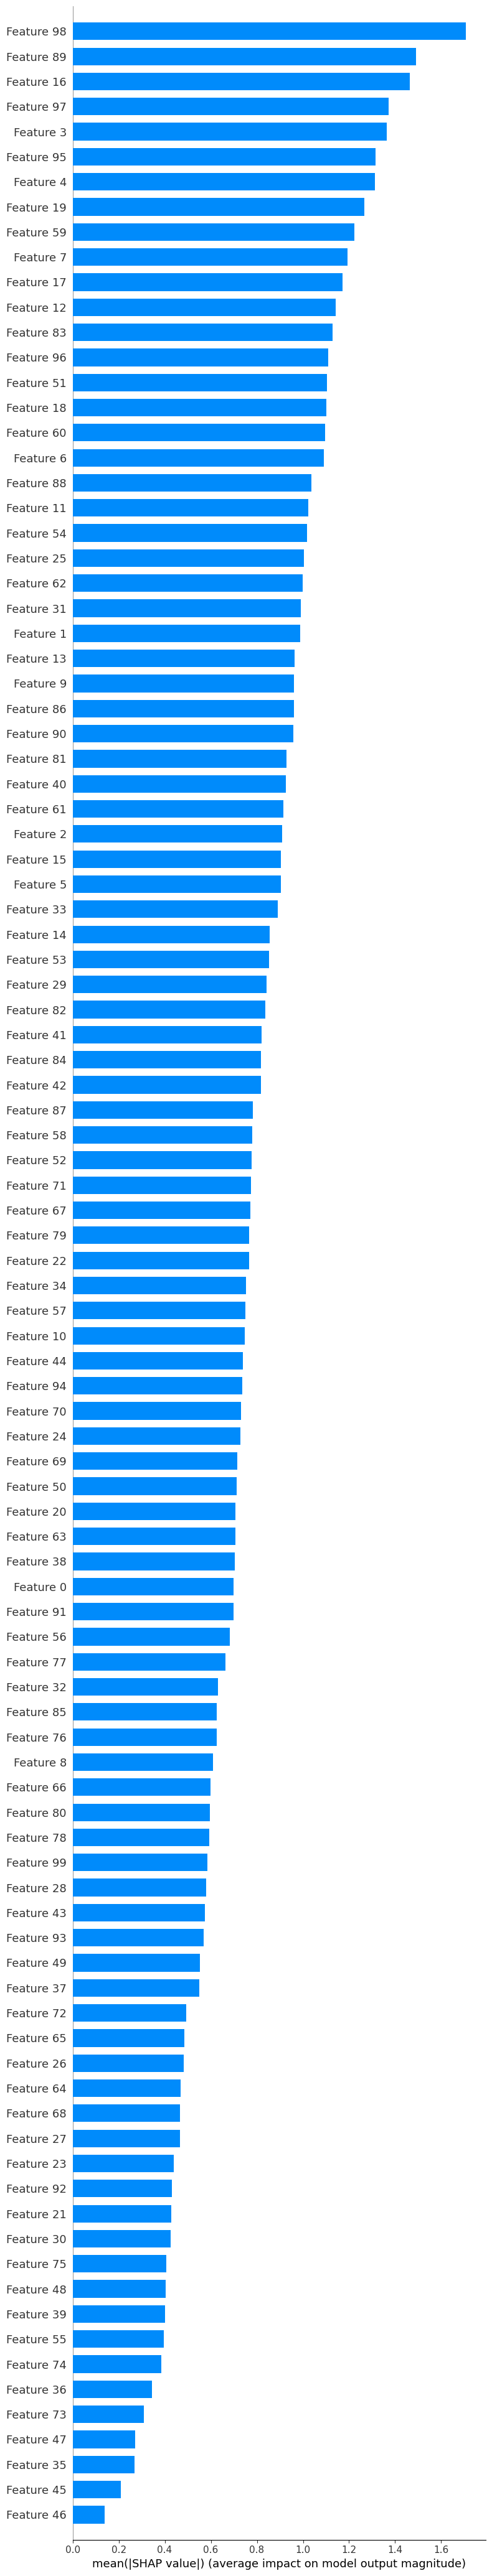

shap values for class 2 :


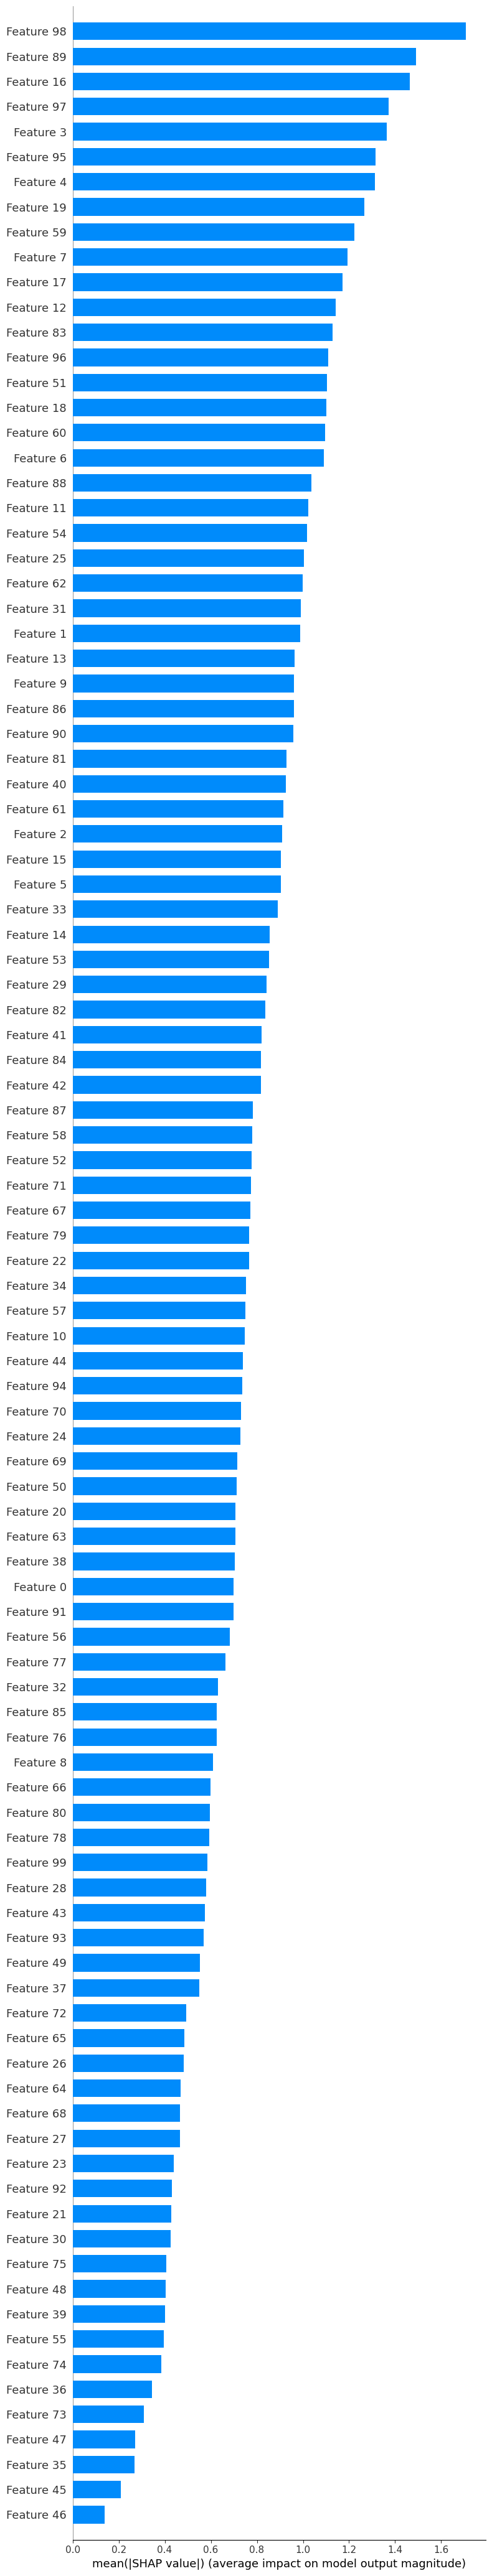

In [ ]:
shapForPeriod(model.cpu() , 0 , 125 , 0 , 125 ,featureNames ,  Features = False  )

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



shap values for class 1 :


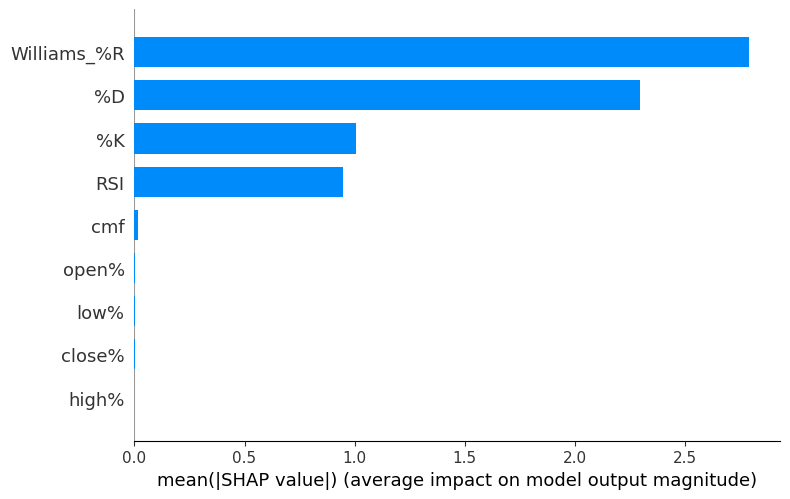

shap values for class 2 :


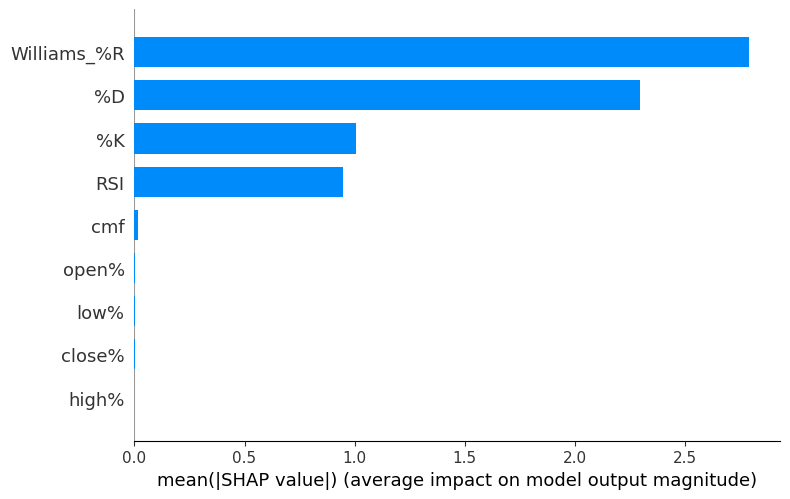

In [ ]:
shapForPeriod(model.cpu() , 0 , 125 , 0 , 125 ,featureNames ,  Features = True  )

## hyperparameter tuning

In [39]:
# create logger with 'model5'
logger = logging.getLogger('model2')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('model2.log')
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s : %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

In [ ]:
batch_size = 16

In [ ]:
mlflow.set_experiment("model2")
listModels = []
listLearningRates = [ 0.000005 , 0.00001 , 0.0001  , 0.0002 , 0.0005 , 0.001 , 0.003 , 0.008   ] 
for learningRate in listLearningRates:

    model = IntegerTransformer2(num_embeddings=window_size, embedding_dim=9, num_heads=4, num_layers=2)

    train_model(model, logger, mlflow , lr = learningRate)

    listModels.append(model)


Epoch 1/100, Loss: 0.6969 Accuracy: 0.5149 F1_Macro: 0.5148 F1_micro: 0.5149
#######################################
 val evaliation : 


INFO:model2:Epoch [1/100], false_positive_rate: 0.3204, false_negative_rate: 0.5838, true_negative_rate: 0.6796, false_discovery_rate: 0.4253, recall: 0.4162, precision: 0.5747, accuracy: 0.5453, cohen_kappa: 0.0952, matthews_corr: 0.0992


Accuracy: 0.5453
false_positive_rate :  0.3204387990762125
false_negative_rate :  0.5837957824639289
true_negative_rate :  0.6795612009237876
false_discovery_rate :  0.42528735632183906
recall :  0.416204217536071
precision :  0.5747126436781609
acc :  0.5452744765138653
cohen_kappa :  0.09523463585154379
matthews_corr :  0.09919727860254984
#######################################
Epoch 2/100, Loss: 0.6844 Accuracy: 0.5544 F1_Macro: 0.5543 F1_micro: 0.5544
Epoch 3/100, Loss: 0.6769 Accuracy: 0.5788 F1_Macro: 0.5788 F1_micro: 0.5788
Epoch 4/100, Loss: 0.6700 Accuracy: 0.5962 F1_Macro: 0.5962 F1_micro: 0.5962
Epoch 5/100, Loss: 0.6630 Accuracy: 0.6092 F1_Macro: 0.6092 F1_micro: 0.6092
Epoch 6/100, Loss: 0.6559 Accuracy: 0.6231 F1_Macro: 0.6231 F1_micro: 0.6231
Epoch 7/100, Loss: 0.6488 Accuracy: 0.6347 F1_Macro: 0.6347 F1_micro: 0.6347
Epoch 8/100, Loss: 0.6417 Accuracy: 0.6463 F1_Macro: 0.6463 F1_micro: 0.6463
Epoch 9/100, Loss: 0.6348 Accuracy: 0.6559 F1_Macro: 0.6559 F1_micro: 0.6559


INFO:model2:Epoch [21/100], false_positive_rate: 0.3915, false_negative_rate: 0.4046, true_negative_rate: 0.6085, false_discovery_rate: 0.3872, recall: 0.5954, precision: 0.6128, accuracy: 0.6019, cohen_kappa: 0.2039, matthews_corr: 0.2040


Accuracy: 0.6019
false_positive_rate :  0.39145496535796764
false_negative_rate :  0.40455049944506105
true_negative_rate :  0.6085450346420324
false_discovery_rate :  0.38720731010850945
recall :  0.595449500554939
precision :  0.6127926898914906
acc :  0.6018675721561969
cohen_kappa :  0.20387793325902082
matthews_corr :  0.20396287537066868
#######################################
Epoch 22/100, Loss: 0.5620 Accuracy: 0.7435 F1_Macro: 0.7435 F1_micro: 0.7435
Epoch 23/100, Loss: 0.5575 Accuracy: 0.7483 F1_Macro: 0.7483 F1_micro: 0.7483
Epoch 24/100, Loss: 0.5532 Accuracy: 0.7536 F1_Macro: 0.7536 F1_micro: 0.7536
Epoch 25/100, Loss: 0.5489 Accuracy: 0.7598 F1_Macro: 0.7598 F1_micro: 0.7598
Epoch 26/100, Loss: 0.5447 Accuracy: 0.7655 F1_Macro: 0.7655 F1_micro: 0.7655
Epoch 27/100, Loss: 0.5406 Accuracy: 0.7706 F1_Macro: 0.7706 F1_micro: 0.7706
Epoch 28/100, Loss: 0.5365 Accuracy: 0.7745 F1_Macro: 0.7745 F1_micro: 0.7745
Epoch 29/100, Loss: 0.5325 Accuracy: 0.7790 F1_Macro: 0.7790 F1_micr

INFO:model2:Epoch [41/100], false_positive_rate: 0.4267, false_negative_rate: 0.3413, true_negative_rate: 0.5733, false_discovery_rate: 0.3837, recall: 0.6587, precision: 0.6163, accuracy: 0.6169, cohen_kappa: 0.2324, matthews_corr: 0.2329


Accuracy: 0.6169
false_positive_rate :  0.4266743648960739
false_negative_rate :  0.34128745837957825
true_negative_rate :  0.5733256351039261
false_discovery_rate :  0.3836967808930426
recall :  0.6587125416204217
precision :  0.6163032191069574
acc :  0.6168647425014149
cohen_kappa :  0.2323612870437035
matthews_corr :  0.23293761142156533
#######################################
Epoch 42/100, Loss: 0.4880 Accuracy: 0.8291 F1_Macro: 0.8291 F1_micro: 0.8291
Epoch 43/100, Loss: 0.4850 Accuracy: 0.8324 F1_Macro: 0.8324 F1_micro: 0.8324
Epoch 44/100, Loss: 0.4820 Accuracy: 0.8353 F1_Macro: 0.8353 F1_micro: 0.8353
Epoch 45/100, Loss: 0.4791 Accuracy: 0.8385 F1_Macro: 0.8385 F1_micro: 0.8385
Epoch 46/100, Loss: 0.4762 Accuracy: 0.8420 F1_Macro: 0.8420 F1_micro: 0.8420
Epoch 47/100, Loss: 0.4734 Accuracy: 0.8453 F1_Macro: 0.8453 F1_micro: 0.8453
Epoch 48/100, Loss: 0.4706 Accuracy: 0.8476 F1_Macro: 0.8476 F1_micro: 0.8476
Epoch 49/100, Loss: 0.4678 Accuracy: 0.8500 F1_Macro: 0.8500 F1_micro:

INFO:model2:Epoch [61/100], false_positive_rate: 0.4296, false_negative_rate: 0.3513, true_negative_rate: 0.5704, false_discovery_rate: 0.3889, recall: 0.6487, precision: 0.6111, accuracy: 0.6104, cohen_kappa: 0.2194, matthews_corr: 0.2199


Accuracy: 0.6104
false_positive_rate :  0.4295612009237875
false_negative_rate :  0.35127635960044395
true_negative_rate :  0.5704387990762124
false_discovery_rate :  0.3889179299529535
recall :  0.6487236403995561
precision :  0.6110820700470465
acc :  0.6103565365025467
cohen_kappa :  0.21943558582936684
matthews_corr :  0.21987126273600374
#######################################
Epoch 62/100, Loss: 0.4332 Accuracy: 0.8867 F1_Macro: 0.8867 F1_micro: 0.8867
Epoch 63/100, Loss: 0.4314 Accuracy: 0.8883 F1_Macro: 0.8883 F1_micro: 0.8883
Epoch 64/100, Loss: 0.4292 Accuracy: 0.8909 F1_Macro: 0.8909 F1_micro: 0.8909
Epoch 65/100, Loss: 0.4277 Accuracy: 0.8921 F1_Macro: 0.8921 F1_micro: 0.8921
Epoch 66/100, Loss: 0.4274 Accuracy: 0.8907 F1_Macro: 0.8907 F1_micro: 0.8907
Epoch 67/100, Loss: 0.4248 Accuracy: 0.8934 F1_Macro: 0.8934 F1_micro: 0.8934
Epoch 68/100, Loss: 0.4221 Accuracy: 0.8967 F1_Macro: 0.8967 F1_micro: 0.8967
Epoch 69/100, Loss: 0.4202 Accuracy: 0.8987 F1_Macro: 0.8987 F1_micro

INFO:model2:Epoch [81/100], false_positive_rate: 0.3868, false_negative_rate: 0.3968, true_negative_rate: 0.6132, false_discovery_rate: 0.3813, recall: 0.6032, precision: 0.6187, accuracy: 0.6081, cohen_kappa: 0.2163, matthews_corr: 0.2163


Accuracy: 0.6081
false_positive_rate :  0.38683602771362585
false_negative_rate :  0.39678135405105436
true_negative_rate :  0.6131639722863741
false_discovery_rate :  0.3813318155947638
recall :  0.6032186459489456
precision :  0.6186681844052362
acc :  0.6080928126768534
cohen_kappa :  0.21627347893880788
matthews_corr :  0.21634363078485927
#######################################
Epoch 82/100, Loss: 0.4066 Accuracy: 0.9103 F1_Macro: 0.9103 F1_micro: 0.9103
Epoch 83/100, Loss: 0.4079 Accuracy: 0.9082 F1_Macro: 0.9082 F1_micro: 0.9082
Epoch 84/100, Loss: 0.4051 Accuracy: 0.9110 F1_Macro: 0.9110 F1_micro: 0.9110
Epoch 85/100, Loss: 0.4039 Accuracy: 0.9124 F1_Macro: 0.9124 F1_micro: 0.9124
Epoch 86/100, Loss: 0.4028 Accuracy: 0.9137 F1_Macro: 0.9137 F1_micro: 0.9137
Epoch 87/100, Loss: 0.4040 Accuracy: 0.9119 F1_Macro: 0.9119 F1_micro: 0.9119
Epoch 88/100, Loss: 0.4051 Accuracy: 0.9108 F1_Macro: 0.9108 F1_micro: 0.9108
Epoch 89/100, Loss: 0.4019 Accuracy: 0.9145 F1_Macro: 0.9145 F1_micr

INFO:model2:Epoch [1/100], false_positive_rate: 0.3170, false_negative_rate: 0.5699, true_negative_rate: 0.6830, false_discovery_rate: 0.4147, recall: 0.4301, precision: 0.5853, accuracy: 0.5540, cohen_kappa: 0.1125, matthews_corr: 0.1168


Accuracy: 0.5540
false_positive_rate :  0.3169745958429561
false_negative_rate :  0.56992230854606
true_negative_rate :  0.6830254041570438
false_discovery_rate :  0.41465256797583083
recall :  0.4300776914539401
precision :  0.5853474320241692
acc :  0.5540464063384267
cohen_kappa :  0.11250005577166644
matthews_corr :  0.11681152651653076
#######################################
Epoch 2/100, Loss: 0.6793 Accuracy: 0.5705 F1_Macro: 0.5705 F1_micro: 0.5705
Epoch 3/100, Loss: 0.6670 Accuracy: 0.5958 F1_Macro: 0.5958 F1_micro: 0.5958
Epoch 4/100, Loss: 0.6543 Accuracy: 0.6204 F1_Macro: 0.6204 F1_micro: 0.6204
Epoch 5/100, Loss: 0.6410 Accuracy: 0.6406 F1_Macro: 0.6406 F1_micro: 0.6406
Epoch 6/100, Loss: 0.6279 Accuracy: 0.6602 F1_Macro: 0.6602 F1_micro: 0.6602
Epoch 7/100, Loss: 0.6154 Accuracy: 0.6766 F1_Macro: 0.6766 F1_micro: 0.6766
Epoch 8/100, Loss: 0.6038 Accuracy: 0.6913 F1_Macro: 0.6913 F1_micro: 0.6913
Epoch 9/100, Loss: 0.5930 Accuracy: 0.7064 F1_Macro: 0.7064 F1_micro: 0.7064
E

INFO:model2:Epoch [21/100], false_positive_rate: 0.3961, false_negative_rate: 0.3729, true_negative_rate: 0.6039, false_discovery_rate: 0.3778, recall: 0.6271, precision: 0.6222, accuracy: 0.6157, cohen_kappa: 0.2310, matthews_corr: 0.2311


Accuracy: 0.6157
false_positive_rate :  0.3960739030023095
false_negative_rate :  0.3729189789123196
true_negative_rate :  0.6039260969976905
false_discovery_rate :  0.3777533039647577
recall :  0.6270810210876804
precision :  0.6222466960352423
acc :  0.6157328805885682
cohen_kappa :  0.23104339137607377
matthews_corr :  0.23105065150317794
#######################################
Epoch 22/100, Loss: 0.4840 Accuracy: 0.8317 F1_Macro: 0.8317 F1_micro: 0.8317
Epoch 23/100, Loss: 0.4768 Accuracy: 0.8402 F1_Macro: 0.8402 F1_micro: 0.8402
Epoch 24/100, Loss: 0.4698 Accuracy: 0.8492 F1_Macro: 0.8492 F1_micro: 0.8492
Epoch 25/100, Loss: 0.4632 Accuracy: 0.8562 F1_Macro: 0.8562 F1_micro: 0.8562
Epoch 26/100, Loss: 0.4570 Accuracy: 0.8616 F1_Macro: 0.8616 F1_micro: 0.8616
Epoch 27/100, Loss: 0.4507 Accuracy: 0.8676 F1_Macro: 0.8676 F1_micro: 0.8676
Epoch 28/100, Loss: 0.4455 Accuracy: 0.8728 F1_Macro: 0.8728 F1_micro: 0.8728
Epoch 29/100, Loss: 0.4398 Accuracy: 0.8785 F1_Macro: 0.8785 F1_micro:

INFO:model2:Epoch [41/100], false_positive_rate: 0.3568, false_negative_rate: 0.4001, true_negative_rate: 0.6432, false_discovery_rate: 0.3637, recall: 0.5999, precision: 0.6363, accuracy: 0.6211, cohen_kappa: 0.2428, matthews_corr: 0.2432


Accuracy: 0.6211
false_positive_rate :  0.3568129330254042
false_negative_rate :  0.40011098779134296
true_negative_rate :  0.6431870669745958
false_discovery_rate :  0.36374337845791643
recall :  0.5998890122086571
precision :  0.6362566215420836
acc :  0.6211092246745897
cohen_kappa :  0.24279563691386186
matthews_corr :  0.24320854859909777
#######################################
Epoch 42/100, Loss: 0.4052 Accuracy: 0.9103 F1_Macro: 0.9103 F1_micro: 0.9103
Epoch 43/100, Loss: 0.4052 Accuracy: 0.9103 F1_Macro: 0.9103 F1_micro: 0.9103
Epoch 44/100, Loss: 0.4031 Accuracy: 0.9118 F1_Macro: 0.9118 F1_micro: 0.9118
Epoch 45/100, Loss: 0.4027 Accuracy: 0.9122 F1_Macro: 0.9122 F1_micro: 0.9122
Epoch 46/100, Loss: 0.4000 Accuracy: 0.9152 F1_Macro: 0.9152 F1_micro: 0.9152
Epoch 47/100, Loss: 0.4002 Accuracy: 0.9142 F1_Macro: 0.9142 F1_micro: 0.9142
Epoch 48/100, Loss: 0.3976 Accuracy: 0.9174 F1_Macro: 0.9174 F1_micro: 0.9174
Epoch 49/100, Loss: 0.3961 Accuracy: 0.9190 F1_Macro: 0.9190 F1_micr

INFO:model2:Epoch [61/100], false_positive_rate: 0.3926, false_negative_rate: 0.3812, true_negative_rate: 0.6074, false_discovery_rate: 0.3788, recall: 0.6188, precision: 0.6212, accuracy: 0.6132, cohen_kappa: 0.2261, matthews_corr: 0.2261


Accuracy: 0.6132
false_positive_rate :  0.39260969976905313
false_negative_rate :  0.3812430632630411
true_negative_rate :  0.6073903002309469
false_discovery_rate :  0.3788300835654596
recall :  0.618756936736959
precision :  0.6211699164345403
acc :  0.6131861912846632
cohen_kappa :  0.22612948605857353
matthews_corr :  0.2261312615883696
#######################################
Epoch 62/100, Loss: 0.3879 Accuracy: 0.9259 F1_Macro: 0.9259 F1_micro: 0.9259
Epoch 63/100, Loss: 0.3874 Accuracy: 0.9264 F1_Macro: 0.9264 F1_micro: 0.9264
Epoch 64/100, Loss: 0.3861 Accuracy: 0.9280 F1_Macro: 0.9280 F1_micro: 0.9280
Epoch 65/100, Loss: 0.3846 Accuracy: 0.9295 F1_Macro: 0.9295 F1_micro: 0.9295
Epoch 66/100, Loss: 0.3857 Accuracy: 0.9278 F1_Macro: 0.9278 F1_micro: 0.9278
Epoch 67/100, Loss: 0.3858 Accuracy: 0.9278 F1_Macro: 0.9278 F1_micro: 0.9278
Epoch 68/100, Loss: 0.3832 Accuracy: 0.9308 F1_Macro: 0.9308 F1_micro: 0.9308
Epoch 69/100, Loss: 0.3845 Accuracy: 0.9291 F1_Macro: 0.9291 F1_micro: 

INFO:model2:Epoch [81/100], false_positive_rate: 0.4359, false_negative_rate: 0.3740, true_negative_rate: 0.5641, false_discovery_rate: 0.4010, recall: 0.6260, precision: 0.5990, accuracy: 0.5956, cohen_kappa: 0.1902, matthews_corr: 0.1904


Accuracy: 0.5956
false_positive_rate :  0.4359122401847575
false_negative_rate :  0.37402885682574916
true_negative_rate :  0.5640877598152425
false_discovery_rate :  0.4009559214020181
recall :  0.6259711431742508
precision :  0.5990440785979819
acc :  0.5956423316355405
cohen_kappa :  0.19023169882648128
matthews_corr :  0.19043240785702323
#######################################
Epoch 82/100, Loss: 0.3782 Accuracy: 0.9353 F1_Macro: 0.9353 F1_micro: 0.9353
Epoch 83/100, Loss: 0.3811 Accuracy: 0.9326 F1_Macro: 0.9326 F1_micro: 0.9326
Epoch 84/100, Loss: 0.3783 Accuracy: 0.9351 F1_Macro: 0.9351 F1_micro: 0.9351
Epoch 85/100, Loss: 0.3788 Accuracy: 0.9347 F1_Macro: 0.9347 F1_micro: 0.9347
Epoch 86/100, Loss: 0.3780 Accuracy: 0.9356 F1_Macro: 0.9356 F1_micro: 0.9356
Epoch 87/100, Loss: 0.3784 Accuracy: 0.9349 F1_Macro: 0.9349 F1_micro: 0.9349
Epoch 88/100, Loss: 0.3769 Accuracy: 0.9365 F1_Macro: 0.9365 F1_micro: 0.9365
Epoch 89/100, Loss: 0.3764 Accuracy: 0.9371 F1_Macro: 0.9371 F1_micro

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2:Epoch [1/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 2/100, Loss: 0.6970 Accuracy: 0.5215 F1_Macro: 0.5214 F1_micro: 0.5215
Epoch 3/100, Loss: 0.6891 Accuracy: 0.5483 F1_Macro: 0.5483 F1_micro: 0.5483
Epoch 4/100, Loss: 0.6623 Accuracy: 0.6134 F1_Macro: 0.6128 F1_micro: 0.6134
Epoch 5/100, Loss: 0.6331 Accuracy: 0.6511 F1_Macro: 0.6507 F1_micro: 0.6511
Epoch 6/100, Loss: 0.6042 Accuracy: 0.6888 F1_Macro: 0.6887 F1_micro: 0.6888
Epoch 7/100, Loss: 0.5854 Accuracy: 0.7083 F1_Macro: 0.7081 F1_micro: 0.7083
Epoch 8/100, Loss: 0.5747 Accuracy: 0.7242 F1_Macro: 0.7242 F1_micro: 0.7242
Epoch 9/100, Loss: 0.5499 Accuracy: 0.7537 F1_Macro: 0.7537 F1_micro: 0.7537
Epoch 10/100, Loss: 0.5367 Accuracy: 0.7687 F1_Macro: 0.7687 F1_micro: 0.7687
Epoch 11/100, Loss: 0.5266 Accuracy: 0.7790 F

INFO:model2:Epoch [21/100], false_positive_rate: 0.2962, false_negative_rate: 0.4501, true_negative_rate: 0.7038, false_discovery_rate: 0.3411, recall: 0.5499, precision: 0.6589, accuracy: 0.6254, cohen_kappa: 0.2529, matthews_corr: 0.2566


Accuracy: 0.6254
false_positive_rate :  0.29618937644341803
false_negative_rate :  0.45005549389567145
true_negative_rate :  0.703810623556582
false_discovery_rate :  0.3410904255319149
recall :  0.5499445061043285
precision :  0.6589095744680851
acc :  0.6253537068477646
cohen_kappa :  0.2529099528851084
matthews_corr :  0.2565631212129418
#######################################
Epoch 22/100, Loss: 0.4666 Accuracy: 0.8428 F1_Macro: 0.8428 F1_micro: 0.8428
Epoch 23/100, Loss: 0.4675 Accuracy: 0.8424 F1_Macro: 0.8424 F1_micro: 0.8424
Epoch 24/100, Loss: 0.4654 Accuracy: 0.8447 F1_Macro: 0.8447 F1_micro: 0.8447
Epoch 25/100, Loss: 0.4583 Accuracy: 0.8525 F1_Macro: 0.8525 F1_micro: 0.8525
Epoch 26/100, Loss: 0.4582 Accuracy: 0.8515 F1_Macro: 0.8515 F1_micro: 0.8515
Epoch 27/100, Loss: 0.4577 Accuracy: 0.8526 F1_Macro: 0.8526 F1_micro: 0.8526
Epoch 28/100, Loss: 0.4517 Accuracy: 0.8588 F1_Macro: 0.8588 F1_micro: 0.8588
Epoch 29/100, Loss: 0.4478 Accuracy: 0.8630 F1_Macro: 0.8630 F1_micro: 

INFO:model2:Epoch [41/100], false_positive_rate: 0.4342, false_negative_rate: 0.3152, true_negative_rate: 0.5658, false_discovery_rate: 0.3787, recall: 0.6848, precision: 0.6213, accuracy: 0.6265, cohen_kappa: 0.2511, matthews_corr: 0.2525


Accuracy: 0.6265
false_positive_rate :  0.4341801385681293
false_negative_rate :  0.31520532741398444
true_negative_rate :  0.5658198614318707
false_discovery_rate :  0.37865055387714
recall :  0.6847946725860156
precision :  0.62134944612286
acc :  0.6264855687606112
cohen_kappa :  0.251132720996178
matthews_corr :  0.25251227260921394
#######################################
Epoch 42/100, Loss: 0.4236 Accuracy: 0.8877 F1_Macro: 0.8877 F1_micro: 0.8877
Epoch 43/100, Loss: 0.4273 Accuracy: 0.8837 F1_Macro: 0.8837 F1_micro: 0.8837
Epoch 44/100, Loss: 0.4209 Accuracy: 0.8906 F1_Macro: 0.8906 F1_micro: 0.8906
Epoch 45/100, Loss: 0.4248 Accuracy: 0.8856 F1_Macro: 0.8856 F1_micro: 0.8856
Epoch 46/100, Loss: 0.4205 Accuracy: 0.8899 F1_Macro: 0.8899 F1_micro: 0.8899
Epoch 47/100, Loss: 0.4132 Accuracy: 0.8987 F1_Macro: 0.8986 F1_micro: 0.8987
Epoch 48/100, Loss: 0.4119 Accuracy: 0.8998 F1_Macro: 0.8998 F1_micro: 0.8998
Epoch 49/100, Loss: 0.4151 Accuracy: 0.8953 F1_Macro: 0.8953 F1_micro: 0.89

INFO:model2:Epoch [61/100], false_positive_rate: 0.4469, false_negative_rate: 0.3690, true_negative_rate: 0.5531, false_discovery_rate: 0.4050, recall: 0.6310, precision: 0.5950, accuracy: 0.5928, cohen_kappa: 0.1843, matthews_corr: 0.1847


Accuracy: 0.5928
false_positive_rate :  0.4468822170900693
false_negative_rate :  0.3690344062153163
true_negative_rate :  0.5531177829099307
false_discovery_rate :  0.4050235478806907
recall :  0.6309655937846836
precision :  0.5949764521193093
acc :  0.5928126768534239
cohen_kappa :  0.18430866446664984
matthews_corr :  0.1846614773981763
#######################################
Epoch 62/100, Loss: 0.3988 Accuracy: 0.9128 F1_Macro: 0.9128 F1_micro: 0.9128
Epoch 63/100, Loss: 0.3976 Accuracy: 0.9142 F1_Macro: 0.9142 F1_micro: 0.9142
Epoch 64/100, Loss: 0.3953 Accuracy: 0.9166 F1_Macro: 0.9166 F1_micro: 0.9166
Epoch 65/100, Loss: 0.3936 Accuracy: 0.9185 F1_Macro: 0.9185 F1_micro: 0.9185
Epoch 66/100, Loss: 0.3978 Accuracy: 0.9137 F1_Macro: 0.9137 F1_micro: 0.9137
Epoch 67/100, Loss: 0.3936 Accuracy: 0.9188 F1_Macro: 0.9188 F1_micro: 0.9188
Epoch 68/100, Loss: 0.3944 Accuracy: 0.9171 F1_Macro: 0.9171 F1_micro: 0.9171
Epoch 69/100, Loss: 0.3901 Accuracy: 0.9215 F1_Macro: 0.9215 F1_micro: 

INFO:model2:Epoch [81/100], false_positive_rate: 0.4908, false_negative_rate: 0.2664, true_negative_rate: 0.5092, false_discovery_rate: 0.3913, recall: 0.7336, precision: 0.6087, accuracy: 0.6237, cohen_kappa: 0.2439, matthews_corr: 0.2495


Accuracy: 0.6237
false_positive_rate :  0.4907621247113164
false_negative_rate :  0.2663706992230855
true_negative_rate :  0.5092378752886836
false_discovery_rate :  0.39134438305709024
recall :  0.7336293007769146
precision :  0.6086556169429097
acc :  0.6236559139784946
cohen_kappa :  0.24387908551616833
matthews_corr :  0.24946044688629732
#######################################
Epoch 82/100, Loss: 0.3808 Accuracy: 0.9312 F1_Macro: 0.9312 F1_micro: 0.9312
Epoch 83/100, Loss: 0.3802 Accuracy: 0.9320 F1_Macro: 0.9320 F1_micro: 0.9320
Epoch 84/100, Loss: 0.3828 Accuracy: 0.9298 F1_Macro: 0.9298 F1_micro: 0.9298
Epoch 85/100, Loss: 0.3816 Accuracy: 0.9302 F1_Macro: 0.9302 F1_micro: 0.9302
Epoch 86/100, Loss: 0.3794 Accuracy: 0.9334 F1_Macro: 0.9334 F1_micro: 0.9334
Epoch 87/100, Loss: 0.3817 Accuracy: 0.9304 F1_Macro: 0.9304 F1_micro: 0.9304
Epoch 88/100, Loss: 0.3786 Accuracy: 0.9341 F1_Macro: 0.9341 F1_micro: 0.9341
Epoch 89/100, Loss: 0.3817 Accuracy: 0.9303 F1_Macro: 0.9303 F1_micro

INFO:model2:Epoch [1/100], false_positive_rate: 0.2136, false_negative_rate: 0.6448, true_negative_rate: 0.7864, false_discovery_rate: 0.3663, recall: 0.3552, precision: 0.6337, accuracy: 0.5665, cohen_kappa: 0.1403, matthews_corr: 0.1566


Accuracy: 0.5665
false_positive_rate :  0.21362586605080833
false_negative_rate :  0.6448390677025527
true_negative_rate :  0.7863741339491916
false_discovery_rate :  0.36633663366336633
recall :  0.3551609322974473
precision :  0.6336633663366337
acc :  0.5664968873797397
cohen_kappa :  0.14028907667213764
matthews_corr :  0.15660658794342033
#######################################
Epoch 2/100, Loss: 0.6576 Accuracy: 0.6165 F1_Macro: 0.6164 F1_micro: 0.6165
Epoch 3/100, Loss: 0.6187 Accuracy: 0.6697 F1_Macro: 0.6697 F1_micro: 0.6697
Epoch 4/100, Loss: 0.5868 Accuracy: 0.7119 F1_Macro: 0.7119 F1_micro: 0.7119
Epoch 5/100, Loss: 0.5725 Accuracy: 0.7322 F1_Macro: 0.7322 F1_micro: 0.7322
Epoch 6/100, Loss: 0.5754 Accuracy: 0.7263 F1_Macro: 0.7260 F1_micro: 0.7263
Epoch 7/100, Loss: 0.5518 Accuracy: 0.7515 F1_Macro: 0.7514 F1_micro: 0.7515
Epoch 8/100, Loss: 0.5427 Accuracy: 0.7631 F1_Macro: 0.7631 F1_micro: 0.7631
Epoch 9/100, Loss: 0.5347 Accuracy: 0.7701 F1_Macro: 0.7701 F1_micro: 0.770

INFO:model2:Epoch [21/100], false_positive_rate: 0.3920, false_negative_rate: 0.3363, true_negative_rate: 0.6080, false_discovery_rate: 0.3621, recall: 0.6637, precision: 0.6379, accuracy: 0.6364, cohen_kappa: 0.2719, matthews_corr: 0.2721


Accuracy: 0.6364
false_positive_rate :  0.3920323325635104
false_negative_rate :  0.3362930077691454
true_negative_rate :  0.6079676674364896
false_discovery_rate :  0.3621333333333333
recall :  0.6637069922308546
precision :  0.6378666666666667
acc :  0.6363893604980192
cohen_kappa :  0.2718972432017993
matthews_corr :  0.2721301366858192
#######################################
Epoch 22/100, Loss: 0.4759 Accuracy: 0.8330 F1_Macro: 0.8330 F1_micro: 0.8330
Epoch 23/100, Loss: 0.4754 Accuracy: 0.8316 F1_Macro: 0.8316 F1_micro: 0.8316
Epoch 24/100, Loss: 0.4784 Accuracy: 0.8303 F1_Macro: 0.8303 F1_micro: 0.8303
Epoch 25/100, Loss: 0.4755 Accuracy: 0.8332 F1_Macro: 0.8332 F1_micro: 0.8332
Epoch 26/100, Loss: 0.4687 Accuracy: 0.8414 F1_Macro: 0.8414 F1_micro: 0.8414
Epoch 27/100, Loss: 0.4637 Accuracy: 0.8455 F1_Macro: 0.8455 F1_micro: 0.8455
Epoch 28/100, Loss: 0.4667 Accuracy: 0.8435 F1_Macro: 0.8435 F1_micro: 0.8435
Epoch 29/100, Loss: 0.4666 Accuracy: 0.8441 F1_Macro: 0.8441 F1_micro: 0

INFO:model2:Epoch [41/100], false_positive_rate: 0.3724, false_negative_rate: 0.3280, true_negative_rate: 0.6276, false_discovery_rate: 0.3475, recall: 0.6720, precision: 0.6525, accuracy: 0.6503, cohen_kappa: 0.2998, matthews_corr: 0.3000


Accuracy: 0.6503
false_positive_rate :  0.37240184757505773
false_negative_rate :  0.327968923418424
true_negative_rate :  0.6275981524249422
false_discovery_rate :  0.34752155172413796
recall :  0.672031076581576
precision :  0.6524784482758621
acc :  0.6502546689303905
cohen_kappa :  0.2998107832394089
matthews_corr :  0.29995116271218575
#######################################
Epoch 42/100, Loss: 0.4429 Accuracy: 0.8675 F1_Macro: 0.8675 F1_micro: 0.8675
Epoch 43/100, Loss: 0.4439 Accuracy: 0.8652 F1_Macro: 0.8652 F1_micro: 0.8652
Epoch 44/100, Loss: 0.4358 Accuracy: 0.8752 F1_Macro: 0.8752 F1_micro: 0.8752
Epoch 45/100, Loss: 0.4390 Accuracy: 0.8706 F1_Macro: 0.8706 F1_micro: 0.8706
Epoch 46/100, Loss: 0.4313 Accuracy: 0.8800 F1_Macro: 0.8800 F1_micro: 0.8800
Epoch 47/100, Loss: 0.4556 Accuracy: 0.8542 F1_Macro: 0.8542 F1_micro: 0.8542
Epoch 48/100, Loss: 0.4412 Accuracy: 0.8689 F1_Macro: 0.8689 F1_micro: 0.8689
Epoch 49/100, Loss: 0.4366 Accuracy: 0.8740 F1_Macro: 0.8740 F1_micro: 

INFO:model2:Epoch [61/100], false_positive_rate: 0.4065, false_negative_rate: 0.3124, true_negative_rate: 0.5935, false_discovery_rate: 0.3623, recall: 0.6876, precision: 0.6377, accuracy: 0.6415, cohen_kappa: 0.2815, matthews_corr: 0.2825


Accuracy: 0.6415
false_positive_rate :  0.4064665127020785
false_negative_rate :  0.31243063263041065
true_negative_rate :  0.5935334872979214
false_discovery_rate :  0.3623262995367988
recall :  0.6875693673695893
precision :  0.6376737004632013
acc :  0.6414827391058291
cohen_kappa :  0.28154803604086986
matthews_corr :  0.2824522918714378
#######################################
Epoch 62/100, Loss: 0.4191 Accuracy: 0.8920 F1_Macro: 0.8920 F1_micro: 0.8920
Epoch 63/100, Loss: 0.4155 Accuracy: 0.8953 F1_Macro: 0.8953 F1_micro: 0.8953
Epoch 64/100, Loss: 0.4231 Accuracy: 0.8869 F1_Macro: 0.8869 F1_micro: 0.8869
Epoch 65/100, Loss: 0.4233 Accuracy: 0.8879 F1_Macro: 0.8879 F1_micro: 0.8879
Epoch 66/100, Loss: 0.4185 Accuracy: 0.8915 F1_Macro: 0.8915 F1_micro: 0.8915
Epoch 67/100, Loss: 0.4128 Accuracy: 0.8989 F1_Macro: 0.8989 F1_micro: 0.8989
Epoch 68/100, Loss: 0.4131 Accuracy: 0.8979 F1_Macro: 0.8979 F1_micro: 0.8979
Epoch 69/100, Loss: 0.4124 Accuracy: 0.8983 F1_Macro: 0.8983 F1_micro:

INFO:model2:Epoch [81/100], false_positive_rate: 0.4700, false_negative_rate: 0.2741, true_negative_rate: 0.5300, false_discovery_rate: 0.3836, recall: 0.7259, precision: 0.6164, accuracy: 0.6299, cohen_kappa: 0.2568, matthews_corr: 0.2612


Accuracy: 0.6299
false_positive_rate :  0.46997690531177827
false_negative_rate :  0.2741398446170921
true_negative_rate :  0.5300230946882217
false_discovery_rate :  0.3836003770028275
recall :  0.7258601553829079
precision :  0.6163996229971724
acc :  0.629881154499151
cohen_kappa :  0.2568047991809288
matthews_corr :  0.26115789369010556
#######################################
Epoch 82/100, Loss: 0.4051 Accuracy: 0.9060 F1_Macro: 0.9060 F1_micro: 0.9060
Epoch 83/100, Loss: 0.4035 Accuracy: 0.9078 F1_Macro: 0.9078 F1_micro: 0.9078
Epoch 84/100, Loss: 0.4043 Accuracy: 0.9067 F1_Macro: 0.9067 F1_micro: 0.9067
Epoch 85/100, Loss: 0.4031 Accuracy: 0.9084 F1_Macro: 0.9084 F1_micro: 0.9084
Epoch 86/100, Loss: 0.4074 Accuracy: 0.9035 F1_Macro: 0.9035 F1_micro: 0.9035
Epoch 87/100, Loss: 0.4079 Accuracy: 0.9024 F1_Macro: 0.9024 F1_micro: 0.9024
Epoch 88/100, Loss: 0.3969 Accuracy: 0.9149 F1_Macro: 0.9149 F1_micro: 0.9149
Epoch 89/100, Loss: 0.3980 Accuracy: 0.9134 F1_Macro: 0.9134 F1_micro: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2:Epoch [1/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 2/100, Loss: 0.6985 Accuracy: 0.5057 F1_Macro: 0.5037 F1_micro: 0.5057
Epoch 3/100, Loss: 0.6978 Accuracy: 0.4894 F1_Macro: 0.4878 F1_micro: 0.4894
Epoch 4/100, Loss: 0.6974 Accuracy: 0.4965 F1_Macro: 0.4946 F1_micro: 0.4965
Epoch 5/100, Loss: 0.6987 Accuracy: 0.4954 F1_Macro: 0.4939 F1_micro: 0.4954
Epoch 6/100, Loss: 0.6973 Accuracy: 0.5199 F1_Macro: 0.5192 F1_micro: 0.5199
Epoch 7/100, Loss: 0.6967 Accuracy: 0.4897 F1_Macro: 0.4895 F1_micro: 0.4897
Epoch 8/100, Loss: 0.6955 Accuracy: 0.5080 F1_Macro: 0.5080 F1_micro: 0.5080
Epoch 9/100, Loss: 0.6939 Accuracy: 0.5268 F1_Macro: 0.5267 F1_micro: 0.5268
Epoch 10/100, Loss: 0.6913 Accuracy: 0.5422 F1_Macro: 0.5417 F1_micro: 0.5422
Epoch 11/100, Loss: 0.6877 Accuracy: 0.5553 F

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2:Epoch [21/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 22/100, Loss: 0.6942 Accuracy: 0.4808 F1_Macro: 0.4377 F1_micro: 0.4808
Epoch 23/100, Loss: 0.6944 Accuracy: 0.4792 F1_Macro: 0.4634 F1_micro: 0.4792
Epoch 24/100, Loss: 0.6948 Accuracy: 0.4908 F1_Macro: 0.4648 F1_micro: 0.4908
Epoch 25/100, Loss: 0.6953 Accuracy: 0.5043 F1_Macro: 0.4867 F1_micro: 0.5043
Epoch 26/100, Loss: 0.6942 Accuracy: 0.4858 F1_Macro: 0.4251 F1_micro: 0.4858
Epoch 27/100, Loss: 0.6939 Accuracy: 0.4945 F1_Macro: 0.4133 F1_micro: 0.4945
Epoch 28/100, Loss: 0.6944 Accuracy: 0.5027 F1_Macro: 0.4671 F1_micro: 0.5027
Epoch 29/100, Loss: 0.6939 Accuracy: 0.4897 F1_Macro: 0.4186 F1_micro: 0.4897
Epoch 30/100, Loss: 0.6945 Accuracy: 0.4987 F1_Macro: 0.4770 F1_micro: 0.4987
Epoch 31/100, Loss: 0.6933 Accuracy: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2:Epoch [41/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 42/100, Loss: 0.6935 Accuracy: 0.4861 F1_Macro: 0.4327 F1_micro: 0.4861
Epoch 43/100, Loss: 0.6934 Accuracy: 0.4872 F1_Macro: 0.4232 F1_micro: 0.4872
Epoch 44/100, Loss: 0.6935 Accuracy: 0.4891 F1_Macro: 0.4676 F1_micro: 0.4891
Epoch 45/100, Loss: 0.6934 Accuracy: 0.4815 F1_Macro: 0.4705 F1_micro: 0.4815
Epoch 46/100, Loss: 0.6931 Accuracy: 0.4815 F1_Macro: 0.4732 F1_micro: 0.4815
Epoch 47/100, Loss: 0.6939 Accuracy: 0.4933 F1_Macro: 0.4905 F1_micro: 0.4933
Epoch 48/100, Loss: 0.6935 Accuracy: 0.4801 F1_Macro: 0.4644 F1_micro: 0.4801
Epoch 49/100, Loss: 0.6930 Accuracy: 0.4878 F1_Macro: 0.4460 F1_micro: 0.4878
Epoch 50/100, Loss: 0.6928 Accuracy: 0.4878 F1_Macro: 0.4350 F1_micro: 0.4878
Epoch 51/100, Loss: 0.6942 Accuracy: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2:Epoch [61/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 62/100, Loss: 0.6911 Accuracy: 0.5004 F1_Macro: 0.4557 F1_micro: 0.5004
Epoch 63/100, Loss: 0.6911 Accuracy: 0.4974 F1_Macro: 0.4548 F1_micro: 0.4974
Epoch 64/100, Loss: 0.6910 Accuracy: 0.5001 F1_Macro: 0.4541 F1_micro: 0.5001
Epoch 65/100, Loss: 0.6911 Accuracy: 0.4977 F1_Macro: 0.4567 F1_micro: 0.4977
Epoch 66/100, Loss: 0.6910 Accuracy: 0.4966 F1_Macro: 0.4516 F1_micro: 0.4966
Epoch 67/100, Loss: 0.6911 Accuracy: 0.4982 F1_Macro: 0.4590 F1_micro: 0.4982
Epoch 68/100, Loss: 0.6912 Accuracy: 0.5022 F1_Macro: 0.4346 F1_micro: 0.5022
Epoch 69/100, Loss: 0.6916 Accuracy: 0.5060 F1_Macro: 0.3942 F1_micro: 0.5060
Epoch 70/100, Loss: 0.6922 Accuracy: 0.4943 F1_Macro: 0.4159 F1_micro: 0.4943
Epoch 71/100, Loss: 0.6912 Accuracy: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2:Epoch [81/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 82/100, Loss: 0.6908 Accuracy: 0.4976 F1_Macro: 0.4352 F1_micro: 0.4976
Epoch 83/100, Loss: 0.6917 Accuracy: 0.4995 F1_Macro: 0.4737 F1_micro: 0.4995
Epoch 84/100, Loss: 0.6912 Accuracy: 0.4949 F1_Macro: 0.4564 F1_micro: 0.4949
Epoch 85/100, Loss: 0.6910 Accuracy: 0.5022 F1_Macro: 0.4167 F1_micro: 0.5022
Epoch 86/100, Loss: 0.6910 Accuracy: 0.4971 F1_Macro: 0.4371 F1_micro: 0.4971
Epoch 87/100, Loss: 0.6910 Accuracy: 0.4973 F1_Macro: 0.4443 F1_micro: 0.4973
Epoch 88/100, Loss: 0.6907 Accuracy: 0.4977 F1_Macro: 0.4140 F1_micro: 0.4977
Epoch 89/100, Loss: 0.6913 Accuracy: 0.4970 F1_Macro: 0.4346 F1_micro: 0.4970
Epoch 90/100, Loss: 0.6914 Accuracy: 0.4919 F1_Macro: 0.4423 F1_micro: 0.4919
Epoch 91/100, Loss: 0.6914 Accuracy: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2:Epoch [1/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 2/100, Loss: 0.6979 Accuracy: 0.5027 F1_Macro: 0.5016 F1_micro: 0.5027
Epoch 3/100, Loss: 0.6994 Accuracy: 0.4922 F1_Macro: 0.4907 F1_micro: 0.4922
Epoch 4/100, Loss: 0.6957 Accuracy: 0.4911 F1_Macro: 0.4900 F1_micro: 0.4911
Epoch 5/100, Loss: 0.6962 Accuracy: 0.4980 F1_Macro: 0.4966 F1_micro: 0.4980
Epoch 6/100, Loss: 0.6948 Accuracy: 0.4908 F1_Macro: 0.4823 F1_micro: 0.4908
Epoch 7/100, Loss: 0.6966 Accuracy: 0.4998 F1_Macro: 0.4625 F1_micro: 0.4998
Epoch 8/100, Loss: 0.6943 Accuracy: 0.4871 F1_Macro: 0.4685 F1_micro: 0.4871
Epoch 9/100, Loss: 0.6949 Accuracy: 0.4812 F1_Macro: 0.4629 F1_micro: 0.4812
Epoch 10/100, Loss: 0.6951 Accuracy: 0.4911 F1_Macro: 0.4647 F1_micro: 0.4911
Epoch 11/100, Loss: 0.6948 Accuracy: 0.4769 F

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2:Epoch [21/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 22/100, Loss: 0.6955 Accuracy: 0.4795 F1_Macro: 0.4718 F1_micro: 0.4795
Epoch 23/100, Loss: 0.6953 Accuracy: 0.4934 F1_Macro: 0.4896 F1_micro: 0.4934
Epoch 24/100, Loss: 0.6945 Accuracy: 0.4819 F1_Macro: 0.4672 F1_micro: 0.4819
Epoch 25/100, Loss: 0.6954 Accuracy: 0.4872 F1_Macro: 0.4836 F1_micro: 0.4872
Epoch 26/100, Loss: 0.6950 Accuracy: 0.4902 F1_Macro: 0.4694 F1_micro: 0.4902
Epoch 27/100, Loss: 0.6953 Accuracy: 0.4955 F1_Macro: 0.4650 F1_micro: 0.4955
Epoch 28/100, Loss: 0.6954 Accuracy: 0.4897 F1_Macro: 0.4667 F1_micro: 0.4897
Epoch 29/100, Loss: 0.6953 Accuracy: 0.4910 F1_Macro: 0.4692 F1_micro: 0.4910
Epoch 30/100, Loss: 0.6951 Accuracy: 0.4925 F1_Macro: 0.4607 F1_micro: 0.4925
Epoch 31/100, Loss: 0.6941 Accuracy: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2:Epoch [41/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 42/100, Loss: 0.6947 Accuracy: 0.4881 F1_Macro: 0.4597 F1_micro: 0.4881
Epoch 43/100, Loss: 0.6944 Accuracy: 0.4859 F1_Macro: 0.4449 F1_micro: 0.4859
Epoch 44/100, Loss: 0.6944 Accuracy: 0.4877 F1_Macro: 0.4514 F1_micro: 0.4877
Epoch 45/100, Loss: 0.6942 Accuracy: 0.4864 F1_Macro: 0.4542 F1_micro: 0.4864
Epoch 46/100, Loss: 0.6945 Accuracy: 0.4846 F1_Macro: 0.4542 F1_micro: 0.4846
Epoch 47/100, Loss: 0.6944 Accuracy: 0.4833 F1_Macro: 0.4694 F1_micro: 0.4833
Epoch 48/100, Loss: 0.6946 Accuracy: 0.4857 F1_Macro: 0.4745 F1_micro: 0.4857
Epoch 49/100, Loss: 0.6945 Accuracy: 0.4848 F1_Macro: 0.4686 F1_micro: 0.4848
Epoch 50/100, Loss: 0.6943 Accuracy: 0.4904 F1_Macro: 0.4679 F1_micro: 0.4904
Epoch 51/100, Loss: 0.6945 Accuracy: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2:Epoch [61/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 62/100, Loss: 0.6942 Accuracy: 0.4835 F1_Macro: 0.4800 F1_micro: 0.4835
Epoch 63/100, Loss: 0.6945 Accuracy: 0.4822 F1_Macro: 0.4809 F1_micro: 0.4822
Epoch 64/100, Loss: 0.6939 Accuracy: 0.4855 F1_Macro: 0.4695 F1_micro: 0.4855
Epoch 65/100, Loss: 0.6944 Accuracy: 0.4792 F1_Macro: 0.4639 F1_micro: 0.4792
Epoch 66/100, Loss: 0.6944 Accuracy: 0.4847 F1_Macro: 0.4771 F1_micro: 0.4847
Epoch 67/100, Loss: 0.6941 Accuracy: 0.4804 F1_Macro: 0.4609 F1_micro: 0.4804
Epoch 68/100, Loss: 0.6942 Accuracy: 0.4835 F1_Macro: 0.4667 F1_micro: 0.4835
Epoch 69/100, Loss: 0.6942 Accuracy: 0.4793 F1_Macro: 0.4676 F1_micro: 0.4793
Epoch 70/100, Loss: 0.6943 Accuracy: 0.4846 F1_Macro: 0.4770 F1_micro: 0.4846
Epoch 71/100, Loss: 0.6941 Accuracy: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2:Epoch [81/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 82/100, Loss: 0.6944 Accuracy: 0.4926 F1_Macro: 0.4870 F1_micro: 0.4926
Epoch 83/100, Loss: 0.6945 Accuracy: 0.4764 F1_Macro: 0.4749 F1_micro: 0.4764
Epoch 84/100, Loss: 0.6940 Accuracy: 0.4796 F1_Macro: 0.4761 F1_micro: 0.4796
Epoch 85/100, Loss: 0.6945 Accuracy: 0.4833 F1_Macro: 0.4808 F1_micro: 0.4833
Epoch 86/100, Loss: 0.6942 Accuracy: 0.4793 F1_Macro: 0.4786 F1_micro: 0.4793
Epoch 87/100, Loss: 0.6943 Accuracy: 0.4775 F1_Macro: 0.4751 F1_micro: 0.4775
Epoch 88/100, Loss: 0.6944 Accuracy: 0.4886 F1_Macro: 0.4838 F1_micro: 0.4886
Epoch 89/100, Loss: 0.6944 Accuracy: 0.4821 F1_Macro: 0.4527 F1_micro: 0.4821
Epoch 90/100, Loss: 0.6941 Accuracy: 0.4756 F1_Macro: 0.4528 F1_micro: 0.4756
Epoch 91/100, Loss: 0.6940 Accuracy: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2:Epoch [1/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 2/100, Loss: 0.6964 Accuracy: 0.5006 F1_Macro: 0.4901 F1_micro: 0.5006
Epoch 3/100, Loss: 0.6996 Accuracy: 0.4993 F1_Macro: 0.4992 F1_micro: 0.4993
Epoch 4/100, Loss: 0.7105 Accuracy: 0.5063 F1_Macro: 0.5054 F1_micro: 0.5063
Epoch 5/100, Loss: 0.7076 Accuracy: 0.5002 F1_Macro: 0.4987 F1_micro: 0.5002
Epoch 6/100, Loss: 0.6953 Accuracy: 0.4932 F1_Macro: 0.4914 F1_micro: 0.4932
Epoch 7/100, Loss: 0.7180 Accuracy: 0.5122 F1_Macro: 0.5120 F1_micro: 0.5122
Epoch 8/100, Loss: 0.6965 Accuracy: 0.4959 F1_Macro: 0.4842 F1_micro: 0.4959
Epoch 9/100, Loss: 0.6967 Accuracy: 0.4976 F1_Macro: 0.4950 F1_micro: 0.4976
Epoch 10/100, Loss: 0.7095 Accuracy: 0.5007 F1_Macro: 0.5007 F1_micro: 0.5007
Epoch 11/100, Loss: 0.6969 Accuracy: 0.4948 F

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2:Epoch [21/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 22/100, Loss: 0.6974 Accuracy: 0.4923 F1_Macro: 0.4923 F1_micro: 0.4923
Epoch 23/100, Loss: 0.6983 Accuracy: 0.4953 F1_Macro: 0.4940 F1_micro: 0.4953
Epoch 24/100, Loss: 0.6975 Accuracy: 0.4959 F1_Macro: 0.4958 F1_micro: 0.4959
Epoch 25/100, Loss: 0.6983 Accuracy: 0.4950 F1_Macro: 0.4943 F1_micro: 0.4950
Epoch 26/100, Loss: 0.6974 Accuracy: 0.4956 F1_Macro: 0.4952 F1_micro: 0.4956
Epoch 27/100, Loss: 0.6972 Accuracy: 0.4960 F1_Macro: 0.4958 F1_micro: 0.4960
Epoch 28/100, Loss: 0.6983 Accuracy: 0.4959 F1_Macro: 0.4955 F1_micro: 0.4959
Epoch 29/100, Loss: 0.6976 Accuracy: 0.4964 F1_Macro: 0.4961 F1_micro: 0.4964
Epoch 30/100, Loss: 0.6962 Accuracy: 0.4881 F1_Macro: 0.4880 F1_micro: 0.4881
Epoch 31/100, Loss: 0.6986 Accuracy: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2:Epoch [41/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 42/100, Loss: 0.6978 Accuracy: 0.4955 F1_Macro: 0.4951 F1_micro: 0.4955
Epoch 43/100, Loss: 0.6973 Accuracy: 0.4931 F1_Macro: 0.4919 F1_micro: 0.4931
Epoch 44/100, Loss: 0.6978 Accuracy: 0.4971 F1_Macro: 0.4970 F1_micro: 0.4971
Epoch 45/100, Loss: 0.6970 Accuracy: 0.4943 F1_Macro: 0.4943 F1_micro: 0.4943
Epoch 46/100, Loss: 0.6974 Accuracy: 0.4949 F1_Macro: 0.4949 F1_micro: 0.4949
Epoch 47/100, Loss: 0.6982 Accuracy: 0.4984 F1_Macro: 0.4981 F1_micro: 0.4984
Epoch 48/100, Loss: 0.6981 Accuracy: 0.4988 F1_Macro: 0.4985 F1_micro: 0.4988
Epoch 49/100, Loss: 0.6977 Accuracy: 0.4988 F1_Macro: 0.4987 F1_micro: 0.4988
Epoch 50/100, Loss: 0.6971 Accuracy: 0.4945 F1_Macro: 0.4934 F1_micro: 0.4945
Epoch 51/100, Loss: 0.6980 Accuracy: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2:Epoch [61/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 62/100, Loss: 0.6984 Accuracy: 0.4999 F1_Macro: 0.4999 F1_micro: 0.4999
Epoch 63/100, Loss: 0.6967 Accuracy: 0.4956 F1_Macro: 0.4948 F1_micro: 0.4956
Epoch 64/100, Loss: 0.6968 Accuracy: 0.4909 F1_Macro: 0.4903 F1_micro: 0.4909
Epoch 65/100, Loss: 0.7002 Accuracy: 0.4949 F1_Macro: 0.4946 F1_micro: 0.4949
Epoch 66/100, Loss: 0.6974 Accuracy: 0.4911 F1_Macro: 0.4898 F1_micro: 0.4911
Epoch 67/100, Loss: 0.6975 Accuracy: 0.4965 F1_Macro: 0.4965 F1_micro: 0.4965
Epoch 68/100, Loss: 0.6970 Accuracy: 0.4906 F1_Macro: 0.4902 F1_micro: 0.4906
Epoch 69/100, Loss: 0.6971 Accuracy: 0.4927 F1_Macro: 0.4927 F1_micro: 0.4927
Epoch 70/100, Loss: 0.6981 Accuracy: 0.4957 F1_Macro: 0.4949 F1_micro: 0.4957
Epoch 71/100, Loss: 0.6973 Accuracy: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2:Epoch [81/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 82/100, Loss: 0.6966 Accuracy: 0.4919 F1_Macro: 0.4911 F1_micro: 0.4919
Epoch 83/100, Loss: 0.6965 Accuracy: 0.4882 F1_Macro: 0.4875 F1_micro: 0.4882
Epoch 84/100, Loss: 0.6982 Accuracy: 0.4955 F1_Macro: 0.4955 F1_micro: 0.4955
Epoch 85/100, Loss: 0.6965 Accuracy: 0.4939 F1_Macro: 0.4939 F1_micro: 0.4939
Epoch 86/100, Loss: 0.6969 Accuracy: 0.4933 F1_Macro: 0.4932 F1_micro: 0.4933
Epoch 87/100, Loss: 0.6976 Accuracy: 0.4945 F1_Macro: 0.4943 F1_micro: 0.4945
Epoch 88/100, Loss: 0.6979 Accuracy: 0.4968 F1_Macro: 0.4968 F1_micro: 0.4968
Epoch 89/100, Loss: 0.6970 Accuracy: 0.4949 F1_Macro: 0.4948 F1_micro: 0.4949
Epoch 90/100, Loss: 0.6969 Accuracy: 0.4954 F1_Macro: 0.4953 F1_micro: 0.4954
Epoch 91/100, Loss: 0.6973 Accuracy: 

INFO:model2:Epoch [1/100], false_positive_rate: 1.0000, false_negative_rate: 0.0000, true_negative_rate: 0.0000, false_discovery_rate: 0.4901, recall: 1.0000, precision: 0.5099, accuracy: 0.5099, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.5099
false_positive_rate :  1.0
false_negative_rate :  0.0
true_negative_rate :  0.0
false_discovery_rate :  0.490096208262592
recall :  1.0
precision :  0.5099037917374081
acc :  0.5099037917374081
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 2/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 3/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 4/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 5/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 6/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 7/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 8/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 9/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 10/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 11/100, L

INFO:model2:Epoch [21/100], false_positive_rate: 1.0000, false_negative_rate: 0.0000, true_negative_rate: 0.0000, false_discovery_rate: 0.4901, recall: 1.0000, precision: 0.5099, accuracy: 0.5099, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.5099
false_positive_rate :  1.0
false_negative_rate :  0.0
true_negative_rate :  0.0
false_discovery_rate :  0.490096208262592
recall :  1.0
precision :  0.5099037917374081
acc :  0.5099037917374081
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 22/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 23/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 24/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 25/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 26/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 27/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 28/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 29/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 30/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 3

INFO:model2:Epoch [41/100], false_positive_rate: 1.0000, false_negative_rate: 0.0000, true_negative_rate: 0.0000, false_discovery_rate: 0.4901, recall: 1.0000, precision: 0.5099, accuracy: 0.5099, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.5099
false_positive_rate :  1.0
false_negative_rate :  0.0
true_negative_rate :  0.0
false_discovery_rate :  0.490096208262592
recall :  1.0
precision :  0.5099037917374081
acc :  0.5099037917374081
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 42/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 43/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 44/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 45/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 46/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 47/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 48/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 49/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 50/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 5

INFO:model2:Epoch [61/100], false_positive_rate: 1.0000, false_negative_rate: 0.0000, true_negative_rate: 0.0000, false_discovery_rate: 0.4901, recall: 1.0000, precision: 0.5099, accuracy: 0.5099, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.5099
false_positive_rate :  1.0
false_negative_rate :  0.0
true_negative_rate :  0.0
false_discovery_rate :  0.490096208262592
recall :  1.0
precision :  0.5099037917374081
acc :  0.5099037917374081
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 62/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 63/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 64/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 65/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 66/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 67/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 68/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 69/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 70/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 7

INFO:model2:Epoch [81/100], false_positive_rate: 1.0000, false_negative_rate: 0.0000, true_negative_rate: 0.0000, false_discovery_rate: 0.4901, recall: 1.0000, precision: 0.5099, accuracy: 0.5099, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.5099
false_positive_rate :  1.0
false_negative_rate :  0.0
true_negative_rate :  0.0
false_discovery_rate :  0.490096208262592
recall :  1.0
precision :  0.5099037917374081
acc :  0.5099037917374081
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 82/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 83/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 84/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 85/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 86/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 87/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 88/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 89/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 90/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 9

In [ ]:
for model in range(len(listModels)):
  print(f"test model for lr :{listLearningRates[model]}")
  test_model(listModels[model])
  print("------------")

test model for lr :5e-06
false_positive_rate :  0.3678092399403875
false_negative_rate :  0.4048727073638106
true_negative_rate :  0.6321907600596125
false_discovery_rate :  0.36208920187793425
recall :  0.5951272926361895
precision :  0.6379107981220657
acc :  0.61287100456621
cohen_kappa :  0.2266429770783709
matthews_corr :  0.22719772689636264
------------
test model for lr :1e-05
false_positive_rate :  0.41102831594634875
false_negative_rate :  0.3547768957021626
true_negative_rate :  0.5889716840536513
false_discovery_rate :  0.3691113490364026
recall :  0.6452231042978374
precision :  0.6308886509635975
acc :  0.6182933789954338
cohen_kappa :  0.23443134646383923
matthews_corr :  0.23449751422218595
------------
test model for lr :0.0001
false_positive_rate :  0.3859910581222057
false_negative_rate :  0.3668217903093348
true_negative_rate :  0.6140089418777943
false_discovery_rate :  0.3589246119733925
recall :  0.6331782096906652
precision :  0.6410753880266076
acc :  0.6240011

<ipython-input-31-01aac9c9758b>:33: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.4787385844748858
cohen_kappa :  0.0
matthews_corr :  0.0
------------
test model for lr :0.001


<ipython-input-31-01aac9c9758b>:33: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.4787385844748858
cohen_kappa :  0.0
matthews_corr :  0.0
------------
test model for lr :0.003


<ipython-input-31-01aac9c9758b>:33: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.4787385844748858
cohen_kappa :  0.0
matthews_corr :  0.0
------------
test model for lr :0.008
false_positive_rate :  1.0
false_negative_rate :  0.0
true_negative_rate :  0.0
false_discovery_rate :  0.4787385844748858
recall :  1.0
precision :  0.5212614155251142
acc :  0.5212614155251142
cohen_kappa :  0.0
matthews_corr :  0.0
------------


In [ ]:
batch_size = 32

In [ ]:
# create logger with 'model5'
logger = logging.getLogger('model2_v2')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('model2_v2.log')
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s : %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

In [ ]:
mlflow.set_experiment("model2_v2")
listModels_v2 = []
listLearningRates = [ 0.000005 , 0.00001 , 0.0001  , 0.0002 , 0.0005 , 0.001 , 0.003 , 0.008   ] 
for learningRate in listLearningRates:

    model = IntegerTransformer2(num_embeddings=window_size, embedding_dim=9, num_heads=4, num_layers=2)

    train_model(model, logger, mlflow , lr = learningRate)

    listModels_v2.append(model)

2023/06/10 14:34:07 INFO mlflow.tracking.fluent: Experiment with name 'model2_v2' does not exist. Creating a new experiment.


Epoch 1/100, Loss: 0.6935 Accuracy: 0.5400 F1_Macro: 0.5400 F1_micro: 0.5400
#######################################
 val evaliation : 


INFO:model2_v2:Epoch [1/100], false_positive_rate: 0.4018, false_negative_rate: 0.4723, true_negative_rate: 0.5982, false_discovery_rate: 0.4226, recall: 0.5277, precision: 0.5774, accuracy: 0.5623, cohen_kappa: 0.1257, matthews_corr: 0.1262


Accuracy: 0.5623
false_positive_rate :  0.4018475750577367
false_negative_rate :  0.47225305216426194
true_negative_rate :  0.5981524249422633
false_discovery_rate :  0.4225865209471767
recall :  0.5277469478357381
precision :  0.5774134790528234
acc :  0.5622524052065648
cohen_kappa :  0.12568091555735528
matthews_corr :  0.12616594761895136
#######################################
Epoch 2/100, Loss: 0.6734 Accuracy: 0.5813 F1_Macro: 0.5813 F1_micro: 0.5813
Epoch 3/100, Loss: 0.6590 Accuracy: 0.6113 F1_Macro: 0.6112 F1_micro: 0.6113
Epoch 4/100, Loss: 0.6464 Accuracy: 0.6340 F1_Macro: 0.6339 F1_micro: 0.6340
Epoch 5/100, Loss: 0.6347 Accuracy: 0.6513 F1_Macro: 0.6511 F1_micro: 0.6513
Epoch 6/100, Loss: 0.6240 Accuracy: 0.6663 F1_Macro: 0.6662 F1_micro: 0.6663
Epoch 7/100, Loss: 0.6142 Accuracy: 0.6793 F1_Macro: 0.6792 F1_micro: 0.6793
Epoch 8/100, Loss: 0.6052 Accuracy: 0.6926 F1_Macro: 0.6925 F1_micro: 0.6926
Epoch 9/100, Loss: 0.5971 Accuracy: 0.7011 F1_Macro: 0.7011 F1_micro: 0.7011

INFO:model2_v2:Epoch [21/100], false_positive_rate: 0.3066, false_negative_rate: 0.3418, true_negative_rate: 0.6934, false_discovery_rate: 0.3093, recall: 0.6582, precision: 0.6907, accuracy: 0.6754, cohen_kappa: 0.3512, matthews_corr: 0.3516


Accuracy: 0.6754
false_positive_rate :  0.30658198614318705
false_negative_rate :  0.341842397336293
true_negative_rate :  0.6934180138568129
false_discovery_rate :  0.3092603377984857
recall :  0.658157602663707
precision :  0.6907396622015143
acc :  0.6754385964912281
cohen_kappa :  0.3512408135749906
matthews_corr :  0.35164745040442047
#######################################
Epoch 22/100, Loss: 0.5327 Accuracy: 0.7777 F1_Macro: 0.7776 F1_micro: 0.7777
Epoch 23/100, Loss: 0.5292 Accuracy: 0.7815 F1_Macro: 0.7814 F1_micro: 0.7815
Epoch 24/100, Loss: 0.5259 Accuracy: 0.7850 F1_Macro: 0.7850 F1_micro: 0.7850
Epoch 25/100, Loss: 0.5228 Accuracy: 0.7874 F1_Macro: 0.7873 F1_micro: 0.7874
Epoch 26/100, Loss: 0.5198 Accuracy: 0.7907 F1_Macro: 0.7907 F1_micro: 0.7907
Epoch 27/100, Loss: 0.5169 Accuracy: 0.7946 F1_Macro: 0.7946 F1_micro: 0.7946
Epoch 28/100, Loss: 0.5141 Accuracy: 0.7983 F1_Macro: 0.7983 F1_micro: 0.7983
Epoch 29/100, Loss: 0.5114 Accuracy: 0.8016 F1_Macro: 0.8016 F1_micro: 0

INFO:model2_v2:Epoch [41/100], false_positive_rate: 0.2604, false_negative_rate: 0.3524, true_negative_rate: 0.7396, false_discovery_rate: 0.2787, recall: 0.6476, precision: 0.7213, accuracy: 0.6927, cohen_kappa: 0.3864, matthews_corr: 0.3885


Accuracy: 0.6927
false_positive_rate :  0.2603926096997691
false_negative_rate :  0.3523862375138735
true_negative_rate :  0.7396073903002309
false_discovery_rate :  0.27873918417799753
recall :  0.6476137624861266
precision :  0.7212608158220025
acc :  0.6926994906621392
cohen_kappa :  0.386423806332462
matthews_corr :  0.38852896367819256
#######################################
Epoch 42/100, Loss: 0.4815 Accuracy: 0.8332 F1_Macro: 0.8332 F1_micro: 0.8332
Epoch 43/100, Loss: 0.4795 Accuracy: 0.8354 F1_Macro: 0.8354 F1_micro: 0.8354
Epoch 44/100, Loss: 0.4776 Accuracy: 0.8379 F1_Macro: 0.8378 F1_micro: 0.8379
Epoch 45/100, Loss: 0.4756 Accuracy: 0.8399 F1_Macro: 0.8398 F1_micro: 0.8399
Epoch 46/100, Loss: 0.4737 Accuracy: 0.8417 F1_Macro: 0.8417 F1_micro: 0.8417
Epoch 47/100, Loss: 0.4718 Accuracy: 0.8440 F1_Macro: 0.8439 F1_micro: 0.8440
Epoch 48/100, Loss: 0.4699 Accuracy: 0.8461 F1_Macro: 0.8460 F1_micro: 0.8461
Epoch 49/100, Loss: 0.4680 Accuracy: 0.8483 F1_Macro: 0.8483 F1_micro: 

INFO:model2_v2:Epoch [61/100], false_positive_rate: 0.2535, false_negative_rate: 0.3518, true_negative_rate: 0.7465, false_discovery_rate: 0.2732, recall: 0.6482, precision: 0.7268, accuracy: 0.6964, cohen_kappa: 0.3938, matthews_corr: 0.3963


Accuracy: 0.6964
false_positive_rate :  0.25346420323325636
false_negative_rate :  0.3518312985571587
true_negative_rate :  0.7465357967667436
false_discovery_rate :  0.2731798382078407
recall :  0.6481687014428413
precision :  0.7268201617921594
acc :  0.6963780418788907
cohen_kappa :  0.3938432597831957
matthews_corr :  0.396254874106954
#######################################
Epoch 62/100, Loss: 0.4454 Accuracy: 0.8734 F1_Macro: 0.8733 F1_micro: 0.8734
Epoch 63/100, Loss: 0.4438 Accuracy: 0.8750 F1_Macro: 0.8750 F1_micro: 0.8750
Epoch 64/100, Loss: 0.4421 Accuracy: 0.8769 F1_Macro: 0.8769 F1_micro: 0.8769
Epoch 65/100, Loss: 0.4406 Accuracy: 0.8783 F1_Macro: 0.8783 F1_micro: 0.8783
Epoch 66/100, Loss: 0.4389 Accuracy: 0.8799 F1_Macro: 0.8799 F1_micro: 0.8799
Epoch 67/100, Loss: 0.4373 Accuracy: 0.8819 F1_Macro: 0.8819 F1_micro: 0.8819
Epoch 68/100, Loss: 0.4358 Accuracy: 0.8830 F1_Macro: 0.8830 F1_micro: 0.8830
Epoch 69/100, Loss: 0.4344 Accuracy: 0.8843 F1_Macro: 0.8843 F1_micro: 0

INFO:model2_v2:Epoch [81/100], false_positive_rate: 0.2535, false_negative_rate: 0.3491, true_negative_rate: 0.7465, false_discovery_rate: 0.2723, recall: 0.6509, precision: 0.7277, accuracy: 0.6978, cohen_kappa: 0.3966, matthews_corr: 0.3989


Accuracy: 0.6978
false_positive_rate :  0.25346420323325636
false_negative_rate :  0.3490566037735849
true_negative_rate :  0.7465357967667436
false_discovery_rate :  0.27233250620347393
recall :  0.6509433962264151
precision :  0.7276674937965261
acc :  0.6977928692699491
cohen_kappa :  0.39663409122445337
matthews_corr :  0.39893902888450505
#######################################
Epoch 82/100, Loss: 0.4178 Accuracy: 0.9001 F1_Macro: 0.9001 F1_micro: 0.9001
Epoch 83/100, Loss: 0.4177 Accuracy: 0.8999 F1_Macro: 0.8999 F1_micro: 0.8999
Epoch 84/100, Loss: 0.4176 Accuracy: 0.8996 F1_Macro: 0.8996 F1_micro: 0.8996
Epoch 85/100, Loss: 0.4161 Accuracy: 0.9013 F1_Macro: 0.9013 F1_micro: 0.9013
Epoch 86/100, Loss: 0.4147 Accuracy: 0.9030 F1_Macro: 0.9030 F1_micro: 0.9030
Epoch 87/100, Loss: 0.4139 Accuracy: 0.9036 F1_Macro: 0.9036 F1_micro: 0.9036
Epoch 88/100, Loss: 0.4132 Accuracy: 0.9039 F1_Macro: 0.9039 F1_micro: 0.9039
Epoch 89/100, Loss: 0.4125 Accuracy: 0.9042 F1_Macro: 0.9042 F1_micr

INFO:model2_v2:Epoch [1/100], false_positive_rate: 0.2627, false_negative_rate: 0.6998, true_negative_rate: 0.7373, false_discovery_rate: 0.4568, recall: 0.3002, precision: 0.5432, accuracy: 0.5144, cohen_kappa: 0.0372, matthews_corr: 0.0417


Accuracy: 0.5144
false_positive_rate :  0.26270207852193994
false_negative_rate :  0.6997780244173141
true_negative_rate :  0.7372979214780601
false_discovery_rate :  0.4568273092369478
recall :  0.30022197558268593
precision :  0.5431726907630522
acc :  0.5144312393887945
cohen_kappa :  0.0371838080776713
matthews_corr :  0.04169053777836601
#######################################
Epoch 2/100, Loss: 0.6943 Accuracy: 0.5263 F1_Macro: 0.5258 F1_micro: 0.5263
Epoch 3/100, Loss: 0.6856 Accuracy: 0.5510 F1_Macro: 0.5504 F1_micro: 0.5510
Epoch 4/100, Loss: 0.6765 Accuracy: 0.5763 F1_Macro: 0.5757 F1_micro: 0.5763
Epoch 5/100, Loss: 0.6656 Accuracy: 0.6040 F1_Macro: 0.6034 F1_micro: 0.6040
Epoch 6/100, Loss: 0.6533 Accuracy: 0.6248 F1_Macro: 0.6243 F1_micro: 0.6248
Epoch 7/100, Loss: 0.6408 Accuracy: 0.6423 F1_Macro: 0.6418 F1_micro: 0.6423
Epoch 8/100, Loss: 0.6289 Accuracy: 0.6603 F1_Macro: 0.6599 F1_micro: 0.6603
Epoch 9/100, Loss: 0.6183 Accuracy: 0.6735 F1_Macro: 0.6731 F1_micro: 0.6735

INFO:model2_v2:Epoch [21/100], false_positive_rate: 0.2910, false_negative_rate: 0.3946, true_negative_rate: 0.7090, false_discovery_rate: 0.3160, recall: 0.6054, precision: 0.6840, accuracy: 0.6562, cohen_kappa: 0.3137, matthews_corr: 0.3159


Accuracy: 0.6562
false_positive_rate :  0.2909930715935335
false_negative_rate :  0.39456159822419534
true_negative_rate :  0.7090069284064665
false_discovery_rate :  0.315987460815047
recall :  0.6054384017758047
precision :  0.684012539184953
acc :  0.6561969439728353
cohen_kappa :  0.313717091246421
matthews_corr :  0.315883716007747
#######################################
Epoch 22/100, Loss: 0.5361 Accuracy: 0.7738 F1_Macro: 0.7738 F1_micro: 0.7738
Epoch 23/100, Loss: 0.5313 Accuracy: 0.7802 F1_Macro: 0.7802 F1_micro: 0.7802
Epoch 24/100, Loss: 0.5267 Accuracy: 0.7854 F1_Macro: 0.7854 F1_micro: 0.7854
Epoch 25/100, Loss: 0.5222 Accuracy: 0.7910 F1_Macro: 0.7910 F1_micro: 0.7910
Epoch 26/100, Loss: 0.5179 Accuracy: 0.7961 F1_Macro: 0.7961 F1_micro: 0.7961
Epoch 27/100, Loss: 0.5135 Accuracy: 0.8014 F1_Macro: 0.8014 F1_micro: 0.8014
Epoch 28/100, Loss: 0.5093 Accuracy: 0.8068 F1_Macro: 0.8068 F1_micro: 0.8068
Epoch 29/100, Loss: 0.5052 Accuracy: 0.8104 F1_Macro: 0.8104 F1_micro: 0.81

INFO:model2_v2:Epoch [41/100], false_positive_rate: 0.2898, false_negative_rate: 0.3740, true_negative_rate: 0.7102, false_discovery_rate: 0.3080, recall: 0.6260, precision: 0.6920, accuracy: 0.6672, cohen_kappa: 0.3355, matthews_corr: 0.3371


Accuracy: 0.6672
false_positive_rate :  0.28983833718244806
false_negative_rate :  0.37402885682574916
true_negative_rate :  0.710161662817552
false_discovery_rate :  0.3079754601226994
recall :  0.6259711431742508
precision :  0.6920245398773006
acc :  0.66723259762309
cohen_kappa :  0.33548571128885574
matthews_corr :  0.33708153572759453
#######################################
Epoch 42/100, Loss: 0.4582 Accuracy: 0.8606 F1_Macro: 0.8606 F1_micro: 0.8606
Epoch 43/100, Loss: 0.4551 Accuracy: 0.8642 F1_Macro: 0.8642 F1_micro: 0.8642
Epoch 44/100, Loss: 0.4525 Accuracy: 0.8672 F1_Macro: 0.8671 F1_micro: 0.8672
Epoch 45/100, Loss: 0.4496 Accuracy: 0.8695 F1_Macro: 0.8695 F1_micro: 0.8695
Epoch 46/100, Loss: 0.4469 Accuracy: 0.8728 F1_Macro: 0.8727 F1_micro: 0.8728
Epoch 47/100, Loss: 0.4444 Accuracy: 0.8748 F1_Macro: 0.8748 F1_micro: 0.8748
Epoch 48/100, Loss: 0.4419 Accuracy: 0.8774 F1_Macro: 0.8774 F1_micro: 0.8774
Epoch 49/100, Loss: 0.4394 Accuracy: 0.8790 F1_Macro: 0.8790 F1_micro: 

INFO:model2_v2:Epoch [61/100], false_positive_rate: 0.2841, false_negative_rate: 0.3690, true_negative_rate: 0.7159, false_discovery_rate: 0.3020, recall: 0.6310, precision: 0.6980, accuracy: 0.6726, cohen_kappa: 0.3462, matthews_corr: 0.3479


Accuracy: 0.6726
false_positive_rate :  0.2840646651270208
false_negative_rate :  0.3690344062153163
true_negative_rate :  0.7159353348729792
false_discovery_rate :  0.3020257826887661
recall :  0.6309655937846836
precision :  0.6979742173112339
acc :  0.6726089417091115
cohen_kappa :  0.34622922888447805
matthews_corr :  0.3478954649430924
#######################################
Epoch 62/100, Loss: 0.4242 Accuracy: 0.8914 F1_Macro: 0.8914 F1_micro: 0.8914
Epoch 63/100, Loss: 0.4222 Accuracy: 0.8935 F1_Macro: 0.8935 F1_micro: 0.8935
Epoch 64/100, Loss: 0.4217 Accuracy: 0.8937 F1_Macro: 0.8937 F1_micro: 0.8937
Epoch 65/100, Loss: 0.4200 Accuracy: 0.8956 F1_Macro: 0.8956 F1_micro: 0.8956
Epoch 66/100, Loss: 0.4188 Accuracy: 0.8962 F1_Macro: 0.8962 F1_micro: 0.8962
Epoch 67/100, Loss: 0.4180 Accuracy: 0.8976 F1_Macro: 0.8976 F1_micro: 0.8976
Epoch 68/100, Loss: 0.4168 Accuracy: 0.8983 F1_Macro: 0.8983 F1_micro: 0.8983
Epoch 69/100, Loss: 0.4164 Accuracy: 0.8987 F1_Macro: 0.8986 F1_micro: 

INFO:model2_v2:Epoch [81/100], false_positive_rate: 0.2950, false_negative_rate: 0.3552, true_negative_rate: 0.7050, false_discovery_rate: 0.3054, recall: 0.6448, precision: 0.6946, accuracy: 0.6743, cohen_kappa: 0.3493, matthews_corr: 0.3502


Accuracy: 0.6743
false_positive_rate :  0.29503464203233254
false_negative_rate :  0.3551609322974473
true_negative_rate :  0.7049653579676675
false_discovery_rate :  0.3054393305439331
recall :  0.6448390677025527
precision :  0.694560669456067
acc :  0.6743067345783814
cohen_kappa :  0.34929912185870204
matthews_corr :  0.35023172237242206
#######################################
Epoch 82/100, Loss: 0.4079 Accuracy: 0.9070 F1_Macro: 0.9070 F1_micro: 0.9070
Epoch 83/100, Loss: 0.4061 Accuracy: 0.9087 F1_Macro: 0.9087 F1_micro: 0.9087
Epoch 84/100, Loss: 0.4067 Accuracy: 0.9075 F1_Macro: 0.9075 F1_micro: 0.9075
Epoch 85/100, Loss: 0.4086 Accuracy: 0.9049 F1_Macro: 0.9049 F1_micro: 0.9049
Epoch 86/100, Loss: 0.4053 Accuracy: 0.9089 F1_Macro: 0.9089 F1_micro: 0.9089
Epoch 87/100, Loss: 0.4037 Accuracy: 0.9110 F1_Macro: 0.9110 F1_micro: 0.9110
Epoch 88/100, Loss: 0.4026 Accuracy: 0.9117 F1_Macro: 0.9117 F1_micro: 0.9117
Epoch 89/100, Loss: 0.4032 Accuracy: 0.9110 F1_Macro: 0.9110 F1_micro:

INFO:model2_v2:Epoch [1/100], false_positive_rate: 0.3181, false_negative_rate: 0.4667, true_negative_rate: 0.6819, false_discovery_rate: 0.3644, recall: 0.5333, precision: 0.6356, accuracy: 0.6061, cohen_kappa: 0.2145, matthews_corr: 0.2174


Accuracy: 0.6061
false_positive_rate :  0.31812933025404155
false_negative_rate :  0.4667036625971143
true_negative_rate :  0.6818706697459584
false_discovery_rate :  0.3644179894179894
recall :  0.5332963374028857
precision :  0.6355820105820106
acc :  0.6061120543293718
cohen_kappa :  0.21446953162575277
matthews_corr :  0.2174005032439657
#######################################
Epoch 2/100, Loss: 0.6286 Accuracy: 0.6566 F1_Macro: 0.6561 F1_micro: 0.6566
Epoch 3/100, Loss: 0.5917 Accuracy: 0.7070 F1_Macro: 0.7067 F1_micro: 0.7070
Epoch 4/100, Loss: 0.5618 Accuracy: 0.7387 F1_Macro: 0.7385 F1_micro: 0.7387
Epoch 5/100, Loss: 0.5377 Accuracy: 0.7652 F1_Macro: 0.7651 F1_micro: 0.7652
Epoch 6/100, Loss: 0.5241 Accuracy: 0.7811 F1_Macro: 0.7810 F1_micro: 0.7811
Epoch 7/100, Loss: 0.5148 Accuracy: 0.7915 F1_Macro: 0.7914 F1_micro: 0.7915
Epoch 8/100, Loss: 0.5013 Accuracy: 0.8061 F1_Macro: 0.8061 F1_micro: 0.8061
Epoch 9/100, Loss: 0.4877 Accuracy: 0.8193 F1_Macro: 0.8193 F1_micro: 0.8193


INFO:model2_v2:Epoch [21/100], false_positive_rate: 0.2644, false_negative_rate: 0.3019, true_negative_rate: 0.7356, false_discovery_rate: 0.2669, recall: 0.6981, precision: 0.7331, accuracy: 0.7165, cohen_kappa: 0.4333, matthews_corr: 0.4338


Accuracy: 0.7165
false_positive_rate :  0.2644341801385681
false_negative_rate :  0.3018867924528302
true_negative_rate :  0.7355658198614319
false_discovery_rate :  0.2668997668997669
recall :  0.6981132075471698
precision :  0.7331002331002331
acc :  0.7164685908319185
cohen_kappa :  0.43326118395402924
matthews_corr :  0.4337746582144664
#######################################
Epoch 22/100, Loss: 0.4358 Accuracy: 0.8753 F1_Macro: 0.8753 F1_micro: 0.8753
Epoch 23/100, Loss: 0.4337 Accuracy: 0.8769 F1_Macro: 0.8769 F1_micro: 0.8769
Epoch 24/100, Loss: 0.4287 Accuracy: 0.8824 F1_Macro: 0.8824 F1_micro: 0.8824
Epoch 25/100, Loss: 0.4291 Accuracy: 0.8821 F1_Macro: 0.8821 F1_micro: 0.8821
Epoch 26/100, Loss: 0.4278 Accuracy: 0.8836 F1_Macro: 0.8836 F1_micro: 0.8836
Epoch 27/100, Loss: 0.4276 Accuracy: 0.8842 F1_Macro: 0.8842 F1_micro: 0.8842
Epoch 28/100, Loss: 0.4268 Accuracy: 0.8844 F1_Macro: 0.8844 F1_micro: 0.8844
Epoch 29/100, Loss: 0.4227 Accuracy: 0.8880 F1_Macro: 0.8880 F1_micro: 

INFO:model2_v2:Epoch [41/100], false_positive_rate: 0.2979, false_negative_rate: 0.2802, true_negative_rate: 0.7021, false_discovery_rate: 0.2846, recall: 0.7198, precision: 0.7154, accuracy: 0.7111, cohen_kappa: 0.4219, matthews_corr: 0.4219


Accuracy: 0.7111
false_positive_rate :  0.2979214780600462
false_negative_rate :  0.2802441731409545
true_negative_rate :  0.7020785219399538
false_discovery_rate :  0.2846111417539989
recall :  0.7197558268590455
precision :  0.7153888582460011
acc :  0.711092246745897
cohen_kappa :  0.42188639075021805
matthews_corr :  0.42189457423782306
#######################################
Epoch 42/100, Loss: 0.4112 Accuracy: 0.8998 F1_Macro: 0.8998 F1_micro: 0.8998
Epoch 43/100, Loss: 0.4076 Accuracy: 0.9041 F1_Macro: 0.9041 F1_micro: 0.9041
Epoch 44/100, Loss: 0.4044 Accuracy: 0.9070 F1_Macro: 0.9070 F1_micro: 0.9070
Epoch 45/100, Loss: 0.4129 Accuracy: 0.8982 F1_Macro: 0.8982 F1_micro: 0.8982
Epoch 46/100, Loss: 0.4049 Accuracy: 0.9065 F1_Macro: 0.9065 F1_micro: 0.9065
Epoch 47/100, Loss: 0.4021 Accuracy: 0.9099 F1_Macro: 0.9099 F1_micro: 0.9099
Epoch 48/100, Loss: 0.4008 Accuracy: 0.9115 F1_Macro: 0.9115 F1_micro: 0.9115
Epoch 49/100, Loss: 0.4015 Accuracy: 0.9109 F1_Macro: 0.9109 F1_micro: 

INFO:model2_v2:Epoch [61/100], false_positive_rate: 0.2667, false_negative_rate: 0.3130, true_negative_rate: 0.7333, false_discovery_rate: 0.2718, recall: 0.6870, precision: 0.7282, accuracy: 0.7097, cohen_kappa: 0.4198, matthews_corr: 0.4205


Accuracy: 0.7097
false_positive_rate :  0.26674364896073904
false_negative_rate :  0.3129855715871254
true_negative_rate :  0.733256351039261
false_discovery_rate :  0.27176470588235296
recall :  0.6870144284128746
precision :  0.7282352941176471
acc :  0.7096774193548387
cohen_kappa :  0.4197906058757602
matthews_corr :  0.42049071097272395
#######################################
Epoch 62/100, Loss: 0.3911 Accuracy: 0.9213 F1_Macro: 0.9213 F1_micro: 0.9213
Epoch 63/100, Loss: 0.3911 Accuracy: 0.9211 F1_Macro: 0.9211 F1_micro: 0.9211
Epoch 64/100, Loss: 0.3893 Accuracy: 0.9229 F1_Macro: 0.9229 F1_micro: 0.9229
Epoch 65/100, Loss: 0.3892 Accuracy: 0.9236 F1_Macro: 0.9236 F1_micro: 0.9236
Epoch 66/100, Loss: 0.3914 Accuracy: 0.9205 F1_Macro: 0.9205 F1_micro: 0.9205
Epoch 67/100, Loss: 0.3872 Accuracy: 0.9249 F1_Macro: 0.9249 F1_micro: 0.9249
Epoch 68/100, Loss: 0.3867 Accuracy: 0.9253 F1_Macro: 0.9253 F1_micro: 0.9253
Epoch 69/100, Loss: 0.3872 Accuracy: 0.9249 F1_Macro: 0.9249 F1_micro:

INFO:model2_v2:Epoch [81/100], false_positive_rate: 0.2818, false_negative_rate: 0.3341, true_negative_rate: 0.7182, false_discovery_rate: 0.2891, recall: 0.6659, precision: 0.7109, accuracy: 0.6916, cohen_kappa: 0.3837, matthews_corr: 0.3845


Accuracy: 0.6916
false_positive_rate :  0.2817551963048499
false_negative_rate :  0.3340732519422864
true_negative_rate :  0.7182448036951501
false_discovery_rate :  0.2890995260663507
recall :  0.6659267480577137
precision :  0.7109004739336493
acc :  0.6915676287492926
cohen_kappa :  0.38368104999145614
matthews_corr :  0.3844806339039192
#######################################
Epoch 82/100, Loss: 0.3807 Accuracy: 0.9317 F1_Macro: 0.9317 F1_micro: 0.9317
Epoch 83/100, Loss: 0.3853 Accuracy: 0.9265 F1_Macro: 0.9265 F1_micro: 0.9265
Epoch 84/100, Loss: 0.3819 Accuracy: 0.9306 F1_Macro: 0.9306 F1_micro: 0.9306
Epoch 85/100, Loss: 0.3767 Accuracy: 0.9365 F1_Macro: 0.9365 F1_micro: 0.9365
Epoch 86/100, Loss: 0.3775 Accuracy: 0.9353 F1_Macro: 0.9352 F1_micro: 0.9353
Epoch 87/100, Loss: 0.3811 Accuracy: 0.9313 F1_Macro: 0.9313 F1_micro: 0.9313
Epoch 88/100, Loss: 0.3819 Accuracy: 0.9298 F1_Macro: 0.9298 F1_micro: 0.9298
Epoch 89/100, Loss: 0.3769 Accuracy: 0.9357 F1_Macro: 0.9357 F1_micro: 

INFO:model2_v2:Epoch [1/100], false_positive_rate: 0.3314, false_negative_rate: 0.4911, true_negative_rate: 0.6686, false_discovery_rate: 0.3850, recall: 0.5089, precision: 0.6150, accuracy: 0.5872, cohen_kappa: 0.1769, matthews_corr: 0.1796


Accuracy: 0.5872
false_positive_rate :  0.33140877598152424
false_negative_rate :  0.4911209766925638
true_negative_rate :  0.6685912240184757
false_discovery_rate :  0.38497652582159625
recall :  0.5088790233074362
precision :  0.6150234741784038
acc :  0.5871533672891908
cohen_kappa :  0.17685345451027468
matthews_corr :  0.17964034756800182
#######################################
Epoch 2/100, Loss: 0.6032 Accuracy: 0.6894 F1_Macro: 0.6891 F1_micro: 0.6894
Epoch 3/100, Loss: 0.5579 Accuracy: 0.7432 F1_Macro: 0.7431 F1_micro: 0.7432
Epoch 4/100, Loss: 0.5395 Accuracy: 0.7633 F1_Macro: 0.7633 F1_micro: 0.7633
Epoch 5/100, Loss: 0.5281 Accuracy: 0.7780 F1_Macro: 0.7780 F1_micro: 0.7780
Epoch 6/100, Loss: 0.5178 Accuracy: 0.7881 F1_Macro: 0.7881 F1_micro: 0.7881
Epoch 7/100, Loss: 0.5190 Accuracy: 0.7871 F1_Macro: 0.7870 F1_micro: 0.7871
Epoch 8/100, Loss: 0.5073 Accuracy: 0.7991 F1_Macro: 0.7991 F1_micro: 0.7991
Epoch 9/100, Loss: 0.4931 Accuracy: 0.8151 F1_Macro: 0.8150 F1_micro: 0.815

INFO:model2_v2:Epoch [21/100], false_positive_rate: 0.2852, false_negative_rate: 0.3252, true_negative_rate: 0.7148, false_discovery_rate: 0.2889, recall: 0.6748, precision: 0.7111, accuracy: 0.6944, cohen_kappa: 0.3892, matthews_corr: 0.3897


Accuracy: 0.6944
false_positive_rate :  0.2852193995381062
false_negative_rate :  0.32519422863485015
true_negative_rate :  0.7147806004618937
false_discovery_rate :  0.28888888888888886
recall :  0.6748057713651499
precision :  0.7111111111111111
acc :  0.6943972835314092
cohen_kappa :  0.38918485003283954
matthews_corr :  0.3897127560568835
#######################################
Epoch 22/100, Loss: 0.4480 Accuracy: 0.8601 F1_Macro: 0.8601 F1_micro: 0.8601
Epoch 23/100, Loss: 0.4374 Accuracy: 0.8738 F1_Macro: 0.8738 F1_micro: 0.8738
Epoch 24/100, Loss: 0.4424 Accuracy: 0.8670 F1_Macro: 0.8670 F1_micro: 0.8670
Epoch 25/100, Loss: 0.4364 Accuracy: 0.8735 F1_Macro: 0.8735 F1_micro: 0.8735
Epoch 26/100, Loss: 0.4314 Accuracy: 0.8786 F1_Macro: 0.8786 F1_micro: 0.8786
Epoch 27/100, Loss: 0.4251 Accuracy: 0.8862 F1_Macro: 0.8862 F1_micro: 0.8862
Epoch 28/100, Loss: 0.4278 Accuracy: 0.8823 F1_Macro: 0.8823 F1_micro: 0.8823
Epoch 29/100, Loss: 0.4276 Accuracy: 0.8817 F1_Macro: 0.8817 F1_micro

INFO:model2_v2:Epoch [41/100], false_positive_rate: 0.2731, false_negative_rate: 0.3346, true_negative_rate: 0.7269, false_discovery_rate: 0.2829, recall: 0.6654, precision: 0.7171, accuracy: 0.6955, cohen_kappa: 0.3917, matthews_corr: 0.3928


Accuracy: 0.6955
false_positive_rate :  0.273094688221709
false_negative_rate :  0.3346281908990011
true_negative_rate :  0.726905311778291
false_discovery_rate :  0.28289473684210525
recall :  0.6653718091009989
precision :  0.7171052631578947
acc :  0.6955291454442558
cohen_kappa :  0.3917060775898752
matthews_corr :  0.3927682208070965
#######################################
Epoch 42/100, Loss: 0.4151 Accuracy: 0.8952 F1_Macro: 0.8952 F1_micro: 0.8952
Epoch 43/100, Loss: 0.4099 Accuracy: 0.9013 F1_Macro: 0.9013 F1_micro: 0.9013
Epoch 44/100, Loss: 0.4039 Accuracy: 0.9073 F1_Macro: 0.9073 F1_micro: 0.9073
Epoch 45/100, Loss: 0.4081 Accuracy: 0.9037 F1_Macro: 0.9037 F1_micro: 0.9037
Epoch 46/100, Loss: 0.4065 Accuracy: 0.9051 F1_Macro: 0.9051 F1_micro: 0.9051
Epoch 47/100, Loss: 0.4075 Accuracy: 0.9041 F1_Macro: 0.9041 F1_micro: 0.9041
Epoch 48/100, Loss: 0.4056 Accuracy: 0.9056 F1_Macro: 0.9056 F1_micro: 0.9056
Epoch 49/100, Loss: 0.4012 Accuracy: 0.9107 F1_Macro: 0.9107 F1_micro: 0.

INFO:model2_v2:Epoch [61/100], false_positive_rate: 0.3314, false_negative_rate: 0.2469, true_negative_rate: 0.6686, false_discovery_rate: 0.2973, recall: 0.7531, precision: 0.7027, accuracy: 0.7117, cohen_kappa: 0.4223, matthews_corr: 0.4234


Accuracy: 0.7117
false_positive_rate :  0.33140877598152424
false_negative_rate :  0.2469478357380688
true_negative_rate :  0.6685912240184757
false_discovery_rate :  0.2972553081305023
recall :  0.7530521642619312
precision :  0.7027446918694976
acc :  0.7116581777023203
cohen_kappa :  0.42225423056079014
matthews_corr :  0.4233881842293138
#######################################
Epoch 62/100, Loss: 0.3938 Accuracy: 0.9179 F1_Macro: 0.9179 F1_micro: 0.9179
Epoch 63/100, Loss: 0.3957 Accuracy: 0.9159 F1_Macro: 0.9159 F1_micro: 0.9159
Epoch 64/100, Loss: 0.3960 Accuracy: 0.9161 F1_Macro: 0.9161 F1_micro: 0.9161
Epoch 65/100, Loss: 0.3919 Accuracy: 0.9201 F1_Macro: 0.9201 F1_micro: 0.9201
Epoch 66/100, Loss: 0.3890 Accuracy: 0.9231 F1_Macro: 0.9231 F1_micro: 0.9231
Epoch 67/100, Loss: 0.3894 Accuracy: 0.9224 F1_Macro: 0.9224 F1_micro: 0.9224
Epoch 68/100, Loss: 0.3882 Accuracy: 0.9237 F1_Macro: 0.9237 F1_micro: 0.9237
Epoch 69/100, Loss: 0.3924 Accuracy: 0.9190 F1_Macro: 0.9190 F1_micro:

INFO:model2_v2:Epoch [81/100], false_positive_rate: 0.2893, false_negative_rate: 0.3757, true_negative_rate: 0.7107, false_discovery_rate: 0.3081, recall: 0.6243, precision: 0.6919, accuracy: 0.6667, cohen_kappa: 0.3344, matthews_corr: 0.3361


Accuracy: 0.6667
false_positive_rate :  0.2892609699769053
false_negative_rate :  0.37569367369589346
true_negative_rate :  0.7107390300230947
false_discovery_rate :  0.3081180811808118
recall :  0.6243063263041065
precision :  0.6918819188191881
acc :  0.6666666666666666
cohen_kappa :  0.3343853846094811
matthews_corr :  0.33605122619937283
#######################################
Epoch 82/100, Loss: 0.3826 Accuracy: 0.9294 F1_Macro: 0.9294 F1_micro: 0.9294
Epoch 83/100, Loss: 0.3800 Accuracy: 0.9325 F1_Macro: 0.9325 F1_micro: 0.9325
Epoch 84/100, Loss: 0.3820 Accuracy: 0.9296 F1_Macro: 0.9296 F1_micro: 0.9296
Epoch 85/100, Loss: 0.3809 Accuracy: 0.9311 F1_Macro: 0.9311 F1_micro: 0.9311
Epoch 86/100, Loss: 0.3762 Accuracy: 0.9359 F1_Macro: 0.9359 F1_micro: 0.9359
Epoch 87/100, Loss: 0.3854 Accuracy: 0.9269 F1_Macro: 0.9269 F1_micro: 0.9269
Epoch 88/100, Loss: 0.3802 Accuracy: 0.9318 F1_Macro: 0.9318 F1_micro: 0.9318
Epoch 89/100, Loss: 0.3803 Accuracy: 0.9314 F1_Macro: 0.9314 F1_micro:

INFO:model2_v2:Epoch [1/100], false_positive_rate: 0.3591, false_negative_rate: 0.4279, true_negative_rate: 0.6409, false_discovery_rate: 0.3763, recall: 0.5721, precision: 0.6237, accuracy: 0.6058, cohen_kappa: 0.2127, matthews_corr: 0.2134


Accuracy: 0.6058
false_positive_rate :  0.35912240184757505
false_negative_rate :  0.427857935627081
true_negative_rate :  0.640877598152425
false_discovery_rate :  0.3762855414398064
recall :  0.5721420643729189
precision :  0.6237144585601936
acc :  0.6058290888511602
cohen_kappa :  0.21266432074680475
matthews_corr :  0.21342250101328006
#######################################
Epoch 2/100, Loss: 0.6466 Accuracy: 0.6338 F1_Macro: 0.6337 F1_micro: 0.6338
Epoch 3/100, Loss: 0.6340 Accuracy: 0.6549 F1_Macro: 0.6541 F1_micro: 0.6549
Epoch 4/100, Loss: 0.6160 Accuracy: 0.6818 F1_Macro: 0.6805 F1_micro: 0.6818
Epoch 5/100, Loss: 0.6223 Accuracy: 0.6653 F1_Macro: 0.6651 F1_micro: 0.6653
Epoch 6/100, Loss: 0.6168 Accuracy: 0.6826 F1_Macro: 0.6811 F1_micro: 0.6826
Epoch 7/100, Loss: 0.6178 Accuracy: 0.6824 F1_Macro: 0.6820 F1_micro: 0.6824
Epoch 8/100, Loss: 0.6259 Accuracy: 0.6701 F1_Macro: 0.6700 F1_micro: 0.6701
Epoch 9/100, Loss: 0.6047 Accuracy: 0.6935 F1_Macro: 0.6934 F1_micro: 0.6935
E

INFO:model2_v2:Epoch [21/100], false_positive_rate: 0.2887, false_negative_rate: 0.4739, true_negative_rate: 0.7113, false_discovery_rate: 0.3453, recall: 0.5261, precision: 0.6547, accuracy: 0.6169, cohen_kappa: 0.2365, matthews_corr: 0.2413


Accuracy: 0.6169
false_positive_rate :  0.28868360277136257
false_negative_rate :  0.4739178690344062
true_negative_rate :  0.7113163972286374
false_discovery_rate :  0.3453038674033149
recall :  0.5260821309655938
precision :  0.6546961325966851
acc :  0.6168647425014149
cohen_kappa :  0.2364598299512295
matthews_corr :  0.2413170048243962
#######################################
Epoch 22/100, Loss: 0.5958 Accuracy: 0.7033 F1_Macro: 0.7025 F1_micro: 0.7033
Epoch 23/100, Loss: 0.5747 Accuracy: 0.7234 F1_Macro: 0.7234 F1_micro: 0.7234
Epoch 24/100, Loss: 0.5667 Accuracy: 0.7302 F1_Macro: 0.7302 F1_micro: 0.7302
Epoch 25/100, Loss: 0.5711 Accuracy: 0.7308 F1_Macro: 0.7308 F1_micro: 0.7308
Epoch 26/100, Loss: 0.5701 Accuracy: 0.7253 F1_Macro: 0.7252 F1_micro: 0.7253
Epoch 27/100, Loss: 0.5735 Accuracy: 0.7270 F1_Macro: 0.7269 F1_micro: 0.7270
Epoch 28/100, Loss: 0.5651 Accuracy: 0.7335 F1_Macro: 0.7335 F1_micro: 0.7335
Epoch 29/100, Loss: 0.5627 Accuracy: 0.7384 F1_Macro: 0.7382 F1_micro: 

INFO:model2_v2:Epoch [41/100], false_positive_rate: 0.2344, false_negative_rate: 0.5111, true_negative_rate: 0.7656, false_discovery_rate: 0.3155, recall: 0.4889, precision: 0.6845, accuracy: 0.6245, cohen_kappa: 0.2530, matthews_corr: 0.2644


Accuracy: 0.6245
false_positive_rate :  0.23441108545034642
false_negative_rate :  0.5110987791342952
true_negative_rate :  0.7655889145496536
false_discovery_rate :  0.31546231546231546
recall :  0.48890122086570476
precision :  0.6845376845376845
acc :  0.6245048104131296
cohen_kappa :  0.25302882460484555
matthews_corr :  0.2643817544832651
#######################################
Epoch 42/100, Loss: 0.5774 Accuracy: 0.7263 F1_Macro: 0.7253 F1_micro: 0.7263
Epoch 43/100, Loss: 0.5533 Accuracy: 0.7450 F1_Macro: 0.7450 F1_micro: 0.7450
Epoch 44/100, Loss: 0.5557 Accuracy: 0.7428 F1_Macro: 0.7427 F1_micro: 0.7428
Epoch 45/100, Loss: 0.5555 Accuracy: 0.7471 F1_Macro: 0.7471 F1_micro: 0.7471
Epoch 46/100, Loss: 0.5547 Accuracy: 0.7450 F1_Macro: 0.7449 F1_micro: 0.7450
Epoch 47/100, Loss: 0.5429 Accuracy: 0.7608 F1_Macro: 0.7608 F1_micro: 0.7608
Epoch 48/100, Loss: 0.5365 Accuracy: 0.7653 F1_Macro: 0.7653 F1_micro: 0.7653
Epoch 49/100, Loss: 0.5436 Accuracy: 0.7540 F1_Macro: 0.7539 F1_micr

INFO:model2_v2:Epoch [61/100], false_positive_rate: 0.3701, false_negative_rate: 0.2747, true_negative_rate: 0.6299, false_discovery_rate: 0.3291, recall: 0.7253, precision: 0.6709, accuracy: 0.6786, cohen_kappa: 0.3558, matthews_corr: 0.3570


Accuracy: 0.6786
false_positive_rate :  0.37009237875288686
false_negative_rate :  0.2746947835738069
true_negative_rate :  0.6299076212471132
false_discovery_rate :  0.3290554414784394
recall :  0.7253052164261932
precision :  0.6709445585215605
acc :  0.6785512167515563
cohen_kappa :  0.35579536796756306
matthews_corr :  0.3570211318945985
#######################################
Epoch 62/100, Loss: 0.5504 Accuracy: 0.7523 F1_Macro: 0.7523 F1_micro: 0.7523
Epoch 63/100, Loss: 0.5480 Accuracy: 0.7512 F1_Macro: 0.7511 F1_micro: 0.7512
Epoch 64/100, Loss: 0.5477 Accuracy: 0.7558 F1_Macro: 0.7557 F1_micro: 0.7558
Epoch 65/100, Loss: 0.5389 Accuracy: 0.7650 F1_Macro: 0.7650 F1_micro: 0.7650
Epoch 66/100, Loss: 0.5299 Accuracy: 0.7723 F1_Macro: 0.7722 F1_micro: 0.7723
Epoch 67/100, Loss: 0.5343 Accuracy: 0.7700 F1_Macro: 0.7700 F1_micro: 0.7700
Epoch 68/100, Loss: 0.5351 Accuracy: 0.7686 F1_Macro: 0.7686 F1_micro: 0.7686
Epoch 69/100, Loss: 0.5278 Accuracy: 0.7782 F1_Macro: 0.7782 F1_micro:

INFO:model2_v2:Epoch [81/100], false_positive_rate: 0.3580, false_negative_rate: 0.2408, true_negative_rate: 0.6420, false_discovery_rate: 0.3119, recall: 0.7592, precision: 0.6881, accuracy: 0.7018, cohen_kappa: 0.4020, matthews_corr: 0.4043


Accuracy: 0.7018
false_positive_rate :  0.3579676674364896
false_negative_rate :  0.24084350721420644
true_negative_rate :  0.6420323325635104
false_discovery_rate :  0.3118712273641851
recall :  0.7591564927857936
precision :  0.6881287726358148
acc :  0.7017543859649122
cohen_kappa :  0.4020273849803214
matthews_corr :  0.40428462939201765
#######################################
Epoch 82/100, Loss: 0.5213 Accuracy: 0.7830 F1_Macro: 0.7829 F1_micro: 0.7830
Epoch 83/100, Loss: 0.5222 Accuracy: 0.7802 F1_Macro: 0.7802 F1_micro: 0.7802
Epoch 84/100, Loss: 0.5198 Accuracy: 0.7844 F1_Macro: 0.7843 F1_micro: 0.7844
Epoch 85/100, Loss: 0.5136 Accuracy: 0.7882 F1_Macro: 0.7882 F1_micro: 0.7882
Epoch 86/100, Loss: 0.5029 Accuracy: 0.8012 F1_Macro: 0.8012 F1_micro: 0.8012
Epoch 87/100, Loss: 0.5102 Accuracy: 0.7972 F1_Macro: 0.7972 F1_micro: 0.7972
Epoch 88/100, Loss: 0.5108 Accuracy: 0.7968 F1_Macro: 0.7968 F1_micro: 0.7968
Epoch 89/100, Loss: 0.5134 Accuracy: 0.7942 F1_Macro: 0.7942 F1_micro:

INFO:model2_v2:Epoch [1/100], false_positive_rate: 0.5185, false_negative_rate: 0.5572, true_negative_rate: 0.4815, false_discovery_rate: 0.5295, recall: 0.4428, precision: 0.4705, accuracy: 0.4618, cohen_kappa: -0.0755, matthews_corr: -0.0757


Accuracy: 0.4618
false_positive_rate :  0.5184757505773672
false_negative_rate :  0.5571587125416204
true_negative_rate :  0.4815242494226328
false_discovery_rate :  0.5294811320754716
recall :  0.4428412874583796
precision :  0.4705188679245283
acc :  0.4617996604414261
cohen_kappa :  -0.07554466339005628
matthews_corr :  -0.07568074317689753
#######################################
Epoch 2/100, Loss: 0.7016 Accuracy: 0.5161 F1_Macro: 0.5135 F1_micro: 0.5161
Epoch 3/100, Loss: 0.6999 Accuracy: 0.4822 F1_Macro: 0.4797 F1_micro: 0.4822
Epoch 4/100, Loss: 0.6983 Accuracy: 0.5003 F1_Macro: 0.4958 F1_micro: 0.5003
Epoch 5/100, Loss: 0.6979 Accuracy: 0.4826 F1_Macro: 0.4814 F1_micro: 0.4826
Epoch 6/100, Loss: 0.6962 Accuracy: 0.4786 F1_Macro: 0.4781 F1_micro: 0.4786
Epoch 7/100, Loss: 0.6951 Accuracy: 0.4822 F1_Macro: 0.4652 F1_micro: 0.4822
Epoch 8/100, Loss: 0.6947 Accuracy: 0.4863 F1_Macro: 0.4649 F1_micro: 0.4863
Epoch 9/100, Loss: 0.6944 Accuracy: 0.4855 F1_Macro: 0.4544 F1_micro: 0.485

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2_v2:Epoch [21/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 22/100, Loss: 0.6941 Accuracy: 0.4781 F1_Macro: 0.4781 F1_micro: 0.4781
Epoch 23/100, Loss: 0.6940 Accuracy: 0.4760 F1_Macro: 0.4760 F1_micro: 0.4760
Epoch 24/100, Loss: 0.6942 Accuracy: 0.4797 F1_Macro: 0.4791 F1_micro: 0.4797
Epoch 25/100, Loss: 0.6941 Accuracy: 0.4790 F1_Macro: 0.4789 F1_micro: 0.4790
Epoch 26/100, Loss: 0.6939 Accuracy: 0.4805 F1_Macro: 0.4805 F1_micro: 0.4805
Epoch 27/100, Loss: 0.6940 Accuracy: 0.4776 F1_Macro: 0.4773 F1_micro: 0.4776
Epoch 28/100, Loss: 0.6940 Accuracy: 0.4763 F1_Macro: 0.4759 F1_micro: 0.4763
Epoch 29/100, Loss: 0.6939 Accuracy: 0.4734 F1_Macro: 0.4732 F1_micro: 0.4734
Epoch 30/100, Loss: 0.6939 Accuracy: 0.4724 F1_Macro: 0.4709 F1_micro: 0.4724
Epoch 31/100, Loss: 0.6939 Accuracy: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2_v2:Epoch [41/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 42/100, Loss: 0.6938 Accuracy: 0.4741 F1_Macro: 0.4697 F1_micro: 0.4741
Epoch 43/100, Loss: 0.6938 Accuracy: 0.4758 F1_Macro: 0.4731 F1_micro: 0.4758
Epoch 44/100, Loss: 0.6937 Accuracy: 0.4780 F1_Macro: 0.4745 F1_micro: 0.4780
Epoch 45/100, Loss: 0.6938 Accuracy: 0.4799 F1_Macro: 0.4710 F1_micro: 0.4799
Epoch 46/100, Loss: 0.6938 Accuracy: 0.4859 F1_Macro: 0.4765 F1_micro: 0.4859
Epoch 47/100, Loss: 0.6937 Accuracy: 0.4775 F1_Macro: 0.4717 F1_micro: 0.4775
Epoch 48/100, Loss: 0.6938 Accuracy: 0.4797 F1_Macro: 0.4705 F1_micro: 0.4797
Epoch 49/100, Loss: 0.6938 Accuracy: 0.4832 F1_Macro: 0.4735 F1_micro: 0.4832
Epoch 50/100, Loss: 0.6938 Accuracy: 0.4824 F1_Macro: 0.4735 F1_micro: 0.4824
Epoch 51/100, Loss: 0.6938 Accuracy: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2_v2:Epoch [61/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 62/100, Loss: 0.6937 Accuracy: 0.4807 F1_Macro: 0.4701 F1_micro: 0.4807
Epoch 63/100, Loss: 0.6937 Accuracy: 0.4795 F1_Macro: 0.4688 F1_micro: 0.4795
Epoch 64/100, Loss: 0.6937 Accuracy: 0.4805 F1_Macro: 0.4684 F1_micro: 0.4805
Epoch 65/100, Loss: 0.6937 Accuracy: 0.4771 F1_Macro: 0.4655 F1_micro: 0.4771
Epoch 66/100, Loss: 0.6937 Accuracy: 0.4790 F1_Macro: 0.4664 F1_micro: 0.4790
Epoch 67/100, Loss: 0.6937 Accuracy: 0.4771 F1_Macro: 0.4655 F1_micro: 0.4771
Epoch 68/100, Loss: 0.6937 Accuracy: 0.4809 F1_Macro: 0.4694 F1_micro: 0.4809
Epoch 69/100, Loss: 0.6937 Accuracy: 0.4790 F1_Macro: 0.4671 F1_micro: 0.4790
Epoch 70/100, Loss: 0.6937 Accuracy: 0.4754 F1_Macro: 0.4635 F1_micro: 0.4754
Epoch 71/100, Loss: 0.6937 Accuracy: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2_v2:Epoch [81/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 82/100, Loss: 0.6937 Accuracy: 0.4819 F1_Macro: 0.4688 F1_micro: 0.4819
Epoch 83/100, Loss: 0.6937 Accuracy: 0.4785 F1_Macro: 0.4656 F1_micro: 0.4785
Epoch 84/100, Loss: 0.6936 Accuracy: 0.4795 F1_Macro: 0.4666 F1_micro: 0.4795
Epoch 85/100, Loss: 0.6937 Accuracy: 0.4805 F1_Macro: 0.4667 F1_micro: 0.4805
Epoch 86/100, Loss: 0.6937 Accuracy: 0.4760 F1_Macro: 0.4631 F1_micro: 0.4760
Epoch 87/100, Loss: 0.6937 Accuracy: 0.4785 F1_Macro: 0.4656 F1_micro: 0.4785
Epoch 88/100, Loss: 0.6937 Accuracy: 0.4787 F1_Macro: 0.4649 F1_micro: 0.4787
Epoch 89/100, Loss: 0.6937 Accuracy: 0.4787 F1_Macro: 0.4649 F1_micro: 0.4787
Epoch 90/100, Loss: 0.6937 Accuracy: 0.4771 F1_Macro: 0.4636 F1_micro: 0.4771
Epoch 91/100, Loss: 0.6937 Accuracy: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2_v2:Epoch [1/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 2/100, Loss: 0.6977 Accuracy: 0.4776 F1_Macro: 0.4752 F1_micro: 0.4776
Epoch 3/100, Loss: 0.6969 Accuracy: 0.4857 F1_Macro: 0.4847 F1_micro: 0.4857
Epoch 4/100, Loss: 0.6965 Accuracy: 0.4872 F1_Macro: 0.4837 F1_micro: 0.4872
Epoch 5/100, Loss: 0.6969 Accuracy: 0.4919 F1_Macro: 0.4901 F1_micro: 0.4919
Epoch 6/100, Loss: 0.6965 Accuracy: 0.4847 F1_Macro: 0.4795 F1_micro: 0.4847
Epoch 7/100, Loss: 0.6964 Accuracy: 0.4861 F1_Macro: 0.4823 F1_micro: 0.4861
Epoch 8/100, Loss: 0.6961 Accuracy: 0.4921 F1_Macro: 0.4840 F1_micro: 0.4921
Epoch 9/100, Loss: 0.6963 Accuracy: 0.4889 F1_Macro: 0.4877 F1_micro: 0.4889
Epoch 10/100, Loss: 0.6961 Accuracy: 0.4861 F1_Macro: 0.4818 F1_micro: 0.4861
Epoch 11/100, Loss: 0.6960 Accuracy: 0.4854 F

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2_v2:Epoch [21/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 22/100, Loss: 0.6958 Accuracy: 0.4871 F1_Macro: 0.4864 F1_micro: 0.4871
Epoch 23/100, Loss: 0.6958 Accuracy: 0.4902 F1_Macro: 0.4901 F1_micro: 0.4902
Epoch 24/100, Loss: 0.6959 Accuracy: 0.4897 F1_Macro: 0.4896 F1_micro: 0.4897
Epoch 25/100, Loss: 0.6959 Accuracy: 0.4854 F1_Macro: 0.4848 F1_micro: 0.4854
Epoch 26/100, Loss: 0.6959 Accuracy: 0.4877 F1_Macro: 0.4871 F1_micro: 0.4877
Epoch 27/100, Loss: 0.6959 Accuracy: 0.4933 F1_Macro: 0.4930 F1_micro: 0.4933
Epoch 28/100, Loss: 0.6958 Accuracy: 0.4878 F1_Macro: 0.4874 F1_micro: 0.4878
Epoch 29/100, Loss: 0.6958 Accuracy: 0.4888 F1_Macro: 0.4887 F1_micro: 0.4888
Epoch 30/100, Loss: 0.6958 Accuracy: 0.4881 F1_Macro: 0.4879 F1_micro: 0.4881
Epoch 31/100, Loss: 0.6958 Accuracy: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2_v2:Epoch [41/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 42/100, Loss: 0.6958 Accuracy: 0.4861 F1_Macro: 0.4861 F1_micro: 0.4861
Epoch 43/100, Loss: 0.6957 Accuracy: 0.4860 F1_Macro: 0.4859 F1_micro: 0.4860
Epoch 44/100, Loss: 0.6958 Accuracy: 0.4849 F1_Macro: 0.4848 F1_micro: 0.4849
Epoch 45/100, Loss: 0.6958 Accuracy: 0.4860 F1_Macro: 0.4859 F1_micro: 0.4860
Epoch 46/100, Loss: 0.6957 Accuracy: 0.4912 F1_Macro: 0.4910 F1_micro: 0.4912
Epoch 47/100, Loss: 0.6958 Accuracy: 0.4852 F1_Macro: 0.4851 F1_micro: 0.4852
Epoch 48/100, Loss: 0.6956 Accuracy: 0.4881 F1_Macro: 0.4879 F1_micro: 0.4881
Epoch 49/100, Loss: 0.6957 Accuracy: 0.4880 F1_Macro: 0.4879 F1_micro: 0.4880
Epoch 50/100, Loss: 0.6958 Accuracy: 0.4850 F1_Macro: 0.4850 F1_micro: 0.4850
Epoch 51/100, Loss: 0.6959 Accuracy: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2_v2:Epoch [61/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 62/100, Loss: 0.6957 Accuracy: 0.4853 F1_Macro: 0.4852 F1_micro: 0.4853
Epoch 63/100, Loss: 0.6957 Accuracy: 0.4849 F1_Macro: 0.4848 F1_micro: 0.4849
Epoch 64/100, Loss: 0.6957 Accuracy: 0.4849 F1_Macro: 0.4848 F1_micro: 0.4849
Epoch 65/100, Loss: 0.6958 Accuracy: 0.4853 F1_Macro: 0.4852 F1_micro: 0.4853
Epoch 66/100, Loss: 0.6957 Accuracy: 0.4880 F1_Macro: 0.4879 F1_micro: 0.4880
Epoch 67/100, Loss: 0.6957 Accuracy: 0.4860 F1_Macro: 0.4859 F1_micro: 0.4860
Epoch 68/100, Loss: 0.6957 Accuracy: 0.4849 F1_Macro: 0.4848 F1_micro: 0.4849
Epoch 69/100, Loss: 0.6957 Accuracy: 0.4853 F1_Macro: 0.4852 F1_micro: 0.4853
Epoch 70/100, Loss: 0.6957 Accuracy: 0.4880 F1_Macro: 0.4879 F1_micro: 0.4880
Epoch 71/100, Loss: 0.6957 Accuracy: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2_v2:Epoch [81/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 82/100, Loss: 0.6957 Accuracy: 0.4860 F1_Macro: 0.4859 F1_micro: 0.4860
Epoch 83/100, Loss: 0.6956 Accuracy: 0.4863 F1_Macro: 0.4860 F1_micro: 0.4863
Epoch 84/100, Loss: 0.6956 Accuracy: 0.4831 F1_Macro: 0.4831 F1_micro: 0.4831
Epoch 85/100, Loss: 0.6957 Accuracy: 0.4869 F1_Macro: 0.4868 F1_micro: 0.4869
Epoch 86/100, Loss: 0.6957 Accuracy: 0.4854 F1_Macro: 0.4853 F1_micro: 0.4854
Epoch 87/100, Loss: 0.6957 Accuracy: 0.4853 F1_Macro: 0.4852 F1_micro: 0.4853
Epoch 88/100, Loss: 0.6955 Accuracy: 0.4839 F1_Macro: 0.4838 F1_micro: 0.4839
Epoch 89/100, Loss: 0.6957 Accuracy: 0.4841 F1_Macro: 0.4841 F1_micro: 0.4841
Epoch 90/100, Loss: 0.6957 Accuracy: 0.4867 F1_Macro: 0.4867 F1_micro: 0.4867
Epoch 91/100, Loss: 0.6956 Accuracy: 

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2_v2:Epoch [1/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 2/100, Loss: 0.8118 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 3/100, Loss: 0.8118 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 4/100, Loss: 0.8118 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 5/100, Loss: 0.8118 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 6/100, Loss: 0.8118 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 7/100, Loss: 0.8118 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 8/100, Loss: 0.8118 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 9/100, Loss: 0.8118 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 10/100, Loss: 0.8118 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 11/100, Loss: 0.8118 Accuracy: 0.5015 F

<ipython-input-35-9e890a1dd08c>:101: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

INFO:model2_v2:Epoch [21/100], false_positive_rate: 0.0000, false_negative_rate: 1.0000, true_negative_rate: 1.0000, false_discovery_rate: nan, recall: 0.0000, precision: 0.0000, accuracy: 0.4901, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.4901
false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.490096208262592
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 22/100, Loss: 0.8118 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 23/100, Loss: 0.8118 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 24/100, Loss: 0.8118 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 25/100, Loss: 0.8118 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 26/100, Loss: 0.8118 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 27/100, Loss: 0.8118 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 28/100, Loss: 0.8118 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 29/100, Loss: 0.8118 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 30/100, Loss: 0.8118 Accuracy: 0.5015 F1_Macro: 0.3340 F1_micro: 0.5015
Epoch 31/100, Loss: 0.8117 Accuracy: 

INFO:model2_v2:Epoch [41/100], false_positive_rate: 1.0000, false_negative_rate: 0.0000, true_negative_rate: 0.0000, false_discovery_rate: 0.4901, recall: 1.0000, precision: 0.5099, accuracy: 0.5099, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.5099
false_positive_rate :  1.0
false_negative_rate :  0.0
true_negative_rate :  0.0
false_discovery_rate :  0.490096208262592
recall :  1.0
precision :  0.5099037917374081
acc :  0.5099037917374081
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 42/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 43/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 44/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 45/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 46/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 47/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 48/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 49/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 50/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 5

INFO:model2_v2:Epoch [61/100], false_positive_rate: 1.0000, false_negative_rate: 0.0000, true_negative_rate: 0.0000, false_discovery_rate: 0.4901, recall: 1.0000, precision: 0.5099, accuracy: 0.5099, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.5099
false_positive_rate :  1.0
false_negative_rate :  0.0
true_negative_rate :  0.0
false_discovery_rate :  0.490096208262592
recall :  1.0
precision :  0.5099037917374081
acc :  0.5099037917374081
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 62/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 63/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 64/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 65/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 66/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 67/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 68/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 69/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 70/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 7

INFO:model2_v2:Epoch [81/100], false_positive_rate: 1.0000, false_negative_rate: 0.0000, true_negative_rate: 0.0000, false_discovery_rate: 0.4901, recall: 1.0000, precision: 0.5099, accuracy: 0.5099, cohen_kappa: 0.0000, matthews_corr: 0.0000


Accuracy: 0.5099
false_positive_rate :  1.0
false_negative_rate :  0.0
true_negative_rate :  0.0
false_discovery_rate :  0.490096208262592
recall :  1.0
precision :  0.5099037917374081
acc :  0.5099037917374081
cohen_kappa :  0.0
matthews_corr :  0.0
#######################################
Epoch 82/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 83/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 84/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 85/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 86/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 87/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 88/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 89/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 90/100, Loss: 0.8147 Accuracy: 0.4985 F1_Macro: 0.3327 F1_micro: 0.4985
Epoch 9

In [ ]:
for model in range(len(listModels_v2)):
  print(f"test model for lr :{listLearningRates[model]}")
  test_model(listModels_v2[model])
  print("------------")

test model for lr :5e-06
false_positive_rate :  0.2929955290611028
false_negative_rate :  0.31125102655351766
true_negative_rate :  0.7070044709388972
false_discovery_rate :  0.2809374106887682
recall :  0.6887489734464823
precision :  0.7190625893112318
acc :  0.6974885844748858
cohen_kappa :  0.39501387802889887
matthews_corr :  0.395395886101588
------------
test model for lr :1e-05
false_positive_rate :  0.311177347242921
false_negative_rate :  0.362168081029291
true_negative_rate :  0.688822652757079
false_discovery_rate :  0.3094250148192057
recall :  0.637831918970709
precision :  0.6905749851807943
acc :  0.6622431506849316
cohen_kappa :  0.32555032427216646
matthews_corr :  0.3265839507873382
------------
test model for lr :0.0001
false_positive_rate :  0.34903129657228016
false_negative_rate :  0.2578702436353682
true_negative_rate :  0.6509687034277198
false_discovery_rate :  0.30164863472436887
recall :  0.7421297563646319
precision :  0.6983513652756311
acc :  0.6984874429

<ipython-input-31-01aac9c9758b>:33: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.4787385844748858
cohen_kappa :  0.0
matthews_corr :  0.0
------------
test model for lr :0.003


<ipython-input-31-01aac9c9758b>:33: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



false_positive_rate :  0.0
false_negative_rate :  1.0
true_negative_rate :  1.0
false_discovery_rate :  nan
recall :  0.0
precision :  0.0
acc :  0.4787385844748858
cohen_kappa :  0.0
matthews_corr :  0.0
------------
test model for lr :0.008
false_positive_rate :  1.0
false_negative_rate :  0.0
true_negative_rate :  0.0
false_discovery_rate :  0.4787385844748858
recall :  1.0
precision :  0.5212614155251142
acc :  0.5212614155251142
cohen_kappa :  0.0
matthews_corr :  0.0
------------


In [ ]:
# create logger with 'model5'
logger = logging.getLogger('modelPerfect')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('modelPerfect.log')
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s : %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

In [ ]:
mlflow.set_experiment("modelPerfect")

2023/06/10 15:53:37 INFO mlflow.tracking.fluent: Experiment with name 'modelPerfect' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/492663179536379003', creation_time=1686412417634, experiment_id='492663179536379003', last_update_time=1686412417634, lifecycle_stage='active', name='modelPerfect', tags={}>

In [ ]:
model = IntegerTransformer2(num_embeddings=window_size, embedding_dim=9, num_heads=4, num_layers=2)
train_model(model, logger, mlflow , lr = 0.0002)

Epoch 1/100, Loss: 0.6895 Accuracy: 0.5834 F1_Macro: 0.5815 F1_micro: 0.5834
#######################################
 val evaliation : 


INFO:modelPerfect:Epoch [1/100], false_positive_rate: 0.3591, false_negative_rate: 0.4501, true_negative_rate: 0.6409, false_discovery_rate: 0.3856, recall: 0.5499, precision: 0.6144, accuracy: 0.5945, cohen_kappa: 0.1904, matthews_corr: 0.1915


Accuracy: 0.5945
false_positive_rate :  0.35912240184757505
false_negative_rate :  0.45005549389567145
true_negative_rate :  0.640877598152425
false_discovery_rate :  0.38561686298822073
recall :  0.5499445061043285
precision :  0.6143831370117793
acc :  0.5945104697226938
cohen_kappa :  0.1904185180128779
matthews_corr :  0.1915133934582444
#######################################
Epoch 2/100, Loss: 0.6139 Accuracy: 0.6778 F1_Macro: 0.6778 F1_micro: 0.6778
Epoch 3/100, Loss: 0.5824 Accuracy: 0.7172 F1_Macro: 0.7170 F1_micro: 0.7172
Epoch 4/100, Loss: 0.5577 Accuracy: 0.7402 F1_Macro: 0.7402 F1_micro: 0.7402
Epoch 5/100, Loss: 0.5402 Accuracy: 0.7632 F1_Macro: 0.7632 F1_micro: 0.7632
Epoch 6/100, Loss: 0.5284 Accuracy: 0.7752 F1_Macro: 0.7752 F1_micro: 0.7752
Epoch 7/100, Loss: 0.5100 Accuracy: 0.7955 F1_Macro: 0.7955 F1_micro: 0.7955
Epoch 8/100, Loss: 0.5050 Accuracy: 0.8009 F1_Macro: 0.8008 F1_micro: 0.8009
Epoch 9/100, Loss: 0.5037 Accuracy: 0.8020 F1_Macro: 0.8020 F1_micro: 0.8020


INFO:modelPerfect:Epoch [21/100], false_positive_rate: 0.2667, false_negative_rate: 0.3058, true_negative_rate: 0.7333, false_discovery_rate: 0.2697, recall: 0.6942, precision: 0.7303, accuracy: 0.7134, cohen_kappa: 0.4271, matthews_corr: 0.4276


Accuracy: 0.7134
false_positive_rate :  0.26674364896073904
false_negative_rate :  0.3057713651498335
true_negative_rate :  0.733256351039261
false_discovery_rate :  0.26970227670753066
recall :  0.6942286348501665
precision :  0.7302977232924693
acc :  0.7133559705715903
cohen_kappa :  0.42705875687660666
matthews_corr :  0.42760083916674707
#######################################
Epoch 22/100, Loss: 0.4427 Accuracy: 0.8673 F1_Macro: 0.8673 F1_micro: 0.8673
Epoch 23/100, Loss: 0.4377 Accuracy: 0.8722 F1_Macro: 0.8722 F1_micro: 0.8722
Epoch 24/100, Loss: 0.4349 Accuracy: 0.8751 F1_Macro: 0.8751 F1_micro: 0.8751
Epoch 25/100, Loss: 0.4560 Accuracy: 0.8521 F1_Macro: 0.8521 F1_micro: 0.8521
Epoch 26/100, Loss: 0.4357 Accuracy: 0.8739 F1_Macro: 0.8739 F1_micro: 0.8739
Epoch 27/100, Loss: 0.4270 Accuracy: 0.8840 F1_Macro: 0.8840 F1_micro: 0.8840
Epoch 28/100, Loss: 0.4254 Accuracy: 0.8852 F1_Macro: 0.8851 F1_micro: 0.8852
Epoch 29/100, Loss: 0.4268 Accuracy: 0.8841 F1_Macro: 0.8841 F1_micro

INFO:modelPerfect:Epoch [41/100], false_positive_rate: 0.2921, false_negative_rate: 0.3230, true_negative_rate: 0.7079, false_discovery_rate: 0.2932, recall: 0.6770, precision: 0.7068, accuracy: 0.6921, cohen_kappa: 0.3845, matthews_corr: 0.3849


Accuracy: 0.6921
false_positive_rate :  0.2921478060046189
false_negative_rate :  0.32297447280799113
true_negative_rate :  0.707852193995381
false_discovery_rate :  0.2931633835457706
recall :  0.6770255271920089
precision :  0.7068366164542295
acc :  0.6921335597057159
cohen_kappa :  0.38454997944760805
matthews_corr :  0.38490584035998776
#######################################
Epoch 42/100, Loss: 0.4182 Accuracy: 0.8928 F1_Macro: 0.8928 F1_micro: 0.8928
Epoch 43/100, Loss: 0.4241 Accuracy: 0.8869 F1_Macro: 0.8869 F1_micro: 0.8869
Epoch 44/100, Loss: 0.4113 Accuracy: 0.9003 F1_Macro: 0.9003 F1_micro: 0.9003
Epoch 45/100, Loss: 0.4120 Accuracy: 0.8985 F1_Macro: 0.8985 F1_micro: 0.8985
Epoch 46/100, Loss: 0.4151 Accuracy: 0.8957 F1_Macro: 0.8957 F1_micro: 0.8957
Epoch 47/100, Loss: 0.4099 Accuracy: 0.9014 F1_Macro: 0.9014 F1_micro: 0.9014
Epoch 48/100, Loss: 0.4074 Accuracy: 0.9045 F1_Macro: 0.9045 F1_micro: 0.9045
Epoch 49/100, Loss: 0.4109 Accuracy: 0.9004 F1_Macro: 0.9003 F1_micro:

INFO:modelPerfect:Epoch [61/100], false_positive_rate: 0.3227, false_negative_rate: 0.2741, true_negative_rate: 0.6773, false_discovery_rate: 0.2994, recall: 0.7259, precision: 0.7006, accuracy: 0.7020, cohen_kappa: 0.4034, matthews_corr: 0.4037


Accuracy: 0.7020
false_positive_rate :  0.32274826789838335
false_negative_rate :  0.2741398446170921
true_negative_rate :  0.6772517321016166
false_discovery_rate :  0.2994108194965185
recall :  0.7258601553829079
precision :  0.7005891805034815
acc :  0.702037351443124
cohen_kappa :  0.40340593736863883
matthews_corr :  0.4036797680686175
#######################################
Epoch 62/100, Loss: 0.3935 Accuracy: 0.9185 F1_Macro: 0.9185 F1_micro: 0.9185
Epoch 63/100, Loss: 0.4035 Accuracy: 0.9072 F1_Macro: 0.9072 F1_micro: 0.9072
Epoch 64/100, Loss: 0.3985 Accuracy: 0.9122 F1_Macro: 0.9122 F1_micro: 0.9122
Epoch 65/100, Loss: 0.3887 Accuracy: 0.9226 F1_Macro: 0.9226 F1_micro: 0.9226
Epoch 66/100, Loss: 0.3923 Accuracy: 0.9196 F1_Macro: 0.9196 F1_micro: 0.9196
Epoch 67/100, Loss: 0.4079 Accuracy: 0.9021 F1_Macro: 0.9021 F1_micro: 0.9021
Epoch 68/100, Loss: 0.3922 Accuracy: 0.9194 F1_Macro: 0.9194 F1_micro: 0.9194
Epoch 69/100, Loss: 0.3915 Accuracy: 0.9202 F1_Macro: 0.9202 F1_micro: 

INFO:modelPerfect:Epoch [81/100], false_positive_rate: 0.3637, false_negative_rate: 0.2403, true_negative_rate: 0.6363, false_discovery_rate: 0.3152, recall: 0.7597, precision: 0.6848, accuracy: 0.6992, cohen_kappa: 0.3968, matthews_corr: 0.3993


Accuracy: 0.6992
false_positive_rate :  0.36374133949191684
false_negative_rate :  0.24028856825749167
true_negative_rate :  0.6362586605080831
false_discovery_rate :  0.3151575787893947
recall :  0.7597114317425083
precision :  0.6848424212106053
acc :  0.6992076966610073
cohen_kappa :  0.396846799258486
matthews_corr :  0.39934949075069004
#######################################
Epoch 82/100, Loss: 0.3869 Accuracy: 0.9253 F1_Macro: 0.9253 F1_micro: 0.9253
Epoch 83/100, Loss: 0.3862 Accuracy: 0.9264 F1_Macro: 0.9264 F1_micro: 0.9264
Epoch 84/100, Loss: 0.3870 Accuracy: 0.9250 F1_Macro: 0.9250 F1_micro: 0.9250
Epoch 85/100, Loss: 0.3896 Accuracy: 0.9214 F1_Macro: 0.9214 F1_micro: 0.9214
Epoch 86/100, Loss: 0.3828 Accuracy: 0.9293 F1_Macro: 0.9293 F1_micro: 0.9293
Epoch 87/100, Loss: 0.3821 Accuracy: 0.9301 F1_Macro: 0.9301 F1_micro: 0.9301
Epoch 88/100, Loss: 0.3886 Accuracy: 0.9233 F1_Macro: 0.9233 F1_micro: 0.9233
Epoch 89/100, Loss: 0.3870 Accuracy: 0.9252 F1_Macro: 0.9252 F1_micro:

In [ ]:
test_model(model)

false_positive_rate :  0.33710879284649775
false_negative_rate :  0.2803175472214618
true_negative_rate :  0.6628912071535022
false_discovery_rate :  0.30079787234042554
recall :  0.7196824527785382
precision :  0.6992021276595745
acc :  0.692494292237443
cohen_kappa :  0.3830719798376977
matthews_corr :  0.3832518247449708


In [ ]:
PATH = "modelPerfect.pt"

# Save the model
torch.save(model.state_dict(), PATH)